In [1]:
# Load packages
from datetime import datetime
import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import scipy
import sys

In [2]:
# declare universal variables
CONDITION = 'control'
CONDITION_CLINICAL_DF = 'Control'
SUFFIX = ' (protein)'

In [3]:
# Set up logger
os.remove('spearman.standardized.interomics.' + CONDITION + '.pairs.all.miniDP3.log')
logger = logging.getLogger('analytics')

# Set the logging level
logger.setLevel(logging.INFO)

# Define a log format
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# Create a console handler to output log messages to the console
console_handler = logging.StreamHandler()
console_handler.setFormatter(formatter)
logger.addHandler(console_handler)

# (Optional) Create a file handler to log messages to a file
file_handler = logging.FileHandler('spearman.standardized.interomics.' + CONDITION + '.pairs.all.miniDP3.log')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [4]:
dfpb = pd.read_table('../../data/proteins-final-adjusted.csv', sep=',', dtype={'Patient-ID':str})
dfmb = pd.read_table('../../data/metabolites-final-adjusted.csv', sep=',', dtype={'Patient-ID':str})
dfmirna = pd.read_table('../../data/mirna-final-adjusted.csv', sep=',', dtype={'Patient-ID':str})
dftb = pd.read_table('../../data/transcripts-final-adjusted.csv', sep=',', dtype={'Patient-ID':str})
dfph = pd.read_table('../../data/PlacentalHistopathologyReportsCleaned.csv', sep=',', dtype={'Patient-ID':str})
dfph2 = pd.read_table('../../data/PlacentalHistopathologySlideFeaturesCleaned.csv', sep=',', dtype={'Patient-ID':str})

dfp_analyte = pd.read_table('../../data/protein-meta-final.csv', sep=',')
dfm_analyte = pd.read_table('../../data/metabolites-meta-final.csv', sep=',')
dfmirna_analyte = pd.read_table('../../data/mirna-meta-final.csv', sep=',')
dft_analyte = pd.read_table('../../data/transcripts-meta-final.csv', sep=',')

df_clinical = pd.read_table('../../data/metadata-final.csv', sep=',', dtype={'Study_ID/ID':str})
df_clinical = df_clinical[df_clinical['Condition']==CONDITION_CLINICAL_DF]

In [5]:
dfpb.shape, dfmb.shape, dfmirna.shape, dftb.shape, dfph.shape, dfph2.shape, df_clinical.shape

((321, 352),
 (319, 866),
 (294, 450),
 (294, 9585),
 (275, 6),
 (348, 9),
 (113, 21))

# Set up annotations

In [6]:
metabolites = {}
for index, row in dfm_analyte.iterrows():
    metabolites[row['CHEMICAL_NAME']] = {'name': row['CHEMICAL_NAME'], 'sub_group': row['SUB_PATHWAY'], 'super_group': row['SUPER_PATHWAY']}
    
miRNAs = {}
for index, row in dfmirna_analyte.iterrows():
    miRNAs[row['Transcript']] = {'name': row['Transcript'], 'sub_group': None, 'super_group': None}
    
proteins = {}
for index, row in dfp_analyte.iterrows():
    proteins[row['Assay'] + SUFFIX] = {'name': row['Assay'], 'sub_group': None, 'super_group': row['Panel']}
    
transcripts = {}
for index, row in dft_analyte.iterrows():
    transcripts[row['Transcript']] = {'name': row['Transcript'], 'sub_group': None, 'super_group': None}
    
histopathology = {}
for item in dfph:
    if item != 'Patient-ID':
        histopathology[item] = {'name': item, 'sub_group': None, 'super_group': None}
for item in dfph2:
    if item != 'Patient-ID':
        histopathology[item] = {'name': item, 'sub_group': None, 'super_group': None}
        
# print the number of included analytes
print('Histopathology Features:', str(len(histopathology)))
print('Metabolites:', str(len(metabolites)))
print('miRNAs:', str(len(miRNAs)))
print('Proteins:', str(len(proteins)))
print('Transcripts:', str(len(transcripts)))
print('Total:', str(len(histopathology)+len(metabolites)+len(miRNAs)+len(proteins)+len(transcripts)))

Histopathology Features: 13
Metabolites: 1032
miRNAs: 2414
Proteins: 452
Transcripts: 51174
Total: 55085


# Merge against prot/met data

In [7]:
dfm_analyte = list(set(metabolites.keys()).intersection(dfmb.columns))
dfmirna_analyte = list(set(miRNAs.keys()).intersection(dfmirna.columns))
dfp_analyte = list(set(proteins.keys()).intersection(dfpb.columns))
dft_analyte = list(set(transcripts.keys()).intersection(dftb.columns))
dfph_measurement = ['MVM', 'FVM', 'AI', 'CI', 'Placental Abnormality']
dfph_measurement2 = ['DVH', 'AVM', 'Syncytial Knots', 'Segmental Avascular Villi', 'DVM', 'Villitis of Unknown Etiology', 'Diffuse Villous Edema', 'Chorangiosis']

# Get all analytes together
analytes = dfph_measurement + dfph_measurement2 + dfm_analyte + dfmirna_analyte + dfp_analyte + dft_analyte

# print the number of included analytes that pass missingness threshold
print('Histopathology Features:', str(len(dfph_measurement)+len(dfph_measurement2)))
print('Metabolites:', str(len(dfm_analyte)))
print('miRNAs:', str(len(dfmirna_analyte)))
print('Proteins:', str(len(dfp_analyte)))
print('Transcripts:', str(len(dft_analyte)))
print('Total:', str(len(analytes)))

Histopathology Features: 13
Metabolites: 865
miRNAs: 448
Proteins: 343
Transcripts: 9582
Total: 11251


In [8]:
df_clinical.head()

Patient-ID Condition  LaborInitiation  MaternalAge  isWhite  isBlack   
14    MJ-0061   Control                1         27.0      1.0      0.0  \
18    MJ-0088   Control                1         32.0      1.0      0.0   
19    MJ-0093   Control                1         30.0      1.0      0.0   
24    MJ-0287   Control                0         20.0      0.0      1.0   
25    MJ-0295   Control                0         28.0      1.0      0.0   

    isAsian  Ethnicity    WksGest  PregravidBMI  ...  Para  LaborOnset   
14      0.0       -1.0  40.714286     22.061568  ...   0.0         0.0  \
18      0.0        0.0  39.714286     26.346494  ...   1.0         0.0   
19      0.0        0.0  40.142857           NaN  ...   1.0         0.0   
24      0.0       -1.0  39.142857     28.311014  ...   1.0         1.0   
25      0.0        0.0  39.000000     29.342682  ...   1.0         1.0   

    Smoker  IllicitDrugUser  DeliveryMethod  PregnancyRelatedHypertension   
14     0.0              0.0             0.0                             0  \
18     0.0              0.0             0.0                             0   
19     0.0              0.0             0.0                             0   
24     1.0              1.0             1.0                             0   
25     0.0              0.0             1.0                             0   

    FetalGrowthRestriction  Preeclampsia  InfSex  Birthweight  
14                       0             0     1.0       3480.0  
18                       0             0     0.0       3260.0  
19                       0             0     1.0       3355.0  
24                       0             0     1.0       3167.0  
25                       0             0     0.0       3750.0  

[5 rows x 21 columns]

In [9]:
df = df_clinical.merge(dfph[['Patient-ID'] + list(dfph_measurement)], on=['Patient-ID'], how='left')
print(df.shape)
df = df.merge(dfph2[['Patient-ID'] + list(dfph_measurement2)], on=['Patient-ID'], how='left')
print(df.shape)
df = df.merge(dfpb[['Patient-ID'] + list(dfp_analyte)], on=['Patient-ID'], how='inner')
print(df.shape)
df = df.merge(dfmb[['Patient-ID'] + list(dfm_analyte)], on=['Patient-ID'], how='left')
print(df.shape)
df = df.merge(dfmirna[['Patient-ID'] + list(dfmirna_analyte)], on=['Patient-ID'], how='left')
print(df.shape)
df = df.merge(dftb[['Patient-ID'] + list(dft_analyte)], on=['Patient-ID'], how='left')
print(df.shape)
df = df.fillna(-1)

(113, 26)
(113, 34)
(113, 377)
(113, 1242)
(113, 1690)
(113, 11272)


In [10]:
df.shape, dfpb.shape, dfmb.shape, dfmirna.shape, dftb.shape, dfph.shape, dfph2.shape, df_clinical.shape

((113, 11272),
 (321, 352),
 (319, 866),
 (294, 450),
 (294, 9585),
 (275, 6),
 (348, 9),
 (113, 21))

In [11]:
df['InfSex'].value_counts()

InfSex
1.0    57
0.0    56
Name: count, dtype: int64

In [12]:
df['isWhite'].value_counts()

isWhite
1.0    91
0.0    22
Name: count, dtype: int64

In [13]:
df['isBlack'].value_counts()

isBlack
0.0    98
1.0    15
Name: count, dtype: int64

In [14]:
df['isAsian'].value_counts()

isAsian
0.0    109
1.0      4
Name: count, dtype: int64

In [15]:
df.head()

Patient-ID Condition  LaborInitiation  MaternalAge  isWhite  isBlack   
0    MJ-0061   Control                1         27.0      1.0      0.0  \
1    MJ-0088   Control                1         32.0      1.0      0.0   
2    MJ-0093   Control                1         30.0      1.0      0.0   
3    MJ-0287   Control                0         20.0      0.0      1.0   
4    MJ-0295   Control                0         28.0      1.0      0.0   

   isAsian  Ethnicity    WksGest  PregravidBMI  ...   CHTOP  CMKLR2  TIMM29   
0      0.0       -1.0  40.714286     22.061568  ...  1841.0    47.0   132.0  \
1      0.0        0.0  39.714286     26.346494  ...  1567.0   159.0   103.0   
2      0.0        0.0  40.142857     -1.000000  ...  1790.0    31.0   144.0   
3      0.0       -1.0  39.142857     28.311014  ...  1531.0    25.0   146.0   
4      0.0        0.0  39.000000     29.342682  ...  2313.0   188.0   228.0   

   TRAPPC1  ISYNA1  ATAD3A   EMC8  DRAP1  COMMD7   CPSF6  
0    219.0  1902.0   227.0  250.0  173.0   281.0  1749.0  
1    243.0  1571.0   148.0  226.0  149.0   319.0  1419.0  
2    257.0  2582.0   228.0  256.0  173.0   262.0  1545.0  
3    290.0  2885.0   205.0  199.0  167.0   314.0  1459.0  
4    459.0  2842.0   269.0  320.0  245.0   538.0  2197.0  

[5 rows x 11272 columns]

# Correlation network

In [16]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.sandbox.stats.multicomp
from statsmodels.genmod.families import family, links
import itertools

In [17]:
drop_cols = ['Patient-ID', 'Grav', 'DeliveryMethod', 
             'Para', 'PrePregWt_Kg', 'Ethnicity', 'isAsian', 
             'isBlack', 'WksGest', 'Condition', 'isWhite', 
             'Race', 'MaternalAge', 'Smoke', 'PregravidBMI',
             'HeightMeters']

# Pairwise GLM

In [18]:
def count_pairs(dat, analytes, proteins, metabolites, mirnas, transcripts, histopathology):

    # Create all possible pairs of inputs
    pairs = list(itertools.combinations(analytes, 2))
    logger.info('Created {} pairs'.format(len(pairs)))
         
    count = 0 
    done = 0
    skipped = 0
    completed = 0

    results = []
    columns = list(dat.columns)

    start_time = datetime.now()
    for (col1, col2) in pairs:

        if (col1 == col2):
            continue
                    
        if (col1 in histopathology.keys()) and (col2 in histopathology.keys()):
            continue
        
        if (col1 in metabolites.keys()) and (col2 in metabolites.keys()):
            continue
            
        if (col1 in mirnas.keys()) and (col2 in mirnas.keys()):
            continue

        if (col1 in proteins.keys()) and (col2 in proteins.keys()):
            continue
        
        if (col1 in transcripts.keys()) and (col2 in transcripts.keys()):
            continue
            
        if (col1 in proteins.keys()):
            name1 = proteins[col1]['name']
            subgroup1 = proteins[col1]['sub_group'] 
            supergroup1 = proteins[col1]['super_group']
            type1 = 'protein'
        elif (col1 in metabolites.keys()):
            name1 = metabolites[col1]['name']
            subgroup1 = metabolites[col1]['sub_group'] 
            supergroup1 = metabolites[col1]['super_group']
            type1 = 'metabolite'
        elif (col1 in mirnas.keys()):
            name1 = mirnas[col1]['name']
            subgroup1 = mirnas[col1]['sub_group'] 
            supergroup1 = mirnas[col1]['super_group']
            type1 = 'miRNA'
        elif (col1 in transcripts.keys()):
            name1 = transcripts[col1]['name']
            subgroup1 = transcripts[col1]['sub_group'] 
            supergroup1 = transcripts[col1]['super_group']
            type1 = 'transcript'
        elif (col1 in histopathology.keys()):
            name1 = histopathology[col1]['name']
            subgroup1 = histopathology[col1]['sub_group'] 
            supergroup1 = histopathology[col1]['super_group']
            type1 = 'histopathology'

        else:
            logger.warning('Col1 {} not found in any annotation'.format(col1))
            name1 = None
            subgroup1 = None
            supergroup1 = None
            type1 = None
            
        if (col2 in proteins.keys()):
            name2 = proteins[col2]['name']
            subgroup2 = proteins[col2]['sub_group'] 
            supergroup2 = proteins[col2]['super_group']
            type2 = 'protein'
        elif (col2 in metabolites.keys()):
            name2 = metabolites[col2]['name']
            subgroup2 = metabolites[col2]['sub_group'] 
            supergroup2 = metabolites[col2]['super_group']
            type2 = 'metabolite'
        elif (col2 in mirnas.keys()):
            name2 = mirnas[col2]['name']
            subgroup2 = mirnas[col2]['sub_group'] 
            supergroup2 = mirnas[col2]['super_group']
            type2 = 'miRNA'
        elif (col2 in transcripts.keys()):
            name2 = transcripts[col2]['name']
            subgroup2 = transcripts[col2]['sub_group'] 
            supergroup2 = transcripts[col2]['super_group']
            type2 = 'transcript'
        elif (col2 in histopathology.keys()):
            name2 = histopathology[col2]['name']
            subgroup2 = histopathology[col2]['sub_group'] 
            supergroup2 = histopathology[col2]['super_group']
            type2 = 'histopathology'
    
        else:
            logger.warning('Col2 {} not found in any annotation'.format(col2))
            name2 = None
            subgroup2 = None
            supergroup2 = None
            type2 = None
            
        count += 1
        
    print('Running {} pairs'.format(count))

count_pairs(df, analytes, proteins, metabolites, miRNAs, transcripts, histopathology)

2024-02-04 20:56:21,559 - analytics - INFO - Created 63286875 pairs


Running 16851765 pairs


In [19]:
def evaluate_effect_size(df, logger):
    # evaluate effect size - cohen's d
    df_no_effect = df[abs(df['coef'])<0.01]
    df_very_small = df[abs(df['coef'])>=0.01]
    df_very_small = df_very_small[abs(df_very_small['coef'])<0.1]
    df_small = df[abs(df['coef'])>=0.1]
    df_small = df_small[abs(df_small['coef'])<0.2]
    df_medium = df[abs(df['coef'])>=0.2]
    df_medium  = df_medium[abs(df_medium['coef'])<0.3]
    df_medium_large = df[abs(df['coef'])>=0.3]
    df_medium_large = df_medium_large[abs(df_medium_large['coef'])<0.5]
    df_large = df[abs(df['coef'])>=0.5]
    df_large = df_large[abs(df_large['coef'])<0.7]
    df_very_large = df[abs(df['coef'])>=0.7]
    df_very_large = df_very_large[abs(df_very_large['coef'])<0.9]
    df_huge = df[abs(df['coef'])>=0.9]
    
    # print info on effect sizes
    logger.info('Number of Analyte Pairs with No Monotonic Relationship: {}'.format(str(df_no_effect.shape[0])))
    logger.info('Number of Analyte Pairs with Very Weak Monotonic Relationship: {}'.format(str(df_very_small.shape[0])))
    logger.info('Number of Analyte Pairs with Weak Monotonic Relationship: {}'.format(str(df_small.shape[0])))
    logger.info('Number of Analyte Pairs with Moderate Monotonic Relationship: {}'.format(str(df_medium.shape[0])))
    logger.info('Number of Analyte Pairs with Moderate Strong Monotonic Relationship: {}'.format(str(df_medium_large.shape[0])))
    logger.info('Number of Analyte Pairs with Strong Monotonic Relationship: {}'.format(str(df_large.shape[0])))
    logger.info('Number of Analyte Pairs with Very Strong Monotonic Relationship: {}'.format(str(df_very_large.shape[0])))
    logger.info('Number of Analyte Pairs with Near Perfect Monotonic Relationship: {}'.format(str(df_huge.shape[0])))
    logger.info('\n')
    

def run_spearman_pairwise(dat, condition, analytes, proteins, metabolites, mirnas, transcripts, histopathology, max_run=None):

    # Create all possible pairs of inputs
    pairs = list(itertools.combinations(analytes, 2))
    logger.info('Created {} pairs'.format(len(pairs)))
    
    f_failed = open('failed.spearman.standardized.interomics.' + condition + '.pairs.all.miniDP3.txt', mode='w')
    f_output = 'spearman.standardized.interomics.' + condition + '.all.miniDP3.txt'
    f_output_sig = 'spearman.standardized.interomics.' + condition + '.sig.miniDP3.txt'
         
    count = 0 
    done = 0
    skipped = 0
    completed = 0

    results = []
    columns = list(dat.columns)

    start_time = datetime.now()
    for (col1, col2) in pairs:

        if (col1 == col2):
            continue
                           
        if (col1 in histopathology.keys()) and (col2 in histopathology.keys()):
            continue
        
        if (col1 in metabolites.keys()) and (col2 in metabolites.keys()):
            continue
            
        if (col1 in mirnas.keys()) and (col2 in mirnas.keys()):
            continue

        if (col1 in proteins.keys()) and (col2 in proteins.keys()):
            continue
        
        if (col1 in transcripts.keys()) and (col2 in transcripts.keys()):
            continue

        if (col1 in proteins.keys()):
            name1 = proteins[col1]['name']
            subgroup1 = proteins[col1]['sub_group'] 
            supergroup1 = proteins[col1]['super_group']
            type1 = 'protein'
        elif (col1 in metabolites.keys()):
            name1 = metabolites[col1]['name']
            subgroup1 = metabolites[col1]['sub_group'] 
            supergroup1 = metabolites[col1]['super_group']
            type1 = 'metabolite'
        elif (col1 in mirnas.keys()):
            name1 = mirnas[col1]['name']
            subgroup1 = mirnas[col1]['sub_group'] 
            supergroup1 = mirnas[col1]['super_group']
            type1 = 'miRNA'
        elif (col1 in transcripts.keys()):
            name1 = transcripts[col1]['name']
            subgroup1 = transcripts[col1]['sub_group'] 
            supergroup1 = transcripts[col1]['super_group']
            type1 = 'transcript'
        elif (col1 in histopathology.keys()):
            name1 = histopathology[col1]['name']
            subgroup1 = histopathology[col1]['sub_group'] 
            supergroup1 = histopathology[col1]['super_group']
            type1 = 'histopathology'
        else:
            logger.warning('Col1 {} not found in any annotation'.format(col1))
            name1 = None
            subgroup1 = None
            supergroup1 = None
            type1 = None
            
        if (col2 in proteins.keys()):
            name2 = proteins[col2]['name']
            subgroup2 = proteins[col2]['sub_group'] 
            supergroup2 = proteins[col2]['super_group']
            type2 = 'protein'
        elif (col2 in metabolites.keys()):
            name2 = metabolites[col2]['name']
            subgroup2 = metabolites[col2]['sub_group'] 
            supergroup2 = metabolites[col2]['super_group']
            type2 = 'metabolite'
        elif (col2 in mirnas.keys()):
            name2 = mirnas[col2]['name']
            subgroup2 = mirnas[col2]['sub_group'] 
            supergroup2 = mirnas[col2]['super_group']
            type2 = 'miRNA'
        elif (col2 in transcripts.keys()):
            name2 = transcripts[col2]['name']
            subgroup2 = transcripts[col2]['sub_group'] 
            supergroup2 = transcripts[col2]['super_group']
            type2 = 'transcript'
        elif (col2 in histopathology.keys()):
            name2 = histopathology[col2]['name']
            subgroup2 = histopathology[col2]['sub_group'] 
            supergroup2 = histopathology[col2]['super_group']
            type2 = 'histopathology'
        else:
            logger.warning('Col2 {} not found in any annotation'.format(col2))
            name2 = None
            subgroup2 = None
            supergroup2 = None
            type2 = None

        sub = dat[['Patient-ID', col1, col2]].copy()
        sub.rename(columns={col1:'analyte1'}, inplace=True)
        sub.rename(columns={col2:'analyte2'}, inplace=True)


        if (sub['analyte1'].skew() > 1.5) | (sub['analyte1'].skew() < -1.5):

            #logger.info('Setting gamma family for skewed analyte %s'%(col))

            # Set any zero values to 1/2 the smallest value
            sub.loc[sub['analyte1']==0, 'analyte1'] = (sub.loc[sub['analyte1']>0, 'analyte1'].min() / 2.0)
            

        # z-score transform dependent variable data
        if col2 not in histopathology.keys():
            sub['analyte2'] = sub['analyte2'].astype(np.float64)
            sub['analyte2'] = (sub['analyte2'] - sub['analyte2'].mean() ) / sub['analyte2'].std()

            
        try:
            coef, p = scipy.stats.spearmanr(sub['analyte1'], sub['analyte2'])
            results.append((col1, name1, type1, supergroup1, subgroup1, col2, name2, type2, supergroup2, subgroup2, coef, p))
            completed += 1

        except Exception as e:
            logger.info('Failed analytes {} {} with error {}'.format(col1, col2, str(e)))
            f_failed.write(col1 + '\t' + col2 + '\n')
            
            
        count += 1
        if (max_run is not None) and (count >= max_run):
            break
        
        if (count % 1000) == 0:
            elapsed_time = datetime.now() - start_time    
            logger.info('Finished {} in {:.3f} seconds (skipped {})'.format(count, elapsed_time.total_seconds(), skipped))
            
    df = pd.DataFrame(results, columns=['col1', 'name1', 'type1', 'supergroup1', 'subgroup1', 'col2', 'name2', 'type2', 'supergroup2', 'subgroup2', 'coef', 'p-value'])
    df.sort_values(['p-value'], ascending=True, inplace=True)
    f_failed.close()

    np.seterr(all='warn')
    logger.info('\nFinished analyzing all {} pairs!'.format(str(count)))
    logger.info('Number of analyte pairs with converged formula: {}'.format(str(df.shape[0])))
    (adj_pval_index, adj_pval, _, _) = statsmodels.sandbox.stats.multicomp.multipletests(df.loc[~df['p-value'].isnull(), 'p-value'], alpha=0.05, method='fdr_bh')
    df.loc[~df['p-value'].isnull(), 'pval_adj'] = adj_pval
    df.sort_values(['pval_adj'], ascending=True, inplace=True)
    df.to_csv(f_output, index=False, sep='\t')
    
    # filter for significance
    df = df[df['pval_adj']<0.05]  #benjammini-hochman
    #bonferroni_correction = 0.05/count
    #df = df[df['p-value']<bonferroni_correction]  #bonferroni correction
    #logger.info('\nBonferroni Correction: p<{}'.format(str(bonferroni_correction)))
    logger.info('Number of analyte pairs whose levels are significantly associated: {}'.format(str(df.shape[0])))
    df.to_csv(f_output_sig, index=False, sep='\t')
    
    # evaluate effect size - cohen's d
    logger.info('Effect Sizes (Cohen\'s D ) For Significant Correlations:')
    evaluate_effect_size(df, logger)
    logger.info('\nFinished all correlation analyses!')
    
    return df

In [20]:
os.remove('failed.spearman.standardized.interomics.' + CONDITION + '.pairs.all.miniDP3.txt')
os.remove('spearman.standardized.interomics.' + CONDITION + '.all.miniDP3.txt')
os.remove('spearman.standardized.interomics.' + CONDITION + '.sig.miniDP3.txt')

In [21]:
spearman_pairwise = run_spearman_pairwise(df, CONDITION, analytes, proteins, metabolites, miRNAs, transcripts, histopathology)

2024-02-04 20:57:29,143 - analytics - INFO - Created 63286875 pairs
2024-02-04 20:57:31,417 - analytics - INFO - Finished 1000 in 2.271 seconds (skipped 0)
2024-02-04 20:57:33,832 - analytics - INFO - Finished 2000 in 4.686 seconds (skipped 0)
2024-02-04 20:57:36,556 - analytics - INFO - Finished 3000 in 7.410 seconds (skipped 0)
2024-02-04 20:57:39,271 - analytics - INFO - Finished 4000 in 10.125 seconds (skipped 0)
2024-02-04 20:57:42,030 - analytics - INFO - Finished 5000 in 12.883 seconds (skipped 0)
2024-02-04 20:57:44,951 - analytics - INFO - Finished 6000 in 15.805 seconds (skipped 0)
2024-02-04 20:57:47,812 - analytics - INFO - Finished 7000 in 18.666 seconds (skipped 0)
2024-02-04 20:57:50,943 - analytics - INFO - Finished 8000 in 21.797 seconds (skipped 0)
2024-02-04 20:57:54,097 - analytics - INFO - Finished 9000 in 24.951 seconds (skipped 0)
2024-02-04 20:57:57,307 - analytics - INFO - Finished 10000 in 28.161 seconds (skipped 0)
2024-02-04 20:58:00,338 - analytics - INFO -

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
2024-02-04 21:02:28,378 - analytics - INFO - Finished 101000 in 299.231 seconds (skipped 0)
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-p

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

2024-02-04 21:02:31,157 - analytics - INFO - Finished 102000 in 302.010 seconds (skipped 0)
2024-02-04 21:02:33,930 - analytics - INFO - Finished 103000 in 304.784 seconds (skipped 0)
2024-02-04 21:02:36,862 - analytics - INFO - Finished 104000 in 307.716 seconds (skipped 0)
2024-02-04 21:02:39,677 - analytics - INFO - Finished 105000 in 310.531 seconds (skipped 0)
2024-02-04 21:02:42,560 - analytics - INFO - Finished 106000 in 313.414 seconds (skipped 0)
2024-02-04 21:02:45,419 - analytics - INFO - Finished 107000 in 316.273 seconds (skipped 0)
2024-02-04 21:02:48,176 - analytics - INFO - Finished 108000 in 319.029 seconds (skipped 0)
2024-02-04 21:02:50,894 - analytics - INFO - Finished 109000 in 321.748 seconds (skipped 0)
2024-02-04 21:02:53,699 - analytics - INFO - Finished 110000 in 324.552 seconds (skipped 0)
2024-02-04 21:02:56,493 - analytics - INFO - Finished 111000 in 327.346 seconds (skipped 0)
2024-02-04 21:02:59,216 - analytics - INFO - Finished 112000 in 330.070 seconds 

2024-02-04 21:06:55,517 - analytics - INFO - Finished 192000 in 566.371 seconds (skipped 0)
2024-02-04 21:06:57,840 - analytics - INFO - Finished 193000 in 568.694 seconds (skipped 0)
2024-02-04 21:07:00,380 - analytics - INFO - Finished 194000 in 571.234 seconds (skipped 0)
2024-02-04 21:07:03,138 - analytics - INFO - Finished 195000 in 573.991 seconds (skipped 0)
2024-02-04 21:07:05,778 - analytics - INFO - Finished 196000 in 576.632 seconds (skipped 0)
2024-02-04 21:07:08,210 - analytics - INFO - Finished 197000 in 579.063 seconds (skipped 0)
2024-02-04 21:07:10,561 - analytics - INFO - Finished 198000 in 581.415 seconds (skipped 0)
2024-02-04 21:07:13,615 - analytics - INFO - Finished 199000 in 584.469 seconds (skipped 0)
2024-02-04 21:07:16,525 - analytics - INFO - Finished 200000 in 587.379 seconds (skipped 0)
2024-02-04 21:07:19,372 - analytics - INFO - Finished 201000 in 590.226 seconds (skipped 0)
2024-02-04 21:07:22,229 - analytics - INFO - Finished 202000 in 593.083 seconds 

2024-02-04 21:11:02,005 - analytics - INFO - Finished 282000 in 812.859 seconds (skipped 0)
2024-02-04 21:11:05,212 - analytics - INFO - Finished 283000 in 816.066 seconds (skipped 0)
2024-02-04 21:11:08,901 - analytics - INFO - Finished 284000 in 819.755 seconds (skipped 0)
2024-02-04 21:11:12,275 - analytics - INFO - Finished 285000 in 823.128 seconds (skipped 0)
2024-02-04 21:11:16,135 - analytics - INFO - Finished 286000 in 826.988 seconds (skipped 0)
2024-02-04 21:11:19,695 - analytics - INFO - Finished 287000 in 830.549 seconds (skipped 0)
2024-02-04 21:11:23,158 - analytics - INFO - Finished 288000 in 834.011 seconds (skipped 0)
2024-02-04 21:11:26,324 - analytics - INFO - Finished 289000 in 837.177 seconds (skipped 0)
2024-02-04 21:11:29,109 - analytics - INFO - Finished 290000 in 839.963 seconds (skipped 0)
2024-02-04 21:11:31,944 - analytics - INFO - Finished 291000 in 842.798 seconds (skipped 0)
2024-02-04 21:11:34,449 - analytics - INFO - Finished 292000 in 845.303 seconds 

2024-02-04 21:15:23,057 - analytics - INFO - Finished 371000 in 1073.911 seconds (skipped 0)
2024-02-04 21:15:25,612 - analytics - INFO - Finished 372000 in 1076.466 seconds (skipped 0)
2024-02-04 21:15:28,104 - analytics - INFO - Finished 373000 in 1078.958 seconds (skipped 0)
2024-02-04 21:15:30,654 - analytics - INFO - Finished 374000 in 1081.508 seconds (skipped 0)
2024-02-04 21:15:33,137 - analytics - INFO - Finished 375000 in 1083.990 seconds (skipped 0)
2024-02-04 21:15:35,731 - analytics - INFO - Finished 376000 in 1086.585 seconds (skipped 0)
2024-02-04 21:15:38,291 - analytics - INFO - Finished 377000 in 1089.145 seconds (skipped 0)
2024-02-04 21:15:40,869 - analytics - INFO - Finished 378000 in 1091.723 seconds (skipped 0)
2024-02-04 21:15:43,518 - analytics - INFO - Finished 379000 in 1094.371 seconds (skipped 0)
2024-02-04 21:15:46,114 - analytics - INFO - Finished 380000 in 1096.968 seconds (skipped 0)
2024-02-04 21:15:49,052 - analytics - INFO - Finished 381000 in 1099.9

2024-02-04 21:19:43,446 - analytics - INFO - Finished 460000 in 1334.299 seconds (skipped 0)
2024-02-04 21:19:47,103 - analytics - INFO - Finished 461000 in 1337.957 seconds (skipped 0)
2024-02-04 21:19:50,685 - analytics - INFO - Finished 462000 in 1341.539 seconds (skipped 0)
2024-02-04 21:19:54,323 - analytics - INFO - Finished 463000 in 1345.177 seconds (skipped 0)
2024-02-04 21:19:58,287 - analytics - INFO - Finished 464000 in 1349.140 seconds (skipped 0)
2024-02-04 21:20:01,464 - analytics - INFO - Finished 465000 in 1352.318 seconds (skipped 0)
2024-02-04 21:20:04,570 - analytics - INFO - Finished 466000 in 1355.423 seconds (skipped 0)
2024-02-04 21:20:07,418 - analytics - INFO - Finished 467000 in 1358.272 seconds (skipped 0)
2024-02-04 21:20:10,077 - analytics - INFO - Finished 468000 in 1360.931 seconds (skipped 0)
2024-02-04 21:20:12,766 - analytics - INFO - Finished 469000 in 1363.619 seconds (skipped 0)
2024-02-04 21:20:15,264 - analytics - INFO - Finished 470000 in 1366.1

2024-02-04 21:23:53,493 - analytics - INFO - Finished 549000 in 1584.346 seconds (skipped 0)
2024-02-04 21:23:55,804 - analytics - INFO - Finished 550000 in 1586.658 seconds (skipped 0)
2024-02-04 21:23:58,161 - analytics - INFO - Finished 551000 in 1589.015 seconds (skipped 0)
2024-02-04 21:24:00,497 - analytics - INFO - Finished 552000 in 1591.351 seconds (skipped 0)
2024-02-04 21:24:02,879 - analytics - INFO - Finished 553000 in 1593.732 seconds (skipped 0)
2024-02-04 21:24:05,249 - analytics - INFO - Finished 554000 in 1596.103 seconds (skipped 0)
2024-02-04 21:24:07,652 - analytics - INFO - Finished 555000 in 1598.506 seconds (skipped 0)
2024-02-04 21:24:09,980 - analytics - INFO - Finished 556000 in 1600.834 seconds (skipped 0)
2024-02-04 21:24:12,542 - analytics - INFO - Finished 557000 in 1603.396 seconds (skipped 0)
2024-02-04 21:24:15,209 - analytics - INFO - Finished 558000 in 1606.063 seconds (skipped 0)
2024-02-04 21:24:17,624 - analytics - INFO - Finished 559000 in 1608.4

2024-02-04 21:27:49,476 - analytics - INFO - Finished 638000 in 1820.330 seconds (skipped 0)
2024-02-04 21:27:52,391 - analytics - INFO - Finished 639000 in 1823.244 seconds (skipped 0)
2024-02-04 21:27:55,271 - analytics - INFO - Finished 640000 in 1826.125 seconds (skipped 0)
2024-02-04 21:27:58,087 - analytics - INFO - Finished 641000 in 1828.941 seconds (skipped 0)
2024-02-04 21:28:00,971 - analytics - INFO - Finished 642000 in 1831.825 seconds (skipped 0)
2024-02-04 21:28:03,857 - analytics - INFO - Finished 643000 in 1834.711 seconds (skipped 0)
2024-02-04 21:28:06,672 - analytics - INFO - Finished 644000 in 1837.526 seconds (skipped 0)
2024-02-04 21:28:08,961 - analytics - INFO - Finished 645000 in 1839.815 seconds (skipped 0)
2024-02-04 21:28:11,464 - analytics - INFO - Finished 646000 in 1842.317 seconds (skipped 0)
2024-02-04 21:28:13,975 - analytics - INFO - Finished 647000 in 1844.829 seconds (skipped 0)
2024-02-04 21:28:16,499 - analytics - INFO - Finished 648000 in 1847.3

2024-02-04 21:31:50,141 - analytics - INFO - Finished 727000 in 2060.995 seconds (skipped 0)
2024-02-04 21:31:53,214 - analytics - INFO - Finished 728000 in 2064.068 seconds (skipped 0)
2024-02-04 21:31:56,023 - analytics - INFO - Finished 729000 in 2066.876 seconds (skipped 0)
2024-02-04 21:31:58,881 - analytics - INFO - Finished 730000 in 2069.735 seconds (skipped 0)
2024-02-04 21:32:01,744 - analytics - INFO - Finished 731000 in 2072.598 seconds (skipped 0)
2024-02-04 21:32:04,603 - analytics - INFO - Finished 732000 in 2075.457 seconds (skipped 0)
2024-02-04 21:32:07,517 - analytics - INFO - Finished 733000 in 2078.371 seconds (skipped 0)
2024-02-04 21:32:10,415 - analytics - INFO - Finished 734000 in 2081.268 seconds (skipped 0)
2024-02-04 21:32:13,631 - analytics - INFO - Finished 735000 in 2084.485 seconds (skipped 0)
2024-02-04 21:32:16,619 - analytics - INFO - Finished 736000 in 2087.473 seconds (skipped 0)
2024-02-04 21:32:19,521 - analytics - INFO - Finished 737000 in 2090.3

2024-02-04 21:35:47,524 - analytics - INFO - Finished 816000 in 2298.378 seconds (skipped 0)
2024-02-04 21:35:49,855 - analytics - INFO - Finished 817000 in 2300.709 seconds (skipped 0)
2024-02-04 21:35:52,133 - analytics - INFO - Finished 818000 in 2302.986 seconds (skipped 0)
2024-02-04 21:35:54,474 - analytics - INFO - Finished 819000 in 2305.327 seconds (skipped 0)
2024-02-04 21:35:56,827 - analytics - INFO - Finished 820000 in 2307.681 seconds (skipped 0)
2024-02-04 21:35:59,526 - analytics - INFO - Finished 821000 in 2310.380 seconds (skipped 0)
2024-02-04 21:36:02,430 - analytics - INFO - Finished 822000 in 2313.284 seconds (skipped 0)
2024-02-04 21:36:05,272 - analytics - INFO - Finished 823000 in 2316.126 seconds (skipped 0)
2024-02-04 21:36:08,142 - analytics - INFO - Finished 824000 in 2318.996 seconds (skipped 0)
2024-02-04 21:36:11,003 - analytics - INFO - Finished 825000 in 2321.856 seconds (skipped 0)
2024-02-04 21:36:14,292 - analytics - INFO - Finished 826000 in 2325.1

2024-02-04 21:39:38,157 - analytics - INFO - Finished 905000 in 2529.010 seconds (skipped 0)
2024-02-04 21:39:40,581 - analytics - INFO - Finished 906000 in 2531.435 seconds (skipped 0)
2024-02-04 21:39:42,933 - analytics - INFO - Finished 907000 in 2533.787 seconds (skipped 0)
2024-02-04 21:39:45,475 - analytics - INFO - Finished 908000 in 2536.328 seconds (skipped 0)
2024-02-04 21:39:47,931 - analytics - INFO - Finished 909000 in 2538.785 seconds (skipped 0)
2024-02-04 21:39:50,305 - analytics - INFO - Finished 910000 in 2541.159 seconds (skipped 0)
2024-02-04 21:39:52,727 - analytics - INFO - Finished 911000 in 2543.581 seconds (skipped 0)
2024-02-04 21:39:55,120 - analytics - INFO - Finished 912000 in 2545.974 seconds (skipped 0)
2024-02-04 21:39:57,500 - analytics - INFO - Finished 913000 in 2548.353 seconds (skipped 0)
2024-02-04 21:40:00,082 - analytics - INFO - Finished 914000 in 2550.935 seconds (skipped 0)
2024-02-04 21:40:02,998 - analytics - INFO - Finished 915000 in 2553.8

2024-02-04 21:43:41,922 - analytics - INFO - Finished 994000 in 2772.776 seconds (skipped 0)
2024-02-04 21:43:44,377 - analytics - INFO - Finished 995000 in 2775.231 seconds (skipped 0)
2024-02-04 21:43:46,714 - analytics - INFO - Finished 996000 in 2777.567 seconds (skipped 0)
2024-02-04 21:43:49,270 - analytics - INFO - Finished 997000 in 2780.123 seconds (skipped 0)
2024-02-04 21:43:52,083 - analytics - INFO - Finished 998000 in 2782.936 seconds (skipped 0)
2024-02-04 21:43:54,956 - analytics - INFO - Finished 999000 in 2785.810 seconds (skipped 0)
2024-02-04 21:43:57,811 - analytics - INFO - Finished 1000000 in 2788.665 seconds (skipped 0)
2024-02-04 21:44:00,662 - analytics - INFO - Finished 1001000 in 2791.515 seconds (skipped 0)
2024-02-04 21:44:03,508 - analytics - INFO - Finished 1002000 in 2794.362 seconds (skipped 0)
2024-02-04 21:44:06,425 - analytics - INFO - Finished 1003000 in 2797.279 seconds (skipped 0)
2024-02-04 21:44:09,319 - analytics - INFO - Finished 1004000 in 2

2024-02-04 21:47:45,758 - analytics - INFO - Finished 1082000 in 3016.612 seconds (skipped 0)
2024-02-04 21:47:48,088 - analytics - INFO - Finished 1083000 in 3018.941 seconds (skipped 0)
2024-02-04 21:47:50,367 - analytics - INFO - Finished 1084000 in 3021.221 seconds (skipped 0)
2024-02-04 21:47:52,724 - analytics - INFO - Finished 1085000 in 3023.577 seconds (skipped 0)
2024-02-04 21:47:55,029 - analytics - INFO - Finished 1086000 in 3025.882 seconds (skipped 0)
2024-02-04 21:47:57,299 - analytics - INFO - Finished 1087000 in 3028.153 seconds (skipped 0)
2024-02-04 21:47:59,588 - analytics - INFO - Finished 1088000 in 3030.442 seconds (skipped 0)
2024-02-04 21:48:01,851 - analytics - INFO - Finished 1089000 in 3032.704 seconds (skipped 0)
2024-02-04 21:48:04,169 - analytics - INFO - Finished 1090000 in 3035.023 seconds (skipped 0)
2024-02-04 21:48:06,938 - analytics - INFO - Finished 1091000 in 3037.792 seconds (skipped 0)
2024-02-04 21:48:09,748 - analytics - INFO - Finished 109200

2024-02-04 21:51:29,860 - analytics - INFO - Finished 1170000 in 3240.714 seconds (skipped 0)
2024-02-04 21:51:32,657 - analytics - INFO - Finished 1171000 in 3243.510 seconds (skipped 0)
2024-02-04 21:51:35,535 - analytics - INFO - Finished 1172000 in 3246.389 seconds (skipped 0)
2024-02-04 21:51:38,374 - analytics - INFO - Finished 1173000 in 3249.228 seconds (skipped 0)
2024-02-04 21:51:41,196 - analytics - INFO - Finished 1174000 in 3252.050 seconds (skipped 0)
2024-02-04 21:51:44,022 - analytics - INFO - Finished 1175000 in 3254.876 seconds (skipped 0)
2024-02-04 21:51:46,820 - analytics - INFO - Finished 1176000 in 3257.674 seconds (skipped 0)
2024-02-04 21:51:49,647 - analytics - INFO - Finished 1177000 in 3260.501 seconds (skipped 0)
2024-02-04 21:51:52,433 - analytics - INFO - Finished 1178000 in 3263.287 seconds (skipped 0)
2024-02-04 21:51:55,238 - analytics - INFO - Finished 1179000 in 3266.092 seconds (skipped 0)
2024-02-04 21:51:58,055 - analytics - INFO - Finished 118000

2024-02-04 21:55:17,051 - analytics - INFO - Finished 1258000 in 3467.905 seconds (skipped 0)
2024-02-04 21:55:19,810 - analytics - INFO - Finished 1259000 in 3470.664 seconds (skipped 0)
2024-02-04 21:55:22,594 - analytics - INFO - Finished 1260000 in 3473.448 seconds (skipped 0)
2024-02-04 21:55:25,443 - analytics - INFO - Finished 1261000 in 3476.297 seconds (skipped 0)
2024-02-04 21:55:28,303 - analytics - INFO - Finished 1262000 in 3479.157 seconds (skipped 0)
2024-02-04 21:55:31,075 - analytics - INFO - Finished 1263000 in 3481.928 seconds (skipped 0)
2024-02-04 21:55:33,875 - analytics - INFO - Finished 1264000 in 3484.729 seconds (skipped 0)
2024-02-04 21:55:36,729 - analytics - INFO - Finished 1265000 in 3487.583 seconds (skipped 0)
2024-02-04 21:55:39,529 - analytics - INFO - Finished 1266000 in 3490.383 seconds (skipped 0)
2024-02-04 21:55:42,021 - analytics - INFO - Finished 1267000 in 3492.875 seconds (skipped 0)
2024-02-04 21:55:44,287 - analytics - INFO - Finished 126800

2024-02-04 21:58:50,010 - analytics - INFO - Finished 1346000 in 3680.864 seconds (skipped 0)
2024-02-04 21:58:52,271 - analytics - INFO - Finished 1347000 in 3683.125 seconds (skipped 0)
2024-02-04 21:58:54,610 - analytics - INFO - Finished 1348000 in 3685.463 seconds (skipped 0)
2024-02-04 21:58:56,893 - analytics - INFO - Finished 1349000 in 3687.746 seconds (skipped 0)
2024-02-04 21:58:59,511 - analytics - INFO - Finished 1350000 in 3690.365 seconds (skipped 0)
2024-02-04 21:59:02,251 - analytics - INFO - Finished 1351000 in 3693.104 seconds (skipped 0)
2024-02-04 21:59:05,039 - analytics - INFO - Finished 1352000 in 3695.892 seconds (skipped 0)
2024-02-04 21:59:07,843 - analytics - INFO - Finished 1353000 in 3698.696 seconds (skipped 0)
2024-02-04 21:59:10,620 - analytics - INFO - Finished 1354000 in 3701.474 seconds (skipped 0)
2024-02-04 21:59:13,598 - analytics - INFO - Finished 1355000 in 3704.452 seconds (skipped 0)
2024-02-04 21:59:16,496 - analytics - INFO - Finished 135600

2024-02-04 22:02:50,865 - analytics - INFO - Finished 1434000 in 3921.718 seconds (skipped 0)
2024-02-04 22:02:53,664 - analytics - INFO - Finished 1435000 in 3924.518 seconds (skipped 0)
2024-02-04 22:02:56,421 - analytics - INFO - Finished 1436000 in 3927.275 seconds (skipped 0)
2024-02-04 22:02:59,184 - analytics - INFO - Finished 1437000 in 3930.038 seconds (skipped 0)
2024-02-04 22:03:01,934 - analytics - INFO - Finished 1438000 in 3932.788 seconds (skipped 0)
2024-02-04 22:03:04,730 - analytics - INFO - Finished 1439000 in 3935.584 seconds (skipped 0)
2024-02-04 22:03:07,524 - analytics - INFO - Finished 1440000 in 3938.378 seconds (skipped 0)
2024-02-04 22:03:10,372 - analytics - INFO - Finished 1441000 in 3941.226 seconds (skipped 0)
2024-02-04 22:03:13,443 - analytics - INFO - Finished 1442000 in 3944.296 seconds (skipped 0)
2024-02-04 22:03:16,170 - analytics - INFO - Finished 1443000 in 3947.024 seconds (skipped 0)
2024-02-04 22:03:18,430 - analytics - INFO - Finished 144400

2024-02-04 22:06:44,925 - analytics - INFO - Finished 1522000 in 4155.779 seconds (skipped 0)
2024-02-04 22:06:47,180 - analytics - INFO - Finished 1523000 in 4158.033 seconds (skipped 0)
2024-02-04 22:06:49,572 - analytics - INFO - Finished 1524000 in 4160.425 seconds (skipped 0)
2024-02-04 22:06:51,876 - analytics - INFO - Finished 1525000 in 4162.729 seconds (skipped 0)
2024-02-04 22:06:54,180 - analytics - INFO - Finished 1526000 in 4165.034 seconds (skipped 0)
2024-02-04 22:06:56,440 - analytics - INFO - Finished 1527000 in 4167.294 seconds (skipped 0)
2024-02-04 22:06:58,735 - analytics - INFO - Finished 1528000 in 4169.589 seconds (skipped 0)
2024-02-04 22:07:01,015 - analytics - INFO - Finished 1529000 in 4171.868 seconds (skipped 0)
2024-02-04 22:07:03,394 - analytics - INFO - Finished 1530000 in 4174.248 seconds (skipped 0)
2024-02-04 22:07:05,711 - analytics - INFO - Finished 1531000 in 4176.565 seconds (skipped 0)
2024-02-04 22:07:08,011 - analytics - INFO - Finished 153200

2024-02-04 22:10:35,878 - analytics - INFO - Finished 1610000 in 4386.732 seconds (skipped 0)
2024-02-04 22:10:38,646 - analytics - INFO - Finished 1611000 in 4389.500 seconds (skipped 0)
2024-02-04 22:10:41,386 - analytics - INFO - Finished 1612000 in 4392.240 seconds (skipped 0)
2024-02-04 22:10:44,198 - analytics - INFO - Finished 1613000 in 4395.052 seconds (skipped 0)
2024-02-04 22:10:46,969 - analytics - INFO - Finished 1614000 in 4397.823 seconds (skipped 0)
2024-02-04 22:10:49,748 - analytics - INFO - Finished 1615000 in 4400.602 seconds (skipped 0)
2024-02-04 22:10:52,556 - analytics - INFO - Finished 1616000 in 4403.410 seconds (skipped 0)
2024-02-04 22:10:55,411 - analytics - INFO - Finished 1617000 in 4406.265 seconds (skipped 0)
2024-02-04 22:10:58,174 - analytics - INFO - Finished 1618000 in 4409.028 seconds (skipped 0)
2024-02-04 22:11:00,994 - analytics - INFO - Finished 1619000 in 4411.848 seconds (skipped 0)
2024-02-04 22:11:03,728 - analytics - INFO - Finished 162000

2024-02-04 22:14:19,748 - analytics - INFO - Finished 1698000 in 4610.602 seconds (skipped 0)
2024-02-04 22:14:22,220 - analytics - INFO - Finished 1699000 in 4613.074 seconds (skipped 0)
2024-02-04 22:14:24,493 - analytics - INFO - Finished 1700000 in 4615.347 seconds (skipped 0)
2024-02-04 22:14:26,769 - analytics - INFO - Finished 1701000 in 4617.623 seconds (skipped 0)
2024-02-04 22:14:29,070 - analytics - INFO - Finished 1702000 in 4619.924 seconds (skipped 0)
2024-02-04 22:14:31,325 - analytics - INFO - Finished 1703000 in 4622.178 seconds (skipped 0)
2024-02-04 22:14:33,654 - analytics - INFO - Finished 1704000 in 4624.508 seconds (skipped 0)
2024-02-04 22:14:35,965 - analytics - INFO - Finished 1705000 in 4626.819 seconds (skipped 0)
2024-02-04 22:14:38,259 - analytics - INFO - Finished 1706000 in 4629.112 seconds (skipped 0)
2024-02-04 22:14:40,558 - analytics - INFO - Finished 1707000 in 4631.411 seconds (skipped 0)
2024-02-04 22:14:42,822 - analytics - INFO - Finished 170800

2024-02-04 22:18:04,699 - analytics - INFO - Finished 1786000 in 4835.552 seconds (skipped 0)
2024-02-04 22:18:07,464 - analytics - INFO - Finished 1787000 in 4838.318 seconds (skipped 0)
2024-02-04 22:18:10,290 - analytics - INFO - Finished 1788000 in 4841.143 seconds (skipped 0)
2024-02-04 22:18:13,413 - analytics - INFO - Finished 1789000 in 4844.267 seconds (skipped 0)
2024-02-04 22:18:16,378 - analytics - INFO - Finished 1790000 in 4847.232 seconds (skipped 0)
2024-02-04 22:18:19,172 - analytics - INFO - Finished 1791000 in 4850.026 seconds (skipped 0)
2024-02-04 22:18:21,971 - analytics - INFO - Finished 1792000 in 4852.825 seconds (skipped 0)
2024-02-04 22:18:24,738 - analytics - INFO - Finished 1793000 in 4855.592 seconds (skipped 0)
2024-02-04 22:18:27,489 - analytics - INFO - Finished 1794000 in 4858.343 seconds (skipped 0)
2024-02-04 22:18:30,280 - analytics - INFO - Finished 1795000 in 4861.134 seconds (skipped 0)
2024-02-04 22:18:33,004 - analytics - INFO - Finished 179600

2024-02-04 22:21:48,698 - analytics - INFO - Finished 1874000 in 5059.552 seconds (skipped 0)
2024-02-04 22:21:50,982 - analytics - INFO - Finished 1875000 in 5061.836 seconds (skipped 0)
2024-02-04 22:21:53,296 - analytics - INFO - Finished 1876000 in 5064.150 seconds (skipped 0)
2024-02-04 22:21:55,574 - analytics - INFO - Finished 1877000 in 5066.427 seconds (skipped 0)
2024-02-04 22:21:57,833 - analytics - INFO - Finished 1878000 in 5068.687 seconds (skipped 0)
2024-02-04 22:22:00,072 - analytics - INFO - Finished 1879000 in 5070.926 seconds (skipped 0)
2024-02-04 22:22:02,353 - analytics - INFO - Finished 1880000 in 5073.207 seconds (skipped 0)
2024-02-04 22:22:04,595 - analytics - INFO - Finished 1881000 in 5075.448 seconds (skipped 0)
2024-02-04 22:22:06,834 - analytics - INFO - Finished 1882000 in 5077.688 seconds (skipped 0)
2024-02-04 22:22:09,089 - analytics - INFO - Finished 1883000 in 5079.943 seconds (skipped 0)
2024-02-04 22:22:11,566 - analytics - INFO - Finished 188400

2024-02-04 22:25:28,041 - analytics - INFO - Finished 1962000 in 5278.895 seconds (skipped 0)
2024-02-04 22:25:30,812 - analytics - INFO - Finished 1963000 in 5281.665 seconds (skipped 0)
2024-02-04 22:25:33,630 - analytics - INFO - Finished 1964000 in 5284.484 seconds (skipped 0)
2024-02-04 22:25:36,433 - analytics - INFO - Finished 1965000 in 5287.286 seconds (skipped 0)
2024-02-04 22:25:39,232 - analytics - INFO - Finished 1966000 in 5290.086 seconds (skipped 0)
2024-02-04 22:25:42,046 - analytics - INFO - Finished 1967000 in 5292.900 seconds (skipped 0)
2024-02-04 22:25:44,847 - analytics - INFO - Finished 1968000 in 5295.701 seconds (skipped 0)
2024-02-04 22:25:47,593 - analytics - INFO - Finished 1969000 in 5298.447 seconds (skipped 0)
2024-02-04 22:25:50,351 - analytics - INFO - Finished 1970000 in 5301.205 seconds (skipped 0)
2024-02-04 22:25:53,112 - analytics - INFO - Finished 1971000 in 5303.966 seconds (skipped 0)
2024-02-04 22:25:55,738 - analytics - INFO - Finished 197200

2024-02-04 22:29:09,039 - analytics - INFO - Finished 2050000 in 5499.893 seconds (skipped 0)
2024-02-04 22:29:12,037 - analytics - INFO - Finished 2051000 in 5502.890 seconds (skipped 0)
2024-02-04 22:29:14,884 - analytics - INFO - Finished 2052000 in 5505.737 seconds (skipped 0)
2024-02-04 22:29:17,657 - analytics - INFO - Finished 2053000 in 5508.510 seconds (skipped 0)
2024-02-04 22:29:20,499 - analytics - INFO - Finished 2054000 in 5511.353 seconds (skipped 0)
2024-02-04 22:29:23,271 - analytics - INFO - Finished 2055000 in 5514.125 seconds (skipped 0)
2024-02-04 22:29:25,601 - analytics - INFO - Finished 2056000 in 5516.455 seconds (skipped 0)
2024-02-04 22:29:27,905 - analytics - INFO - Finished 2057000 in 5518.759 seconds (skipped 0)
2024-02-04 22:29:30,168 - analytics - INFO - Finished 2058000 in 5521.022 seconds (skipped 0)
2024-02-04 22:29:32,425 - analytics - INFO - Finished 2059000 in 5523.279 seconds (skipped 0)
2024-02-04 22:29:34,738 - analytics - INFO - Finished 206000

2024-02-04 22:32:50,870 - analytics - INFO - Finished 2138000 in 5721.724 seconds (skipped 0)
2024-02-04 22:32:53,713 - analytics - INFO - Finished 2139000 in 5724.567 seconds (skipped 0)
2024-02-04 22:32:56,464 - analytics - INFO - Finished 2140000 in 5727.317 seconds (skipped 0)
2024-02-04 22:32:59,253 - analytics - INFO - Finished 2141000 in 5730.107 seconds (skipped 0)
2024-02-04 22:33:02,042 - analytics - INFO - Finished 2142000 in 5732.896 seconds (skipped 0)
2024-02-04 22:33:04,784 - analytics - INFO - Finished 2143000 in 5735.638 seconds (skipped 0)
2024-02-04 22:33:07,567 - analytics - INFO - Finished 2144000 in 5738.421 seconds (skipped 0)
2024-02-04 22:33:10,318 - analytics - INFO - Finished 2145000 in 5741.172 seconds (skipped 0)
2024-02-04 22:33:13,275 - analytics - INFO - Finished 2146000 in 5744.128 seconds (skipped 0)
2024-02-04 22:33:16,299 - analytics - INFO - Finished 2147000 in 5747.152 seconds (skipped 0)
2024-02-04 22:33:19,149 - analytics - INFO - Finished 214800

2024-02-04 22:36:48,336 - analytics - INFO - Finished 2226000 in 5959.190 seconds (skipped 0)
2024-02-04 22:36:51,128 - analytics - INFO - Finished 2227000 in 5961.982 seconds (skipped 0)
2024-02-04 22:36:53,902 - analytics - INFO - Finished 2228000 in 5964.755 seconds (skipped 0)
2024-02-04 22:36:56,661 - analytics - INFO - Finished 2229000 in 5967.515 seconds (skipped 0)
2024-02-04 22:36:59,414 - analytics - INFO - Finished 2230000 in 5970.267 seconds (skipped 0)
2024-02-04 22:37:02,211 - analytics - INFO - Finished 2231000 in 5973.065 seconds (skipped 0)
2024-02-04 22:37:04,518 - analytics - INFO - Finished 2232000 in 5975.372 seconds (skipped 0)
2024-02-04 22:37:06,787 - analytics - INFO - Finished 2233000 in 5977.641 seconds (skipped 0)
2024-02-04 22:37:09,184 - analytics - INFO - Finished 2234000 in 5980.038 seconds (skipped 0)
2024-02-04 22:37:11,730 - analytics - INFO - Finished 2235000 in 5982.583 seconds (skipped 0)
2024-02-04 22:37:14,031 - analytics - INFO - Finished 223600

2024-02-04 22:40:30,215 - analytics - INFO - Finished 2314000 in 6181.069 seconds (skipped 0)
2024-02-04 22:40:32,970 - analytics - INFO - Finished 2315000 in 6183.823 seconds (skipped 0)
2024-02-04 22:40:35,855 - analytics - INFO - Finished 2316000 in 6186.709 seconds (skipped 0)
2024-02-04 22:40:38,619 - analytics - INFO - Finished 2317000 in 6189.473 seconds (skipped 0)
2024-02-04 22:40:41,375 - analytics - INFO - Finished 2318000 in 6192.229 seconds (skipped 0)
2024-02-04 22:40:44,156 - analytics - INFO - Finished 2319000 in 6195.009 seconds (skipped 0)
2024-02-04 22:40:46,988 - analytics - INFO - Finished 2320000 in 6197.841 seconds (skipped 0)
2024-02-04 22:40:49,737 - analytics - INFO - Finished 2321000 in 6200.591 seconds (skipped 0)
2024-02-04 22:40:52,480 - analytics - INFO - Finished 2322000 in 6203.334 seconds (skipped 0)
2024-02-04 22:40:55,338 - analytics - INFO - Finished 2323000 in 6206.192 seconds (skipped 0)
2024-02-04 22:40:58,136 - analytics - INFO - Finished 232400

2024-02-04 22:44:17,595 - analytics - INFO - Finished 2402000 in 6408.449 seconds (skipped 0)
2024-02-04 22:44:20,401 - analytics - INFO - Finished 2403000 in 6411.255 seconds (skipped 0)
2024-02-04 22:44:23,212 - analytics - INFO - Finished 2404000 in 6414.066 seconds (skipped 0)
2024-02-04 22:44:25,974 - analytics - INFO - Finished 2405000 in 6416.827 seconds (skipped 0)
2024-02-04 22:44:28,764 - analytics - INFO - Finished 2406000 in 6419.617 seconds (skipped 0)
2024-02-04 22:44:31,550 - analytics - INFO - Finished 2407000 in 6422.403 seconds (skipped 0)
2024-02-04 22:44:34,330 - analytics - INFO - Finished 2408000 in 6425.184 seconds (skipped 0)
2024-02-04 22:44:37,095 - analytics - INFO - Finished 2409000 in 6427.949 seconds (skipped 0)
2024-02-04 22:44:39,849 - analytics - INFO - Finished 2410000 in 6430.703 seconds (skipped 0)
2024-02-04 22:44:42,653 - analytics - INFO - Finished 2411000 in 6433.507 seconds (skipped 0)
2024-02-04 22:44:45,428 - analytics - INFO - Finished 241200

2024-02-04 22:48:09,438 - analytics - INFO - Finished 2490000 in 6640.292 seconds (skipped 0)
2024-02-04 22:48:12,190 - analytics - INFO - Finished 2491000 in 6643.044 seconds (skipped 0)
2024-02-04 22:48:14,760 - analytics - INFO - Finished 2492000 in 6645.614 seconds (skipped 0)
2024-02-04 22:48:17,058 - analytics - INFO - Finished 2493000 in 6647.911 seconds (skipped 0)
2024-02-04 22:48:19,326 - analytics - INFO - Finished 2494000 in 6650.180 seconds (skipped 0)
2024-02-04 22:48:21,572 - analytics - INFO - Finished 2495000 in 6652.425 seconds (skipped 0)
2024-02-04 22:48:23,866 - analytics - INFO - Finished 2496000 in 6654.720 seconds (skipped 0)
2024-02-04 22:48:26,159 - analytics - INFO - Finished 2497000 in 6657.013 seconds (skipped 0)
2024-02-04 22:48:28,421 - analytics - INFO - Finished 2498000 in 6659.274 seconds (skipped 0)
2024-02-04 22:48:30,710 - analytics - INFO - Finished 2499000 in 6661.563 seconds (skipped 0)
2024-02-04 22:48:32,937 - analytics - INFO - Finished 250000

2024-02-04 22:51:52,944 - analytics - INFO - Finished 2578000 in 6863.797 seconds (skipped 0)
2024-02-04 22:51:55,429 - analytics - INFO - Finished 2579000 in 6866.282 seconds (skipped 0)
2024-02-04 22:51:57,994 - analytics - INFO - Finished 2580000 in 6868.847 seconds (skipped 0)
2024-02-04 22:52:00,474 - analytics - INFO - Finished 2581000 in 6871.328 seconds (skipped 0)
2024-02-04 22:52:02,862 - analytics - INFO - Finished 2582000 in 6873.716 seconds (skipped 0)
2024-02-04 22:52:05,299 - analytics - INFO - Finished 2583000 in 6876.153 seconds (skipped 0)
2024-02-04 22:52:07,750 - analytics - INFO - Finished 2584000 in 6878.603 seconds (skipped 0)
2024-02-04 22:52:10,292 - analytics - INFO - Finished 2585000 in 6881.146 seconds (skipped 0)
2024-02-04 22:52:13,046 - analytics - INFO - Finished 2586000 in 6883.900 seconds (skipped 0)
2024-02-04 22:52:15,747 - analytics - INFO - Finished 2587000 in 6886.601 seconds (skipped 0)
2024-02-04 22:52:18,290 - analytics - INFO - Finished 258800

2024-02-04 22:56:30,518 - analytics - INFO - Finished 2666000 in 7141.371 seconds (skipped 0)
2024-02-04 22:56:33,584 - analytics - INFO - Finished 2667000 in 7144.438 seconds (skipped 0)
2024-02-04 22:56:36,265 - analytics - INFO - Finished 2668000 in 7147.119 seconds (skipped 0)
2024-02-04 22:56:38,884 - analytics - INFO - Finished 2669000 in 7149.738 seconds (skipped 0)
2024-02-04 22:56:41,556 - analytics - INFO - Finished 2670000 in 7152.409 seconds (skipped 0)
2024-02-04 22:56:44,283 - analytics - INFO - Finished 2671000 in 7155.137 seconds (skipped 0)
2024-02-04 22:56:46,931 - analytics - INFO - Finished 2672000 in 7157.784 seconds (skipped 0)
2024-02-04 22:56:49,596 - analytics - INFO - Finished 2673000 in 7160.450 seconds (skipped 0)
2024-02-04 22:56:52,276 - analytics - INFO - Finished 2674000 in 7163.130 seconds (skipped 0)
2024-02-04 22:56:54,928 - analytics - INFO - Finished 2675000 in 7165.782 seconds (skipped 0)
2024-02-04 22:56:57,571 - analytics - INFO - Finished 267600

2024-02-04 23:00:43,649 - analytics - INFO - Finished 2754000 in 7394.502 seconds (skipped 0)
2024-02-04 23:00:46,558 - analytics - INFO - Finished 2755000 in 7397.412 seconds (skipped 0)
2024-02-04 23:00:49,435 - analytics - INFO - Finished 2756000 in 7400.288 seconds (skipped 0)
2024-02-04 23:00:52,253 - analytics - INFO - Finished 2757000 in 7403.106 seconds (skipped 0)
2024-02-04 23:00:55,094 - analytics - INFO - Finished 2758000 in 7405.948 seconds (skipped 0)
2024-02-04 23:00:57,968 - analytics - INFO - Finished 2759000 in 7408.822 seconds (skipped 0)
2024-02-04 23:01:00,788 - analytics - INFO - Finished 2760000 in 7411.642 seconds (skipped 0)
2024-02-04 23:01:03,147 - analytics - INFO - Finished 2761000 in 7414.001 seconds (skipped 0)
2024-02-04 23:01:05,571 - analytics - INFO - Finished 2762000 in 7416.424 seconds (skipped 0)
2024-02-04 23:01:08,012 - analytics - INFO - Finished 2763000 in 7418.866 seconds (skipped 0)
2024-02-04 23:01:10,387 - analytics - INFO - Finished 276400

2024-02-04 23:04:35,448 - analytics - INFO - Finished 2842000 in 7626.301 seconds (skipped 0)
2024-02-04 23:04:38,214 - analytics - INFO - Finished 2843000 in 7629.068 seconds (skipped 0)
2024-02-04 23:04:41,012 - analytics - INFO - Finished 2844000 in 7631.865 seconds (skipped 0)
2024-02-04 23:04:43,869 - analytics - INFO - Finished 2845000 in 7634.723 seconds (skipped 0)
2024-02-04 23:04:46,656 - analytics - INFO - Finished 2846000 in 7637.509 seconds (skipped 0)
2024-02-04 23:04:49,450 - analytics - INFO - Finished 2847000 in 7640.303 seconds (skipped 0)
2024-02-04 23:04:52,286 - analytics - INFO - Finished 2848000 in 7643.140 seconds (skipped 0)
2024-02-04 23:04:55,188 - analytics - INFO - Finished 2849000 in 7646.042 seconds (skipped 0)
2024-02-04 23:04:58,116 - analytics - INFO - Finished 2850000 in 7648.970 seconds (skipped 0)
2024-02-04 23:05:00,985 - analytics - INFO - Finished 2851000 in 7651.838 seconds (skipped 0)
2024-02-04 23:05:03,858 - analytics - INFO - Finished 285200

2024-02-04 23:08:21,731 - analytics - INFO - Finished 2930000 in 7852.585 seconds (skipped 0)
2024-02-04 23:08:24,553 - analytics - INFO - Finished 2931000 in 7855.406 seconds (skipped 0)
2024-02-04 23:08:27,362 - analytics - INFO - Finished 2932000 in 7858.216 seconds (skipped 0)
2024-02-04 23:08:30,225 - analytics - INFO - Finished 2933000 in 7861.079 seconds (skipped 0)
2024-02-04 23:08:33,083 - analytics - INFO - Finished 2934000 in 7863.936 seconds (skipped 0)
2024-02-04 23:08:35,977 - analytics - INFO - Finished 2935000 in 7866.831 seconds (skipped 0)
2024-02-04 23:08:38,822 - analytics - INFO - Finished 2936000 in 7869.675 seconds (skipped 0)
2024-02-04 23:08:41,658 - analytics - INFO - Finished 2937000 in 7872.511 seconds (skipped 0)
2024-02-04 23:08:44,571 - analytics - INFO - Finished 2938000 in 7875.425 seconds (skipped 0)
2024-02-04 23:08:47,474 - analytics - INFO - Finished 2939000 in 7878.327 seconds (skipped 0)
2024-02-04 23:08:50,329 - analytics - INFO - Finished 294000

2024-02-04 23:12:14,235 - analytics - INFO - Finished 3018000 in 8085.089 seconds (skipped 0)
2024-02-04 23:12:16,717 - analytics - INFO - Finished 3019000 in 8087.570 seconds (skipped 0)
2024-02-04 23:12:19,364 - analytics - INFO - Finished 3020000 in 8090.218 seconds (skipped 0)
2024-02-04 23:12:22,227 - analytics - INFO - Finished 3021000 in 8093.080 seconds (skipped 0)
2024-02-04 23:12:25,135 - analytics - INFO - Finished 3022000 in 8095.988 seconds (skipped 0)
2024-02-04 23:12:27,996 - analytics - INFO - Finished 3023000 in 8098.850 seconds (skipped 0)
2024-02-04 23:12:30,890 - analytics - INFO - Finished 3024000 in 8101.744 seconds (skipped 0)
2024-02-04 23:12:33,842 - analytics - INFO - Finished 3025000 in 8104.696 seconds (skipped 0)
2024-02-04 23:12:36,754 - analytics - INFO - Finished 3026000 in 8107.607 seconds (skipped 0)
2024-02-04 23:12:39,571 - analytics - INFO - Finished 3027000 in 8110.425 seconds (skipped 0)
2024-02-04 23:12:42,418 - analytics - INFO - Finished 302800

2024-02-04 23:15:59,212 - analytics - INFO - Finished 3106000 in 8310.065 seconds (skipped 0)
2024-02-04 23:16:01,622 - analytics - INFO - Finished 3107000 in 8312.475 seconds (skipped 0)
2024-02-04 23:16:03,991 - analytics - INFO - Finished 3108000 in 8314.845 seconds (skipped 0)
2024-02-04 23:16:06,336 - analytics - INFO - Finished 3109000 in 8317.190 seconds (skipped 0)
2024-02-04 23:16:08,893 - analytics - INFO - Finished 3110000 in 8319.747 seconds (skipped 0)
2024-02-04 23:16:11,584 - analytics - INFO - Finished 3111000 in 8322.438 seconds (skipped 0)
2024-02-04 23:16:14,266 - analytics - INFO - Finished 3112000 in 8325.119 seconds (skipped 0)
2024-02-04 23:16:16,943 - analytics - INFO - Finished 3113000 in 8327.797 seconds (skipped 0)
2024-02-04 23:16:19,354 - analytics - INFO - Finished 3114000 in 8330.208 seconds (skipped 0)
2024-02-04 23:16:21,803 - analytics - INFO - Finished 3115000 in 8332.657 seconds (skipped 0)
2024-02-04 23:16:24,268 - analytics - INFO - Finished 311600

2024-02-04 23:19:41,859 - analytics - INFO - Finished 3194000 in 8532.713 seconds (skipped 0)
2024-02-04 23:19:44,706 - analytics - INFO - Finished 3195000 in 8535.559 seconds (skipped 0)
2024-02-04 23:19:47,385 - analytics - INFO - Finished 3196000 in 8538.238 seconds (skipped 0)
2024-02-04 23:19:49,689 - analytics - INFO - Finished 3197000 in 8540.543 seconds (skipped 0)
2024-02-04 23:19:51,991 - analytics - INFO - Finished 3198000 in 8542.845 seconds (skipped 0)
2024-02-04 23:19:54,290 - analytics - INFO - Finished 3199000 in 8545.144 seconds (skipped 0)
2024-02-04 23:19:56,609 - analytics - INFO - Finished 3200000 in 8547.463 seconds (skipped 0)
2024-02-04 23:19:58,921 - analytics - INFO - Finished 3201000 in 8549.775 seconds (skipped 0)
2024-02-04 23:20:01,217 - analytics - INFO - Finished 3202000 in 8552.071 seconds (skipped 0)
2024-02-04 23:20:03,849 - analytics - INFO - Finished 3203000 in 8554.702 seconds (skipped 0)
2024-02-04 23:20:06,277 - analytics - INFO - Finished 320400

2024-02-04 23:23:23,588 - analytics - INFO - Finished 3282000 in 8754.442 seconds (skipped 0)
2024-02-04 23:23:25,888 - analytics - INFO - Finished 3283000 in 8756.741 seconds (skipped 0)
2024-02-04 23:23:28,153 - analytics - INFO - Finished 3284000 in 8759.007 seconds (skipped 0)
2024-02-04 23:23:30,470 - analytics - INFO - Finished 3285000 in 8761.324 seconds (skipped 0)
2024-02-04 23:23:32,767 - analytics - INFO - Finished 3286000 in 8763.621 seconds (skipped 0)
2024-02-04 23:23:35,087 - analytics - INFO - Finished 3287000 in 8765.941 seconds (skipped 0)
2024-02-04 23:23:37,365 - analytics - INFO - Finished 3288000 in 8768.219 seconds (skipped 0)
2024-02-04 23:23:39,717 - analytics - INFO - Finished 3289000 in 8770.571 seconds (skipped 0)
2024-02-04 23:23:42,015 - analytics - INFO - Finished 3290000 in 8772.868 seconds (skipped 0)
2024-02-04 23:23:44,347 - analytics - INFO - Finished 3291000 in 8775.201 seconds (skipped 0)
2024-02-04 23:23:46,654 - analytics - INFO - Finished 329200

2024-02-04 23:26:52,699 - analytics - INFO - Finished 3370000 in 8963.553 seconds (skipped 0)
2024-02-04 23:26:54,938 - analytics - INFO - Finished 3371000 in 8965.792 seconds (skipped 0)
2024-02-04 23:26:57,252 - analytics - INFO - Finished 3372000 in 8968.106 seconds (skipped 0)
2024-02-04 23:26:59,554 - analytics - INFO - Finished 3373000 in 8970.408 seconds (skipped 0)
2024-02-04 23:27:01,839 - analytics - INFO - Finished 3374000 in 8972.692 seconds (skipped 0)
2024-02-04 23:27:04,117 - analytics - INFO - Finished 3375000 in 8974.971 seconds (skipped 0)
2024-02-04 23:27:06,418 - analytics - INFO - Finished 3376000 in 8977.272 seconds (skipped 0)
2024-02-04 23:27:08,714 - analytics - INFO - Finished 3377000 in 8979.567 seconds (skipped 0)
2024-02-04 23:27:11,000 - analytics - INFO - Finished 3378000 in 8981.854 seconds (skipped 0)
2024-02-04 23:27:13,609 - analytics - INFO - Finished 3379000 in 8984.463 seconds (skipped 0)
2024-02-04 23:27:15,981 - analytics - INFO - Finished 338000

2024-02-04 23:30:38,235 - analytics - INFO - Finished 3458000 in 9189.089 seconds (skipped 0)
2024-02-04 23:30:40,590 - analytics - INFO - Finished 3459000 in 9191.444 seconds (skipped 0)
2024-02-04 23:30:42,950 - analytics - INFO - Finished 3460000 in 9193.803 seconds (skipped 0)
2024-02-04 23:30:45,282 - analytics - INFO - Finished 3461000 in 9196.136 seconds (skipped 0)
2024-02-04 23:30:47,574 - analytics - INFO - Finished 3462000 in 9198.428 seconds (skipped 0)
2024-02-04 23:30:49,867 - analytics - INFO - Finished 3463000 in 9200.721 seconds (skipped 0)
2024-02-04 23:30:52,208 - analytics - INFO - Finished 3464000 in 9203.062 seconds (skipped 0)
2024-02-04 23:30:54,514 - analytics - INFO - Finished 3465000 in 9205.368 seconds (skipped 0)
2024-02-04 23:30:56,820 - analytics - INFO - Finished 3466000 in 9207.674 seconds (skipped 0)
2024-02-04 23:30:59,074 - analytics - INFO - Finished 3467000 in 9209.927 seconds (skipped 0)
2024-02-04 23:31:01,344 - analytics - INFO - Finished 346800

2024-02-04 23:34:21,657 - analytics - INFO - Finished 3546000 in 9412.510 seconds (skipped 0)
2024-02-04 23:34:24,492 - analytics - INFO - Finished 3547000 in 9415.346 seconds (skipped 0)
2024-02-04 23:34:27,302 - analytics - INFO - Finished 3548000 in 9418.156 seconds (skipped 0)
2024-02-04 23:34:29,909 - analytics - INFO - Finished 3549000 in 9420.762 seconds (skipped 0)
2024-02-04 23:34:32,229 - analytics - INFO - Finished 3550000 in 9423.083 seconds (skipped 0)
2024-02-04 23:34:34,497 - analytics - INFO - Finished 3551000 in 9425.350 seconds (skipped 0)
2024-02-04 23:34:36,776 - analytics - INFO - Finished 3552000 in 9427.629 seconds (skipped 0)
2024-02-04 23:34:39,072 - analytics - INFO - Finished 3553000 in 9429.925 seconds (skipped 0)
2024-02-04 23:34:41,365 - analytics - INFO - Finished 3554000 in 9432.218 seconds (skipped 0)
2024-02-04 23:34:43,615 - analytics - INFO - Finished 3555000 in 9434.469 seconds (skipped 0)
2024-02-04 23:34:45,950 - analytics - INFO - Finished 355600

2024-02-04 23:38:12,673 - analytics - INFO - Finished 3634000 in 9643.527 seconds (skipped 0)
2024-02-04 23:38:15,336 - analytics - INFO - Finished 3635000 in 9646.190 seconds (skipped 0)
2024-02-04 23:38:17,760 - analytics - INFO - Finished 3636000 in 9648.613 seconds (skipped 0)
2024-02-04 23:38:20,032 - analytics - INFO - Finished 3637000 in 9650.886 seconds (skipped 0)
2024-02-04 23:38:22,347 - analytics - INFO - Finished 3638000 in 9653.200 seconds (skipped 0)
2024-02-04 23:38:24,633 - analytics - INFO - Finished 3639000 in 9655.487 seconds (skipped 0)
2024-02-04 23:38:26,932 - analytics - INFO - Finished 3640000 in 9657.786 seconds (skipped 0)
2024-02-04 23:38:29,539 - analytics - INFO - Finished 3641000 in 9660.393 seconds (skipped 0)
2024-02-04 23:38:31,823 - analytics - INFO - Finished 3642000 in 9662.676 seconds (skipped 0)
2024-02-04 23:38:34,101 - analytics - INFO - Finished 3643000 in 9664.954 seconds (skipped 0)
2024-02-04 23:38:36,396 - analytics - INFO - Finished 364400

2024-02-04 23:41:55,321 - analytics - INFO - Finished 3722000 in 9866.174 seconds (skipped 0)
2024-02-04 23:41:58,143 - analytics - INFO - Finished 3723000 in 9868.996 seconds (skipped 0)
2024-02-04 23:42:00,983 - analytics - INFO - Finished 3724000 in 9871.836 seconds (skipped 0)
2024-02-04 23:42:03,703 - analytics - INFO - Finished 3725000 in 9874.557 seconds (skipped 0)
2024-02-04 23:42:06,012 - analytics - INFO - Finished 3726000 in 9876.866 seconds (skipped 0)
2024-02-04 23:42:08,321 - analytics - INFO - Finished 3727000 in 9879.175 seconds (skipped 0)
2024-02-04 23:42:10,618 - analytics - INFO - Finished 3728000 in 9881.472 seconds (skipped 0)
2024-02-04 23:42:13,215 - analytics - INFO - Finished 3729000 in 9884.069 seconds (skipped 0)
2024-02-04 23:42:15,728 - analytics - INFO - Finished 3730000 in 9886.582 seconds (skipped 0)
2024-02-04 23:42:18,038 - analytics - INFO - Finished 3731000 in 9888.892 seconds (skipped 0)
2024-02-04 23:42:20,332 - analytics - INFO - Finished 373200

2024-02-04 23:45:28,678 - analytics - INFO - Finished 3809000 in 10079.532 seconds (skipped 0)
2024-02-04 23:45:30,957 - analytics - INFO - Finished 3810000 in 10081.811 seconds (skipped 0)
2024-02-04 23:45:33,254 - analytics - INFO - Finished 3811000 in 10084.108 seconds (skipped 0)
2024-02-04 23:45:35,610 - analytics - INFO - Finished 3812000 in 10086.464 seconds (skipped 0)
2024-02-04 23:45:37,941 - analytics - INFO - Finished 3813000 in 10088.795 seconds (skipped 0)
2024-02-04 23:45:40,222 - analytics - INFO - Finished 3814000 in 10091.076 seconds (skipped 0)
2024-02-04 23:45:42,494 - analytics - INFO - Finished 3815000 in 10093.348 seconds (skipped 0)
2024-02-04 23:45:44,767 - analytics - INFO - Finished 3816000 in 10095.620 seconds (skipped 0)
2024-02-04 23:45:47,061 - analytics - INFO - Finished 3817000 in 10097.915 seconds (skipped 0)
2024-02-04 23:45:49,394 - analytics - INFO - Finished 3818000 in 10100.248 seconds (skipped 0)
2024-02-04 23:45:52,152 - analytics - INFO - Finis

2024-02-04 23:49:06,827 - analytics - INFO - Finished 3896000 in 10297.681 seconds (skipped 0)
2024-02-04 23:49:09,080 - analytics - INFO - Finished 3897000 in 10299.934 seconds (skipped 0)
2024-02-04 23:49:11,486 - analytics - INFO - Finished 3898000 in 10302.339 seconds (skipped 0)
2024-02-04 23:49:13,833 - analytics - INFO - Finished 3899000 in 10304.687 seconds (skipped 0)
2024-02-04 23:49:16,172 - analytics - INFO - Finished 3900000 in 10307.026 seconds (skipped 0)
2024-02-04 23:49:18,474 - analytics - INFO - Finished 3901000 in 10309.328 seconds (skipped 0)
2024-02-04 23:49:21,205 - analytics - INFO - Finished 3902000 in 10312.059 seconds (skipped 0)
2024-02-04 23:49:23,943 - analytics - INFO - Finished 3903000 in 10314.796 seconds (skipped 0)
2024-02-04 23:49:26,708 - analytics - INFO - Finished 3904000 in 10317.562 seconds (skipped 0)
2024-02-04 23:49:29,495 - analytics - INFO - Finished 3905000 in 10320.349 seconds (skipped 0)
2024-02-04 23:49:32,313 - analytics - INFO - Finis

2024-02-04 23:52:39,402 - analytics - INFO - Finished 3983000 in 10510.256 seconds (skipped 0)
2024-02-04 23:52:41,715 - analytics - INFO - Finished 3984000 in 10512.569 seconds (skipped 0)
2024-02-04 23:52:44,045 - analytics - INFO - Finished 3985000 in 10514.899 seconds (skipped 0)
2024-02-04 23:52:46,310 - analytics - INFO - Finished 3986000 in 10517.164 seconds (skipped 0)
2024-02-04 23:52:48,587 - analytics - INFO - Finished 3987000 in 10519.441 seconds (skipped 0)
2024-02-04 23:52:50,881 - analytics - INFO - Finished 3988000 in 10521.734 seconds (skipped 0)
2024-02-04 23:52:53,203 - analytics - INFO - Finished 3989000 in 10524.057 seconds (skipped 0)
2024-02-04 23:52:55,482 - analytics - INFO - Finished 3990000 in 10526.335 seconds (skipped 0)
2024-02-04 23:52:57,783 - analytics - INFO - Finished 3991000 in 10528.637 seconds (skipped 0)
2024-02-04 23:53:00,082 - analytics - INFO - Finished 3992000 in 10530.935 seconds (skipped 0)
2024-02-04 23:53:02,368 - analytics - INFO - Finis

2024-02-04 23:56:32,143 - analytics - INFO - Finished 4070000 in 10742.996 seconds (skipped 0)
2024-02-04 23:56:34,426 - analytics - INFO - Finished 4071000 in 10745.279 seconds (skipped 0)
2024-02-04 23:56:36,751 - analytics - INFO - Finished 4072000 in 10747.605 seconds (skipped 0)
2024-02-04 23:56:39,027 - analytics - INFO - Finished 4073000 in 10749.881 seconds (skipped 0)
2024-02-04 23:56:41,331 - analytics - INFO - Finished 4074000 in 10752.184 seconds (skipped 0)
2024-02-04 23:56:43,667 - analytics - INFO - Finished 4075000 in 10754.521 seconds (skipped 0)
2024-02-04 23:56:45,950 - analytics - INFO - Finished 4076000 in 10756.804 seconds (skipped 0)
2024-02-04 23:56:48,239 - analytics - INFO - Finished 4077000 in 10759.093 seconds (skipped 0)
2024-02-04 23:56:50,521 - analytics - INFO - Finished 4078000 in 10761.374 seconds (skipped 0)
2024-02-04 23:56:52,960 - analytics - INFO - Finished 4079000 in 10763.813 seconds (skipped 0)
2024-02-04 23:56:55,217 - analytics - INFO - Finis

2024-02-05 00:00:04,090 - analytics - INFO - Finished 4157000 in 10954.944 seconds (skipped 0)
2024-02-05 00:00:06,473 - analytics - INFO - Finished 4158000 in 10957.327 seconds (skipped 0)
2024-02-05 00:00:08,820 - analytics - INFO - Finished 4159000 in 10959.674 seconds (skipped 0)
2024-02-05 00:00:11,145 - analytics - INFO - Finished 4160000 in 10961.999 seconds (skipped 0)
2024-02-05 00:00:14,307 - analytics - INFO - Finished 4161000 in 10965.160 seconds (skipped 0)
2024-02-05 00:00:17,299 - analytics - INFO - Finished 4162000 in 10968.153 seconds (skipped 0)
2024-02-05 00:00:20,047 - analytics - INFO - Finished 4163000 in 10970.901 seconds (skipped 0)
2024-02-05 00:00:22,850 - analytics - INFO - Finished 4164000 in 10973.703 seconds (skipped 0)
2024-02-05 00:00:25,703 - analytics - INFO - Finished 4165000 in 10976.557 seconds (skipped 0)
2024-02-05 00:00:28,502 - analytics - INFO - Finished 4166000 in 10979.356 seconds (skipped 0)
2024-02-05 00:00:31,610 - analytics - INFO - Finis

2024-02-05 00:03:57,465 - analytics - INFO - Finished 4244000 in 11188.319 seconds (skipped 0)
2024-02-05 00:03:59,786 - analytics - INFO - Finished 4245000 in 11190.640 seconds (skipped 0)
2024-02-05 00:04:02,053 - analytics - INFO - Finished 4246000 in 11192.906 seconds (skipped 0)
2024-02-05 00:04:04,299 - analytics - INFO - Finished 4247000 in 11195.153 seconds (skipped 0)
2024-02-05 00:04:06,591 - analytics - INFO - Finished 4248000 in 11197.445 seconds (skipped 0)
2024-02-05 00:04:08,847 - analytics - INFO - Finished 4249000 in 11199.701 seconds (skipped 0)
2024-02-05 00:04:11,124 - analytics - INFO - Finished 4250000 in 11201.977 seconds (skipped 0)
2024-02-05 00:04:13,721 - analytics - INFO - Finished 4251000 in 11204.575 seconds (skipped 0)
2024-02-05 00:04:16,210 - analytics - INFO - Finished 4252000 in 11207.064 seconds (skipped 0)
2024-02-05 00:04:18,503 - analytics - INFO - Finished 4253000 in 11209.357 seconds (skipped 0)
2024-02-05 00:04:20,769 - analytics - INFO - Finis

2024-02-05 00:07:30,219 - analytics - INFO - Finished 4331000 in 11401.073 seconds (skipped 0)
2024-02-05 00:07:32,485 - analytics - INFO - Finished 4332000 in 11403.339 seconds (skipped 0)
2024-02-05 00:07:34,748 - analytics - INFO - Finished 4333000 in 11405.602 seconds (skipped 0)
2024-02-05 00:07:36,989 - analytics - INFO - Finished 4334000 in 11407.843 seconds (skipped 0)
2024-02-05 00:07:39,284 - analytics - INFO - Finished 4335000 in 11410.138 seconds (skipped 0)
2024-02-05 00:07:41,745 - analytics - INFO - Finished 4336000 in 11412.599 seconds (skipped 0)
2024-02-05 00:07:44,044 - analytics - INFO - Finished 4337000 in 11414.898 seconds (skipped 0)
2024-02-05 00:07:46,359 - analytics - INFO - Finished 4338000 in 11417.212 seconds (skipped 0)
2024-02-05 00:07:48,643 - analytics - INFO - Finished 4339000 in 11419.496 seconds (skipped 0)
2024-02-05 00:07:50,905 - analytics - INFO - Finished 4340000 in 11421.758 seconds (skipped 0)
2024-02-05 00:07:53,155 - analytics - INFO - Finis

2024-02-05 00:11:11,770 - analytics - INFO - Finished 4418000 in 11622.623 seconds (skipped 0)
2024-02-05 00:11:14,717 - analytics - INFO - Finished 4419000 in 11625.570 seconds (skipped 0)
2024-02-05 00:11:17,375 - analytics - INFO - Finished 4420000 in 11628.229 seconds (skipped 0)
2024-02-05 00:11:19,681 - analytics - INFO - Finished 4421000 in 11630.534 seconds (skipped 0)
2024-02-05 00:11:21,945 - analytics - INFO - Finished 4422000 in 11632.798 seconds (skipped 0)
2024-02-05 00:11:24,224 - analytics - INFO - Finished 4423000 in 11635.078 seconds (skipped 0)
2024-02-05 00:11:26,540 - analytics - INFO - Finished 4424000 in 11637.393 seconds (skipped 0)
2024-02-05 00:11:28,888 - analytics - INFO - Finished 4425000 in 11639.742 seconds (skipped 0)
2024-02-05 00:11:31,182 - analytics - INFO - Finished 4426000 in 11642.035 seconds (skipped 0)
2024-02-05 00:11:33,513 - analytics - INFO - Finished 4427000 in 11644.367 seconds (skipped 0)
2024-02-05 00:11:35,817 - analytics - INFO - Finis

2024-02-05 00:14:51,743 - analytics - INFO - Finished 4505000 in 11842.597 seconds (skipped 0)
2024-02-05 00:14:54,556 - analytics - INFO - Finished 4506000 in 11845.410 seconds (skipped 0)
2024-02-05 00:14:57,316 - analytics - INFO - Finished 4507000 in 11848.170 seconds (skipped 0)
2024-02-05 00:15:00,168 - analytics - INFO - Finished 4508000 in 11851.021 seconds (skipped 0)
2024-02-05 00:15:02,983 - analytics - INFO - Finished 4509000 in 11853.837 seconds (skipped 0)
2024-02-05 00:15:05,807 - analytics - INFO - Finished 4510000 in 11856.661 seconds (skipped 0)
2024-02-05 00:15:08,740 - analytics - INFO - Finished 4511000 in 11859.593 seconds (skipped 0)
2024-02-05 00:15:11,651 - analytics - INFO - Finished 4512000 in 11862.504 seconds (skipped 0)
2024-02-05 00:15:14,460 - analytics - INFO - Finished 4513000 in 11865.314 seconds (skipped 0)
2024-02-05 00:15:17,371 - analytics - INFO - Finished 4514000 in 11868.225 seconds (skipped 0)
2024-02-05 00:15:20,227 - analytics - INFO - Finis

2024-02-05 00:18:38,398 - analytics - INFO - Finished 4592000 in 12069.252 seconds (skipped 0)
2024-02-05 00:18:40,666 - analytics - INFO - Finished 4593000 in 12071.520 seconds (skipped 0)
2024-02-05 00:18:42,895 - analytics - INFO - Finished 4594000 in 12073.749 seconds (skipped 0)
2024-02-05 00:18:45,228 - analytics - INFO - Finished 4595000 in 12076.082 seconds (skipped 0)
2024-02-05 00:18:47,486 - analytics - INFO - Finished 4596000 in 12078.340 seconds (skipped 0)
2024-02-05 00:18:50,232 - analytics - INFO - Finished 4597000 in 12081.086 seconds (skipped 0)
2024-02-05 00:18:53,023 - analytics - INFO - Finished 4598000 in 12083.877 seconds (skipped 0)
2024-02-05 00:18:55,793 - analytics - INFO - Finished 4599000 in 12086.646 seconds (skipped 0)
2024-02-05 00:18:58,549 - analytics - INFO - Finished 4600000 in 12089.403 seconds (skipped 0)
2024-02-05 00:19:01,345 - analytics - INFO - Finished 4601000 in 12092.198 seconds (skipped 0)
2024-02-05 00:19:04,213 - analytics - INFO - Finis

2024-02-05 00:22:31,823 - analytics - INFO - Finished 4679000 in 12302.677 seconds (skipped 0)
2024-02-05 00:22:34,115 - analytics - INFO - Finished 4680000 in 12304.969 seconds (skipped 0)
2024-02-05 00:22:36,407 - analytics - INFO - Finished 4681000 in 12307.260 seconds (skipped 0)
2024-02-05 00:22:38,657 - analytics - INFO - Finished 4682000 in 12309.511 seconds (skipped 0)
2024-02-05 00:22:40,918 - analytics - INFO - Finished 4683000 in 12311.771 seconds (skipped 0)
2024-02-05 00:22:43,252 - analytics - INFO - Finished 4684000 in 12314.106 seconds (skipped 0)
2024-02-05 00:22:45,563 - analytics - INFO - Finished 4685000 in 12316.416 seconds (skipped 0)
2024-02-05 00:22:47,850 - analytics - INFO - Finished 4686000 in 12318.704 seconds (skipped 0)
2024-02-05 00:22:50,087 - analytics - INFO - Finished 4687000 in 12320.941 seconds (skipped 0)
2024-02-05 00:22:52,443 - analytics - INFO - Finished 4688000 in 12323.297 seconds (skipped 0)
2024-02-05 00:22:54,799 - analytics - INFO - Finis

2024-02-05 00:26:16,055 - analytics - INFO - Finished 4766000 in 12526.908 seconds (skipped 0)
2024-02-05 00:26:18,474 - analytics - INFO - Finished 4767000 in 12529.327 seconds (skipped 0)
2024-02-05 00:26:20,845 - analytics - INFO - Finished 4768000 in 12531.699 seconds (skipped 0)
2024-02-05 00:26:23,200 - analytics - INFO - Finished 4769000 in 12534.054 seconds (skipped 0)
2024-02-05 00:26:25,632 - analytics - INFO - Finished 4770000 in 12536.486 seconds (skipped 0)
2024-02-05 00:26:28,016 - analytics - INFO - Finished 4771000 in 12538.870 seconds (skipped 0)
2024-02-05 00:26:30,422 - analytics - INFO - Finished 4772000 in 12541.275 seconds (skipped 0)
2024-02-05 00:26:32,775 - analytics - INFO - Finished 4773000 in 12543.629 seconds (skipped 0)
2024-02-05 00:26:35,162 - analytics - INFO - Finished 4774000 in 12546.016 seconds (skipped 0)
2024-02-05 00:26:37,556 - analytics - INFO - Finished 4775000 in 12548.410 seconds (skipped 0)
2024-02-05 00:26:40,164 - analytics - INFO - Finis

2024-02-05 00:30:10,259 - analytics - INFO - Finished 4853000 in 12761.113 seconds (skipped 0)
2024-02-05 00:30:13,240 - analytics - INFO - Finished 4854000 in 12764.093 seconds (skipped 0)
2024-02-05 00:30:16,470 - analytics - INFO - Finished 4855000 in 12767.324 seconds (skipped 0)
2024-02-05 00:30:19,541 - analytics - INFO - Finished 4856000 in 12770.395 seconds (skipped 0)
2024-02-05 00:30:22,384 - analytics - INFO - Finished 4857000 in 12773.237 seconds (skipped 0)
2024-02-05 00:30:25,093 - analytics - INFO - Finished 4858000 in 12775.947 seconds (skipped 0)
2024-02-05 00:30:27,958 - analytics - INFO - Finished 4859000 in 12778.811 seconds (skipped 0)
2024-02-05 00:30:30,859 - analytics - INFO - Finished 4860000 in 12781.713 seconds (skipped 0)
2024-02-05 00:30:33,644 - analytics - INFO - Finished 4861000 in 12784.498 seconds (skipped 0)
2024-02-05 00:30:36,419 - analytics - INFO - Finished 4862000 in 12787.273 seconds (skipped 0)
2024-02-05 00:30:39,192 - analytics - INFO - Finis

2024-02-05 00:33:49,283 - analytics - INFO - Finished 4940000 in 12980.137 seconds (skipped 0)
2024-02-05 00:33:51,538 - analytics - INFO - Finished 4941000 in 12982.392 seconds (skipped 0)
2024-02-05 00:33:53,825 - analytics - INFO - Finished 4942000 in 12984.679 seconds (skipped 0)
2024-02-05 00:33:56,093 - analytics - INFO - Finished 4943000 in 12986.947 seconds (skipped 0)
2024-02-05 00:33:58,422 - analytics - INFO - Finished 4944000 in 12989.276 seconds (skipped 0)
2024-02-05 00:34:00,668 - analytics - INFO - Finished 4945000 in 12991.522 seconds (skipped 0)
2024-02-05 00:34:02,907 - analytics - INFO - Finished 4946000 in 12993.761 seconds (skipped 0)
2024-02-05 00:34:05,213 - analytics - INFO - Finished 4947000 in 12996.067 seconds (skipped 0)
2024-02-05 00:34:07,477 - analytics - INFO - Finished 4948000 in 12998.331 seconds (skipped 0)
2024-02-05 00:34:09,728 - analytics - INFO - Finished 4949000 in 13000.582 seconds (skipped 0)
2024-02-05 00:34:12,246 - analytics - INFO - Finis

2024-02-05 00:37:29,402 - analytics - INFO - Finished 5027000 in 13200.255 seconds (skipped 0)
2024-02-05 00:37:32,237 - analytics - INFO - Finished 5028000 in 13203.091 seconds (skipped 0)
2024-02-05 00:37:35,041 - analytics - INFO - Finished 5029000 in 13205.895 seconds (skipped 0)
2024-02-05 00:37:37,834 - analytics - INFO - Finished 5030000 in 13208.688 seconds (skipped 0)
2024-02-05 00:37:40,621 - analytics - INFO - Finished 5031000 in 13211.474 seconds (skipped 0)
2024-02-05 00:37:43,361 - analytics - INFO - Finished 5032000 in 13214.215 seconds (skipped 0)
2024-02-05 00:37:45,675 - analytics - INFO - Finished 5033000 in 13216.529 seconds (skipped 0)
2024-02-05 00:37:47,992 - analytics - INFO - Finished 5034000 in 13218.846 seconds (skipped 0)
2024-02-05 00:37:50,269 - analytics - INFO - Finished 5035000 in 13221.123 seconds (skipped 0)
2024-02-05 00:37:52,601 - analytics - INFO - Finished 5036000 in 13223.455 seconds (skipped 0)
2024-02-05 00:37:54,839 - analytics - INFO - Finis

2024-02-05 00:41:03,900 - analytics - INFO - Finished 5114000 in 13414.754 seconds (skipped 0)
2024-02-05 00:41:06,165 - analytics - INFO - Finished 5115000 in 13417.018 seconds (skipped 0)
2024-02-05 00:41:08,499 - analytics - INFO - Finished 5116000 in 13419.353 seconds (skipped 0)
2024-02-05 00:41:10,774 - analytics - INFO - Finished 5117000 in 13421.627 seconds (skipped 0)
2024-02-05 00:41:13,312 - analytics - INFO - Finished 5118000 in 13424.166 seconds (skipped 0)
2024-02-05 00:41:15,711 - analytics - INFO - Finished 5119000 in 13426.564 seconds (skipped 0)
2024-02-05 00:41:18,001 - analytics - INFO - Finished 5120000 in 13428.855 seconds (skipped 0)
2024-02-05 00:41:20,261 - analytics - INFO - Finished 5121000 in 13431.115 seconds (skipped 0)
2024-02-05 00:41:22,610 - analytics - INFO - Finished 5122000 in 13433.464 seconds (skipped 0)
2024-02-05 00:41:24,899 - analytics - INFO - Finished 5123000 in 13435.753 seconds (skipped 0)
2024-02-05 00:41:27,171 - analytics - INFO - Finis

2024-02-05 00:44:31,221 - analytics - INFO - Finished 5201000 in 13622.075 seconds (skipped 0)
2024-02-05 00:44:33,510 - analytics - INFO - Finished 5202000 in 13624.364 seconds (skipped 0)
2024-02-05 00:44:35,826 - analytics - INFO - Finished 5203000 in 13626.680 seconds (skipped 0)
2024-02-05 00:44:38,104 - analytics - INFO - Finished 5204000 in 13628.958 seconds (skipped 0)
2024-02-05 00:44:40,416 - analytics - INFO - Finished 5205000 in 13631.269 seconds (skipped 0)
2024-02-05 00:44:42,794 - analytics - INFO - Finished 5206000 in 13633.648 seconds (skipped 0)
2024-02-05 00:44:45,185 - analytics - INFO - Finished 5207000 in 13636.038 seconds (skipped 0)
2024-02-05 00:44:47,781 - analytics - INFO - Finished 5208000 in 13638.634 seconds (skipped 0)
2024-02-05 00:44:50,094 - analytics - INFO - Finished 5209000 in 13640.948 seconds (skipped 0)
2024-02-05 00:44:52,383 - analytics - INFO - Finished 5210000 in 13643.237 seconds (skipped 0)
2024-02-05 00:44:54,669 - analytics - INFO - Finis

2024-02-05 00:48:01,742 - analytics - INFO - Finished 5288000 in 13832.595 seconds (skipped 0)
2024-02-05 00:48:04,539 - analytics - INFO - Finished 5289000 in 13835.393 seconds (skipped 0)
2024-02-05 00:48:07,419 - analytics - INFO - Finished 5290000 in 13838.273 seconds (skipped 0)
2024-02-05 00:48:10,232 - analytics - INFO - Finished 5291000 in 13841.086 seconds (skipped 0)
2024-02-05 00:48:12,821 - analytics - INFO - Finished 5292000 in 13843.675 seconds (skipped 0)
2024-02-05 00:48:15,286 - analytics - INFO - Finished 5293000 in 13846.140 seconds (skipped 0)
2024-02-05 00:48:17,662 - analytics - INFO - Finished 5294000 in 13848.515 seconds (skipped 0)
2024-02-05 00:48:19,954 - analytics - INFO - Finished 5295000 in 13850.808 seconds (skipped 0)
2024-02-05 00:48:22,272 - analytics - INFO - Finished 5296000 in 13853.126 seconds (skipped 0)
2024-02-05 00:48:24,544 - analytics - INFO - Finished 5297000 in 13855.398 seconds (skipped 0)
2024-02-05 00:48:26,844 - analytics - INFO - Finis

2024-02-05 00:51:46,253 - analytics - INFO - Finished 5375000 in 14057.107 seconds (skipped 0)
2024-02-05 00:51:48,517 - analytics - INFO - Finished 5376000 in 14059.371 seconds (skipped 0)
2024-02-05 00:51:50,792 - analytics - INFO - Finished 5377000 in 14061.645 seconds (skipped 0)
2024-02-05 00:51:53,092 - analytics - INFO - Finished 5378000 in 14063.945 seconds (skipped 0)
2024-02-05 00:51:55,396 - analytics - INFO - Finished 5379000 in 14066.250 seconds (skipped 0)
2024-02-05 00:51:57,771 - analytics - INFO - Finished 5380000 in 14068.625 seconds (skipped 0)
2024-02-05 00:52:00,101 - analytics - INFO - Finished 5381000 in 14070.955 seconds (skipped 0)
2024-02-05 00:52:02,364 - analytics - INFO - Finished 5382000 in 14073.218 seconds (skipped 0)
2024-02-05 00:52:04,614 - analytics - INFO - Finished 5383000 in 14075.467 seconds (skipped 0)
2024-02-05 00:52:06,894 - analytics - INFO - Finished 5384000 in 14077.747 seconds (skipped 0)
2024-02-05 00:52:09,161 - analytics - INFO - Finis

2024-02-05 00:55:18,134 - analytics - INFO - Finished 5462000 in 14268.987 seconds (skipped 0)
2024-02-05 00:55:20,391 - analytics - INFO - Finished 5463000 in 14271.244 seconds (skipped 0)
2024-02-05 00:55:22,700 - analytics - INFO - Finished 5464000 in 14273.554 seconds (skipped 0)
2024-02-05 00:55:25,024 - analytics - INFO - Finished 5465000 in 14275.878 seconds (skipped 0)
2024-02-05 00:55:27,277 - analytics - INFO - Finished 5466000 in 14278.130 seconds (skipped 0)
2024-02-05 00:55:29,515 - analytics - INFO - Finished 5467000 in 14280.369 seconds (skipped 0)
2024-02-05 00:55:31,839 - analytics - INFO - Finished 5468000 in 14282.692 seconds (skipped 0)
2024-02-05 00:55:34,143 - analytics - INFO - Finished 5469000 in 14284.997 seconds (skipped 0)
2024-02-05 00:55:36,460 - analytics - INFO - Finished 5470000 in 14287.313 seconds (skipped 0)
2024-02-05 00:55:38,702 - analytics - INFO - Finished 5471000 in 14289.556 seconds (skipped 0)
2024-02-05 00:55:41,011 - analytics - INFO - Finis

2024-02-05 00:58:55,267 - analytics - INFO - Finished 5549000 in 14486.120 seconds (skipped 0)
2024-02-05 00:58:57,621 - analytics - INFO - Finished 5550000 in 14488.475 seconds (skipped 0)
2024-02-05 00:58:59,914 - analytics - INFO - Finished 5551000 in 14490.768 seconds (skipped 0)
2024-02-05 00:59:02,184 - analytics - INFO - Finished 5552000 in 14493.037 seconds (skipped 0)
2024-02-05 00:59:04,477 - analytics - INFO - Finished 5553000 in 14495.331 seconds (skipped 0)
2024-02-05 00:59:06,753 - analytics - INFO - Finished 5554000 in 14497.607 seconds (skipped 0)
2024-02-05 00:59:09,031 - analytics - INFO - Finished 5555000 in 14499.885 seconds (skipped 0)
2024-02-05 00:59:11,560 - analytics - INFO - Finished 5556000 in 14502.414 seconds (skipped 0)
2024-02-05 00:59:13,959 - analytics - INFO - Finished 5557000 in 14504.813 seconds (skipped 0)
2024-02-05 00:59:16,272 - analytics - INFO - Finished 5558000 in 14507.126 seconds (skipped 0)
2024-02-05 00:59:18,535 - analytics - INFO - Finis

2024-02-05 01:02:34,363 - analytics - INFO - Finished 5636000 in 14705.217 seconds (skipped 0)
2024-02-05 01:02:37,200 - analytics - INFO - Finished 5637000 in 14708.053 seconds (skipped 0)
2024-02-05 01:02:39,984 - analytics - INFO - Finished 5638000 in 14710.838 seconds (skipped 0)
2024-02-05 01:02:42,772 - analytics - INFO - Finished 5639000 in 14713.626 seconds (skipped 0)
2024-02-05 01:02:45,745 - analytics - INFO - Finished 5640000 in 14716.598 seconds (skipped 0)
2024-02-05 01:02:48,640 - analytics - INFO - Finished 5641000 in 14719.494 seconds (skipped 0)
2024-02-05 01:02:51,423 - analytics - INFO - Finished 5642000 in 14722.277 seconds (skipped 0)
2024-02-05 01:02:54,206 - analytics - INFO - Finished 5643000 in 14725.060 seconds (skipped 0)
2024-02-05 01:02:56,888 - analytics - INFO - Finished 5644000 in 14727.742 seconds (skipped 0)
2024-02-05 01:02:59,251 - analytics - INFO - Finished 5645000 in 14730.105 seconds (skipped 0)
2024-02-05 01:03:01,581 - analytics - INFO - Finis

2024-02-05 01:06:10,134 - analytics - INFO - Finished 5723000 in 14920.988 seconds (skipped 0)
2024-02-05 01:06:12,713 - analytics - INFO - Finished 5724000 in 14923.567 seconds (skipped 0)
2024-02-05 01:06:15,137 - analytics - INFO - Finished 5725000 in 14925.990 seconds (skipped 0)
2024-02-05 01:06:17,500 - analytics - INFO - Finished 5726000 in 14928.353 seconds (skipped 0)
2024-02-05 01:06:19,769 - analytics - INFO - Finished 5727000 in 14930.622 seconds (skipped 0)
2024-02-05 01:06:22,070 - analytics - INFO - Finished 5728000 in 14932.923 seconds (skipped 0)
2024-02-05 01:06:24,383 - analytics - INFO - Finished 5729000 in 14935.237 seconds (skipped 0)
2024-02-05 01:06:26,666 - analytics - INFO - Finished 5730000 in 14937.520 seconds (skipped 0)
2024-02-05 01:06:29,042 - analytics - INFO - Finished 5731000 in 14939.895 seconds (skipped 0)
2024-02-05 01:06:31,394 - analytics - INFO - Finished 5732000 in 14942.248 seconds (skipped 0)
2024-02-05 01:06:33,815 - analytics - INFO - Finis

2024-02-05 01:09:52,857 - analytics - INFO - Finished 5810000 in 15143.711 seconds (skipped 0)
2024-02-05 01:09:55,646 - analytics - INFO - Finished 5811000 in 15146.500 seconds (skipped 0)
2024-02-05 01:09:58,441 - analytics - INFO - Finished 5812000 in 15149.295 seconds (skipped 0)
2024-02-05 01:10:01,210 - analytics - INFO - Finished 5813000 in 15152.064 seconds (skipped 0)
2024-02-05 01:10:03,980 - analytics - INFO - Finished 5814000 in 15154.834 seconds (skipped 0)
2024-02-05 01:10:06,706 - analytics - INFO - Finished 5815000 in 15157.560 seconds (skipped 0)
2024-02-05 01:10:09,582 - analytics - INFO - Finished 5816000 in 15160.435 seconds (skipped 0)
2024-02-05 01:10:12,745 - analytics - INFO - Finished 5817000 in 15163.599 seconds (skipped 0)
2024-02-05 01:10:15,688 - analytics - INFO - Finished 5818000 in 15166.542 seconds (skipped 0)
2024-02-05 01:10:18,550 - analytics - INFO - Finished 5819000 in 15169.404 seconds (skipped 0)
2024-02-05 01:10:21,366 - analytics - INFO - Finis

2024-02-05 01:13:37,869 - analytics - INFO - Finished 5897000 in 15368.723 seconds (skipped 0)
2024-02-05 01:13:40,659 - analytics - INFO - Finished 5898000 in 15371.513 seconds (skipped 0)
2024-02-05 01:13:43,427 - analytics - INFO - Finished 5899000 in 15374.281 seconds (skipped 0)
2024-02-05 01:13:46,183 - analytics - INFO - Finished 5900000 in 15377.037 seconds (skipped 0)
2024-02-05 01:13:48,972 - analytics - INFO - Finished 5901000 in 15379.826 seconds (skipped 0)
2024-02-05 01:13:51,796 - analytics - INFO - Finished 5902000 in 15382.650 seconds (skipped 0)
2024-02-05 01:13:54,581 - analytics - INFO - Finished 5903000 in 15385.435 seconds (skipped 0)
2024-02-05 01:13:56,880 - analytics - INFO - Finished 5904000 in 15387.734 seconds (skipped 0)
2024-02-05 01:13:59,178 - analytics - INFO - Finished 5905000 in 15390.032 seconds (skipped 0)
2024-02-05 01:14:01,508 - analytics - INFO - Finished 5906000 in 15392.362 seconds (skipped 0)
2024-02-05 01:14:03,767 - analytics - INFO - Finis

2024-02-05 01:17:22,040 - analytics - INFO - Finished 5984000 in 15592.894 seconds (skipped 0)
2024-02-05 01:17:24,891 - analytics - INFO - Finished 5985000 in 15595.744 seconds (skipped 0)
2024-02-05 01:17:27,642 - analytics - INFO - Finished 5986000 in 15598.496 seconds (skipped 0)
2024-02-05 01:17:29,979 - analytics - INFO - Finished 5987000 in 15600.833 seconds (skipped 0)
2024-02-05 01:17:32,224 - analytics - INFO - Finished 5988000 in 15603.077 seconds (skipped 0)
2024-02-05 01:17:34,486 - analytics - INFO - Finished 5989000 in 15605.340 seconds (skipped 0)
2024-02-05 01:17:36,775 - analytics - INFO - Finished 5990000 in 15607.628 seconds (skipped 0)
2024-02-05 01:17:39,063 - analytics - INFO - Finished 5991000 in 15609.916 seconds (skipped 0)
2024-02-05 01:17:41,344 - analytics - INFO - Finished 5992000 in 15612.198 seconds (skipped 0)
2024-02-05 01:17:43,640 - analytics - INFO - Finished 5993000 in 15614.494 seconds (skipped 0)
2024-02-05 01:17:45,920 - analytics - INFO - Finis

2024-02-05 01:20:56,235 - analytics - INFO - Finished 6071000 in 15807.089 seconds (skipped 0)
2024-02-05 01:20:59,042 - analytics - INFO - Finished 6072000 in 15809.896 seconds (skipped 0)
2024-02-05 01:21:01,824 - analytics - INFO - Finished 6073000 in 15812.678 seconds (skipped 0)
2024-02-05 01:21:04,666 - analytics - INFO - Finished 6074000 in 15815.520 seconds (skipped 0)
2024-02-05 01:21:07,408 - analytics - INFO - Finished 6075000 in 15818.262 seconds (skipped 0)
2024-02-05 01:21:10,142 - analytics - INFO - Finished 6076000 in 15820.996 seconds (skipped 0)
2024-02-05 01:21:13,098 - analytics - INFO - Finished 6077000 in 15823.951 seconds (skipped 0)
2024-02-05 01:21:15,923 - analytics - INFO - Finished 6078000 in 15826.777 seconds (skipped 0)
2024-02-05 01:21:18,653 - analytics - INFO - Finished 6079000 in 15829.507 seconds (skipped 0)
2024-02-05 01:21:21,547 - analytics - INFO - Finished 6080000 in 15832.401 seconds (skipped 0)
2024-02-05 01:21:24,540 - analytics - INFO - Finis

2024-02-05 01:24:48,821 - analytics - INFO - Finished 6158000 in 16039.675 seconds (skipped 0)
2024-02-05 01:24:51,142 - analytics - INFO - Finished 6159000 in 16041.996 seconds (skipped 0)
2024-02-05 01:24:53,408 - analytics - INFO - Finished 6160000 in 16044.262 seconds (skipped 0)
2024-02-05 01:24:55,725 - analytics - INFO - Finished 6161000 in 16046.579 seconds (skipped 0)
2024-02-05 01:24:58,056 - analytics - INFO - Finished 6162000 in 16048.909 seconds (skipped 0)
2024-02-05 01:25:00,363 - analytics - INFO - Finished 6163000 in 16051.216 seconds (skipped 0)
2024-02-05 01:25:02,661 - analytics - INFO - Finished 6164000 in 16053.514 seconds (skipped 0)
2024-02-05 01:25:04,941 - analytics - INFO - Finished 6165000 in 16055.795 seconds (skipped 0)
2024-02-05 01:25:07,236 - analytics - INFO - Finished 6166000 in 16058.090 seconds (skipped 0)
2024-02-05 01:25:09,520 - analytics - INFO - Finished 6167000 in 16060.374 seconds (skipped 0)
2024-02-05 01:25:11,952 - analytics - INFO - Finis

2024-02-05 01:28:21,374 - analytics - INFO - Finished 6245000 in 16252.228 seconds (skipped 0)
2024-02-05 01:28:23,987 - analytics - INFO - Finished 6246000 in 16254.841 seconds (skipped 0)
2024-02-05 01:28:26,852 - analytics - INFO - Finished 6247000 in 16257.705 seconds (skipped 0)
2024-02-05 01:28:29,639 - analytics - INFO - Finished 6248000 in 16260.492 seconds (skipped 0)
2024-02-05 01:28:32,397 - analytics - INFO - Finished 6249000 in 16263.251 seconds (skipped 0)
2024-02-05 01:28:35,304 - analytics - INFO - Finished 6250000 in 16266.158 seconds (skipped 0)
2024-02-05 01:28:38,099 - analytics - INFO - Finished 6251000 in 16268.953 seconds (skipped 0)
2024-02-05 01:28:40,923 - analytics - INFO - Finished 6252000 in 16271.777 seconds (skipped 0)
2024-02-05 01:28:43,718 - analytics - INFO - Finished 6253000 in 16274.572 seconds (skipped 0)
2024-02-05 01:28:46,542 - analytics - INFO - Finished 6254000 in 16277.396 seconds (skipped 0)
2024-02-05 01:28:49,305 - analytics - INFO - Finis

2024-02-05 01:31:52,478 - analytics - INFO - Finished 6332000 in 16463.332 seconds (skipped 0)
2024-02-05 01:31:54,750 - analytics - INFO - Finished 6333000 in 16465.604 seconds (skipped 0)
2024-02-05 01:31:57,093 - analytics - INFO - Finished 6334000 in 16467.946 seconds (skipped 0)
2024-02-05 01:31:59,346 - analytics - INFO - Finished 6335000 in 16470.200 seconds (skipped 0)
2024-02-05 01:32:01,646 - analytics - INFO - Finished 6336000 in 16472.500 seconds (skipped 0)
2024-02-05 01:32:03,899 - analytics - INFO - Finished 6337000 in 16474.753 seconds (skipped 0)
2024-02-05 01:32:06,195 - analytics - INFO - Finished 6338000 in 16477.049 seconds (skipped 0)
2024-02-05 01:32:08,483 - analytics - INFO - Finished 6339000 in 16479.336 seconds (skipped 0)
2024-02-05 01:32:10,755 - analytics - INFO - Finished 6340000 in 16481.608 seconds (skipped 0)
2024-02-05 01:32:13,460 - analytics - INFO - Finished 6341000 in 16484.314 seconds (skipped 0)
2024-02-05 01:32:15,957 - analytics - INFO - Finis

2024-02-05 01:35:19,311 - analytics - INFO - Finished 6419000 in 16670.164 seconds (skipped 0)
2024-02-05 01:35:21,598 - analytics - INFO - Finished 6420000 in 16672.452 seconds (skipped 0)
2024-02-05 01:35:23,928 - analytics - INFO - Finished 6421000 in 16674.781 seconds (skipped 0)
2024-02-05 01:35:26,350 - analytics - INFO - Finished 6422000 in 16677.204 seconds (skipped 0)
2024-02-05 01:35:29,143 - analytics - INFO - Finished 6423000 in 16679.997 seconds (skipped 0)
2024-02-05 01:35:31,961 - analytics - INFO - Finished 6424000 in 16682.815 seconds (skipped 0)
2024-02-05 01:35:34,788 - analytics - INFO - Finished 6425000 in 16685.641 seconds (skipped 0)
2024-02-05 01:35:37,607 - analytics - INFO - Finished 6426000 in 16688.461 seconds (skipped 0)
2024-02-05 01:35:40,416 - analytics - INFO - Finished 6427000 in 16691.270 seconds (skipped 0)
2024-02-05 01:35:43,275 - analytics - INFO - Finished 6428000 in 16694.129 seconds (skipped 0)
2024-02-05 01:35:46,087 - analytics - INFO - Finis

2024-02-05 01:39:13,103 - analytics - INFO - Finished 6506000 in 16903.957 seconds (skipped 0)
2024-02-05 01:39:16,040 - analytics - INFO - Finished 6507000 in 16906.894 seconds (skipped 0)
2024-02-05 01:39:18,807 - analytics - INFO - Finished 6508000 in 16909.661 seconds (skipped 0)
2024-02-05 01:39:21,562 - analytics - INFO - Finished 6509000 in 16912.416 seconds (skipped 0)
2024-02-05 01:39:24,326 - analytics - INFO - Finished 6510000 in 16915.180 seconds (skipped 0)
2024-02-05 01:39:27,109 - analytics - INFO - Finished 6511000 in 16917.963 seconds (skipped 0)
2024-02-05 01:39:29,846 - analytics - INFO - Finished 6512000 in 16920.699 seconds (skipped 0)
2024-02-05 01:39:32,628 - analytics - INFO - Finished 6513000 in 16923.482 seconds (skipped 0)
2024-02-05 01:39:35,442 - analytics - INFO - Finished 6514000 in 16926.296 seconds (skipped 0)
2024-02-05 01:39:38,285 - analytics - INFO - Finished 6515000 in 16929.139 seconds (skipped 0)
2024-02-05 01:39:41,046 - analytics - INFO - Finis

2024-02-05 01:43:02,501 - analytics - INFO - Finished 6593000 in 17133.355 seconds (skipped 0)
2024-02-05 01:43:04,902 - analytics - INFO - Finished 6594000 in 17135.755 seconds (skipped 0)
2024-02-05 01:43:07,260 - analytics - INFO - Finished 6595000 in 17138.113 seconds (skipped 0)
2024-02-05 01:43:09,646 - analytics - INFO - Finished 6596000 in 17140.500 seconds (skipped 0)
2024-02-05 01:43:12,377 - analytics - INFO - Finished 6597000 in 17143.231 seconds (skipped 0)
2024-02-05 01:43:14,987 - analytics - INFO - Finished 6598000 in 17145.841 seconds (skipped 0)
2024-02-05 01:43:17,982 - analytics - INFO - Finished 6599000 in 17148.836 seconds (skipped 0)
2024-02-05 01:43:20,968 - analytics - INFO - Finished 6600000 in 17151.822 seconds (skipped 0)
2024-02-05 01:43:23,869 - analytics - INFO - Finished 6601000 in 17154.723 seconds (skipped 0)
2024-02-05 01:43:26,770 - analytics - INFO - Finished 6602000 in 17157.624 seconds (skipped 0)
2024-02-05 01:43:29,693 - analytics - INFO - Finis

2024-02-05 01:46:47,278 - analytics - INFO - Finished 6680000 in 17358.132 seconds (skipped 0)
2024-02-05 01:46:49,580 - analytics - INFO - Finished 6681000 in 17360.434 seconds (skipped 0)
2024-02-05 01:46:51,870 - analytics - INFO - Finished 6682000 in 17362.724 seconds (skipped 0)
2024-02-05 01:46:54,168 - analytics - INFO - Finished 6683000 in 17365.022 seconds (skipped 0)
2024-02-05 01:46:56,457 - analytics - INFO - Finished 6684000 in 17367.311 seconds (skipped 0)
2024-02-05 01:46:58,760 - analytics - INFO - Finished 6685000 in 17369.614 seconds (skipped 0)
2024-02-05 01:47:01,101 - analytics - INFO - Finished 6686000 in 17371.955 seconds (skipped 0)
2024-02-05 01:47:03,508 - analytics - INFO - Finished 6687000 in 17374.362 seconds (skipped 0)
2024-02-05 01:47:05,806 - analytics - INFO - Finished 6688000 in 17376.659 seconds (skipped 0)
2024-02-05 01:47:08,110 - analytics - INFO - Finished 6689000 in 17378.964 seconds (skipped 0)
2024-02-05 01:47:10,465 - analytics - INFO - Finis

2024-02-05 01:50:16,804 - analytics - INFO - Finished 6767000 in 17567.658 seconds (skipped 0)
2024-02-05 01:50:19,707 - analytics - INFO - Finished 6768000 in 17570.560 seconds (skipped 0)
2024-02-05 01:50:22,500 - analytics - INFO - Finished 6769000 in 17573.354 seconds (skipped 0)
2024-02-05 01:50:25,304 - analytics - INFO - Finished 6770000 in 17576.158 seconds (skipped 0)
2024-02-05 01:50:28,179 - analytics - INFO - Finished 6771000 in 17579.033 seconds (skipped 0)
2024-02-05 01:50:30,968 - analytics - INFO - Finished 6772000 in 17581.822 seconds (skipped 0)
2024-02-05 01:50:33,765 - analytics - INFO - Finished 6773000 in 17584.619 seconds (skipped 0)
2024-02-05 01:50:36,597 - analytics - INFO - Finished 6774000 in 17587.451 seconds (skipped 0)
2024-02-05 01:50:39,111 - analytics - INFO - Finished 6775000 in 17589.965 seconds (skipped 0)
2024-02-05 01:50:41,393 - analytics - INFO - Finished 6776000 in 17592.247 seconds (skipped 0)
2024-02-05 01:50:43,678 - analytics - INFO - Finis

2024-02-05 01:54:07,735 - analytics - INFO - Finished 6854000 in 17798.589 seconds (skipped 0)
2024-02-05 01:54:10,126 - analytics - INFO - Finished 6855000 in 17800.980 seconds (skipped 0)
2024-02-05 01:54:12,830 - analytics - INFO - Finished 6856000 in 17803.684 seconds (skipped 0)
2024-02-05 01:54:15,251 - analytics - INFO - Finished 6857000 in 17806.104 seconds (skipped 0)
2024-02-05 01:54:17,925 - analytics - INFO - Finished 6858000 in 17808.779 seconds (skipped 0)
2024-02-05 01:54:20,690 - analytics - INFO - Finished 6859000 in 17811.543 seconds (skipped 0)
2024-02-05 01:54:23,501 - analytics - INFO - Finished 6860000 in 17814.355 seconds (skipped 0)
2024-02-05 01:54:26,236 - analytics - INFO - Finished 6861000 in 17817.090 seconds (skipped 0)
2024-02-05 01:54:28,973 - analytics - INFO - Finished 6862000 in 17819.827 seconds (skipped 0)
2024-02-05 01:54:31,803 - analytics - INFO - Finished 6863000 in 17822.657 seconds (skipped 0)
2024-02-05 01:54:34,564 - analytics - INFO - Finis

2024-02-05 01:58:05,775 - analytics - INFO - Finished 6941000 in 18036.628 seconds (skipped 0)
2024-02-05 01:58:08,048 - analytics - INFO - Finished 6942000 in 18038.902 seconds (skipped 0)
2024-02-05 01:58:10,343 - analytics - INFO - Finished 6943000 in 18041.197 seconds (skipped 0)
2024-02-05 01:58:12,902 - analytics - INFO - Finished 6944000 in 18043.756 seconds (skipped 0)
2024-02-05 01:58:15,392 - analytics - INFO - Finished 6945000 in 18046.245 seconds (skipped 0)
2024-02-05 01:58:17,798 - analytics - INFO - Finished 6946000 in 18048.651 seconds (skipped 0)
2024-02-05 01:58:20,094 - analytics - INFO - Finished 6947000 in 18050.948 seconds (skipped 0)
2024-02-05 01:58:22,422 - analytics - INFO - Finished 6948000 in 18053.276 seconds (skipped 0)
2024-02-05 01:58:24,693 - analytics - INFO - Finished 6949000 in 18055.547 seconds (skipped 0)
2024-02-05 01:58:26,983 - analytics - INFO - Finished 6950000 in 18057.837 seconds (skipped 0)
2024-02-05 01:58:29,276 - analytics - INFO - Finis

2024-02-05 02:01:46,512 - analytics - INFO - Finished 7028000 in 18257.366 seconds (skipped 0)
2024-02-05 02:01:49,306 - analytics - INFO - Finished 7029000 in 18260.160 seconds (skipped 0)
2024-02-05 02:01:52,066 - analytics - INFO - Finished 7030000 in 18262.920 seconds (skipped 0)
2024-02-05 02:01:54,904 - analytics - INFO - Finished 7031000 in 18265.758 seconds (skipped 0)
2024-02-05 02:01:57,658 - analytics - INFO - Finished 7032000 in 18268.511 seconds (skipped 0)
2024-02-05 02:02:00,441 - analytics - INFO - Finished 7033000 in 18271.295 seconds (skipped 0)
2024-02-05 02:02:03,232 - analytics - INFO - Finished 7034000 in 18274.085 seconds (skipped 0)
2024-02-05 02:02:06,007 - analytics - INFO - Finished 7035000 in 18276.860 seconds (skipped 0)
2024-02-05 02:02:08,797 - analytics - INFO - Finished 7036000 in 18279.650 seconds (skipped 0)
2024-02-05 02:02:11,819 - analytics - INFO - Finished 7037000 in 18282.673 seconds (skipped 0)
2024-02-05 02:02:14,784 - analytics - INFO - Finis

2024-02-05 02:05:37,247 - analytics - INFO - Finished 7115000 in 18488.101 seconds (skipped 0)
2024-02-05 02:05:39,478 - analytics - INFO - Finished 7116000 in 18490.332 seconds (skipped 0)
2024-02-05 02:05:41,945 - analytics - INFO - Finished 7117000 in 18492.799 seconds (skipped 0)
2024-02-05 02:05:44,796 - analytics - INFO - Finished 7118000 in 18495.649 seconds (skipped 0)
2024-02-05 02:05:47,617 - analytics - INFO - Finished 7119000 in 18498.471 seconds (skipped 0)
2024-02-05 02:05:50,351 - analytics - INFO - Finished 7120000 in 18501.205 seconds (skipped 0)
2024-02-05 02:05:53,129 - analytics - INFO - Finished 7121000 in 18503.983 seconds (skipped 0)
2024-02-05 02:05:55,960 - analytics - INFO - Finished 7122000 in 18506.814 seconds (skipped 0)
2024-02-05 02:05:58,736 - analytics - INFO - Finished 7123000 in 18509.590 seconds (skipped 0)
2024-02-05 02:06:01,524 - analytics - INFO - Finished 7124000 in 18512.377 seconds (skipped 0)
2024-02-05 02:06:04,356 - analytics - INFO - Finis

2024-02-05 02:09:26,558 - analytics - INFO - Finished 7202000 in 18717.412 seconds (skipped 0)
2024-02-05 02:09:29,349 - analytics - INFO - Finished 7203000 in 18720.203 seconds (skipped 0)
2024-02-05 02:09:32,094 - analytics - INFO - Finished 7204000 in 18722.948 seconds (skipped 0)
2024-02-05 02:09:34,910 - analytics - INFO - Finished 7205000 in 18725.764 seconds (skipped 0)
2024-02-05 02:09:37,743 - analytics - INFO - Finished 7206000 in 18728.597 seconds (skipped 0)
2024-02-05 02:09:40,487 - analytics - INFO - Finished 7207000 in 18731.341 seconds (skipped 0)
2024-02-05 02:09:43,326 - analytics - INFO - Finished 7208000 in 18734.180 seconds (skipped 0)
2024-02-05 02:09:46,123 - analytics - INFO - Finished 7209000 in 18736.977 seconds (skipped 0)
2024-02-05 02:09:48,903 - analytics - INFO - Finished 7210000 in 18739.756 seconds (skipped 0)
2024-02-05 02:09:51,706 - analytics - INFO - Finished 7211000 in 18742.559 seconds (skipped 0)
2024-02-05 02:09:54,434 - analytics - INFO - Finis

2024-02-05 02:13:28,808 - analytics - INFO - Finished 7289000 in 18959.661 seconds (skipped 0)
2024-02-05 02:13:31,119 - analytics - INFO - Finished 7290000 in 18961.973 seconds (skipped 0)
2024-02-05 02:13:33,426 - analytics - INFO - Finished 7291000 in 18964.279 seconds (skipped 0)
2024-02-05 02:13:35,717 - analytics - INFO - Finished 7292000 in 18966.571 seconds (skipped 0)
2024-02-05 02:13:37,999 - analytics - INFO - Finished 7293000 in 18968.853 seconds (skipped 0)
2024-02-05 02:13:40,284 - analytics - INFO - Finished 7294000 in 18971.138 seconds (skipped 0)
2024-02-05 02:13:42,561 - analytics - INFO - Finished 7295000 in 18973.415 seconds (skipped 0)
2024-02-05 02:13:44,887 - analytics - INFO - Finished 7296000 in 18975.740 seconds (skipped 0)
2024-02-05 02:13:47,191 - analytics - INFO - Finished 7297000 in 18978.045 seconds (skipped 0)
2024-02-05 02:13:49,544 - analytics - INFO - Finished 7298000 in 18980.398 seconds (skipped 0)
2024-02-05 02:13:51,877 - analytics - INFO - Finis

2024-02-05 02:17:06,407 - analytics - INFO - Finished 7376000 in 19177.261 seconds (skipped 0)
2024-02-05 02:17:09,151 - analytics - INFO - Finished 7377000 in 19180.004 seconds (skipped 0)
2024-02-05 02:17:12,159 - analytics - INFO - Finished 7378000 in 19183.013 seconds (skipped 0)
2024-02-05 02:17:15,056 - analytics - INFO - Finished 7379000 in 19185.910 seconds (skipped 0)
2024-02-05 02:17:17,867 - analytics - INFO - Finished 7380000 in 19188.721 seconds (skipped 0)
2024-02-05 02:17:20,624 - analytics - INFO - Finished 7381000 in 19191.478 seconds (skipped 0)
2024-02-05 02:17:23,465 - analytics - INFO - Finished 7382000 in 19194.319 seconds (skipped 0)
2024-02-05 02:17:26,293 - analytics - INFO - Finished 7383000 in 19197.146 seconds (skipped 0)
2024-02-05 02:17:29,064 - analytics - INFO - Finished 7384000 in 19199.917 seconds (skipped 0)
2024-02-05 02:17:31,863 - analytics - INFO - Finished 7385000 in 19202.717 seconds (skipped 0)
2024-02-05 02:17:34,708 - analytics - INFO - Finis

2024-02-05 02:20:44,805 - analytics - INFO - Finished 7463000 in 19395.659 seconds (skipped 0)
2024-02-05 02:20:47,652 - analytics - INFO - Finished 7464000 in 19398.506 seconds (skipped 0)
2024-02-05 02:20:50,538 - analytics - INFO - Finished 7465000 in 19401.391 seconds (skipped 0)
2024-02-05 02:20:53,417 - analytics - INFO - Finished 7466000 in 19404.271 seconds (skipped 0)
2024-02-05 02:20:56,159 - analytics - INFO - Finished 7467000 in 19407.013 seconds (skipped 0)
2024-02-05 02:20:58,932 - analytics - INFO - Finished 7468000 in 19409.785 seconds (skipped 0)
2024-02-05 02:21:01,734 - analytics - INFO - Finished 7469000 in 19412.588 seconds (skipped 0)
2024-02-05 02:21:04,246 - analytics - INFO - Finished 7470000 in 19415.100 seconds (skipped 0)
2024-02-05 02:21:06,581 - analytics - INFO - Finished 7471000 in 19417.435 seconds (skipped 0)
2024-02-05 02:21:08,834 - analytics - INFO - Finished 7472000 in 19419.688 seconds (skipped 0)
2024-02-05 02:21:11,235 - analytics - INFO - Finis

2024-02-05 02:24:31,090 - analytics - INFO - Finished 7550000 in 19621.944 seconds (skipped 0)
2024-02-05 02:24:33,417 - analytics - INFO - Finished 7551000 in 19624.271 seconds (skipped 0)
2024-02-05 02:24:35,687 - analytics - INFO - Finished 7552000 in 19626.541 seconds (skipped 0)
2024-02-05 02:24:38,038 - analytics - INFO - Finished 7553000 in 19628.891 seconds (skipped 0)
2024-02-05 02:24:40,329 - analytics - INFO - Finished 7554000 in 19631.183 seconds (skipped 0)
2024-02-05 02:24:42,648 - analytics - INFO - Finished 7555000 in 19633.502 seconds (skipped 0)
2024-02-05 02:24:44,945 - analytics - INFO - Finished 7556000 in 19635.798 seconds (skipped 0)
2024-02-05 02:24:47,253 - analytics - INFO - Finished 7557000 in 19638.106 seconds (skipped 0)
2024-02-05 02:24:49,576 - analytics - INFO - Finished 7558000 in 19640.430 seconds (skipped 0)
2024-02-05 02:24:51,874 - analytics - INFO - Finished 7559000 in 19642.727 seconds (skipped 0)
2024-02-05 02:24:54,172 - analytics - INFO - Finis

2024-02-05 02:28:03,628 - analytics - INFO - Finished 7637000 in 19834.482 seconds (skipped 0)
2024-02-05 02:28:06,472 - analytics - INFO - Finished 7638000 in 19837.326 seconds (skipped 0)
2024-02-05 02:28:09,216 - analytics - INFO - Finished 7639000 in 19840.069 seconds (skipped 0)
2024-02-05 02:28:12,302 - analytics - INFO - Finished 7640000 in 19843.156 seconds (skipped 0)
2024-02-05 02:28:15,198 - analytics - INFO - Finished 7641000 in 19846.052 seconds (skipped 0)
2024-02-05 02:28:18,179 - analytics - INFO - Finished 7642000 in 19849.033 seconds (skipped 0)
2024-02-05 02:28:20,981 - analytics - INFO - Finished 7643000 in 19851.834 seconds (skipped 0)
2024-02-05 02:28:23,807 - analytics - INFO - Finished 7644000 in 19854.661 seconds (skipped 0)
2024-02-05 02:28:26,653 - analytics - INFO - Finished 7645000 in 19857.506 seconds (skipped 0)
2024-02-05 02:28:29,378 - analytics - INFO - Finished 7646000 in 19860.232 seconds (skipped 0)
2024-02-05 02:28:31,657 - analytics - INFO - Finis

2024-02-05 02:31:34,867 - analytics - INFO - Finished 7724000 in 20045.721 seconds (skipped 0)
2024-02-05 02:31:37,147 - analytics - INFO - Finished 7725000 in 20048.001 seconds (skipped 0)
2024-02-05 02:31:39,426 - analytics - INFO - Finished 7726000 in 20050.280 seconds (skipped 0)
2024-02-05 02:31:41,766 - analytics - INFO - Finished 7727000 in 20052.619 seconds (skipped 0)
2024-02-05 02:31:44,038 - analytics - INFO - Finished 7728000 in 20054.891 seconds (skipped 0)
2024-02-05 02:31:46,494 - analytics - INFO - Finished 7729000 in 20057.348 seconds (skipped 0)
2024-02-05 02:31:49,201 - analytics - INFO - Finished 7730000 in 20060.055 seconds (skipped 0)
2024-02-05 02:31:51,992 - analytics - INFO - Finished 7731000 in 20062.846 seconds (skipped 0)
2024-02-05 02:31:54,784 - analytics - INFO - Finished 7732000 in 20065.637 seconds (skipped 0)
2024-02-05 02:31:57,605 - analytics - INFO - Finished 7733000 in 20068.458 seconds (skipped 0)
2024-02-05 02:32:00,377 - analytics - INFO - Finis

2024-02-05 02:35:33,339 - analytics - INFO - Finished 7811000 in 20284.193 seconds (skipped 0)
2024-02-05 02:35:35,986 - analytics - INFO - Finished 7812000 in 20286.840 seconds (skipped 0)
2024-02-05 02:35:38,251 - analytics - INFO - Finished 7813000 in 20289.105 seconds (skipped 0)
2024-02-05 02:35:40,535 - analytics - INFO - Finished 7814000 in 20291.388 seconds (skipped 0)
2024-02-05 02:35:42,794 - analytics - INFO - Finished 7815000 in 20293.648 seconds (skipped 0)
2024-02-05 02:35:45,113 - analytics - INFO - Finished 7816000 in 20295.967 seconds (skipped 0)
2024-02-05 02:35:47,393 - analytics - INFO - Finished 7817000 in 20298.247 seconds (skipped 0)
2024-02-05 02:35:49,730 - analytics - INFO - Finished 7818000 in 20300.584 seconds (skipped 0)
2024-02-05 02:35:51,992 - analytics - INFO - Finished 7819000 in 20302.846 seconds (skipped 0)
2024-02-05 02:35:54,251 - analytics - INFO - Finished 7820000 in 20305.105 seconds (skipped 0)
2024-02-05 02:35:56,536 - analytics - INFO - Finis

2024-02-05 02:39:13,761 - analytics - INFO - Finished 7898000 in 20504.614 seconds (skipped 0)
2024-02-05 02:39:16,770 - analytics - INFO - Finished 7899000 in 20507.623 seconds (skipped 0)
2024-02-05 02:39:19,725 - analytics - INFO - Finished 7900000 in 20510.579 seconds (skipped 0)
2024-02-05 02:39:22,651 - analytics - INFO - Finished 7901000 in 20513.505 seconds (skipped 0)
2024-02-05 02:39:25,500 - analytics - INFO - Finished 7902000 in 20516.353 seconds (skipped 0)
2024-02-05 02:39:28,334 - analytics - INFO - Finished 7903000 in 20519.187 seconds (skipped 0)
2024-02-05 02:39:31,110 - analytics - INFO - Finished 7904000 in 20521.964 seconds (skipped 0)
2024-02-05 02:39:33,900 - analytics - INFO - Finished 7905000 in 20524.753 seconds (skipped 0)
2024-02-05 02:39:36,271 - analytics - INFO - Finished 7906000 in 20527.124 seconds (skipped 0)
2024-02-05 02:39:38,567 - analytics - INFO - Finished 7907000 in 20529.421 seconds (skipped 0)
2024-02-05 02:39:40,861 - analytics - INFO - Finis

2024-02-05 02:43:00,024 - analytics - INFO - Finished 7985000 in 20730.878 seconds (skipped 0)
2024-02-05 02:43:02,315 - analytics - INFO - Finished 7986000 in 20733.169 seconds (skipped 0)
2024-02-05 02:43:04,621 - analytics - INFO - Finished 7987000 in 20735.475 seconds (skipped 0)
2024-02-05 02:43:06,910 - analytics - INFO - Finished 7988000 in 20737.764 seconds (skipped 0)
2024-02-05 02:43:09,623 - analytics - INFO - Finished 7989000 in 20740.476 seconds (skipped 0)
2024-02-05 02:43:12,564 - analytics - INFO - Finished 7990000 in 20743.417 seconds (skipped 0)
2024-02-05 02:43:15,470 - analytics - INFO - Finished 7991000 in 20746.324 seconds (skipped 0)
2024-02-05 02:43:18,174 - analytics - INFO - Finished 7992000 in 20749.028 seconds (skipped 0)
2024-02-05 02:43:20,971 - analytics - INFO - Finished 7993000 in 20751.824 seconds (skipped 0)
2024-02-05 02:43:23,793 - analytics - INFO - Finished 7994000 in 20754.647 seconds (skipped 0)
2024-02-05 02:43:26,576 - analytics - INFO - Finis

2024-02-05 02:46:46,703 - analytics - INFO - Finished 8072000 in 20957.556 seconds (skipped 0)
2024-02-05 02:46:49,557 - analytics - INFO - Finished 8073000 in 20960.411 seconds (skipped 0)
2024-02-05 02:46:52,523 - analytics - INFO - Finished 8074000 in 20963.376 seconds (skipped 0)
2024-02-05 02:46:55,485 - analytics - INFO - Finished 8075000 in 20966.339 seconds (skipped 0)
2024-02-05 02:46:58,395 - analytics - INFO - Finished 8076000 in 20969.249 seconds (skipped 0)
2024-02-05 02:47:01,239 - analytics - INFO - Finished 8077000 in 20972.092 seconds (skipped 0)
2024-02-05 02:47:04,001 - analytics - INFO - Finished 8078000 in 20974.855 seconds (skipped 0)
2024-02-05 02:47:06,787 - analytics - INFO - Finished 8079000 in 20977.641 seconds (skipped 0)
2024-02-05 02:47:09,568 - analytics - INFO - Finished 8080000 in 20980.422 seconds (skipped 0)
2024-02-05 02:47:12,492 - analytics - INFO - Finished 8081000 in 20983.346 seconds (skipped 0)
2024-02-05 02:47:15,383 - analytics - INFO - Finis

2024-02-05 02:50:39,888 - analytics - INFO - Finished 8159000 in 21190.742 seconds (skipped 0)
2024-02-05 02:50:42,189 - analytics - INFO - Finished 8160000 in 21193.042 seconds (skipped 0)
2024-02-05 02:50:44,493 - analytics - INFO - Finished 8161000 in 21195.346 seconds (skipped 0)
2024-02-05 02:50:46,788 - analytics - INFO - Finished 8162000 in 21197.642 seconds (skipped 0)
2024-02-05 02:50:49,079 - analytics - INFO - Finished 8163000 in 21199.933 seconds (skipped 0)
2024-02-05 02:50:51,358 - analytics - INFO - Finished 8164000 in 21202.212 seconds (skipped 0)
2024-02-05 02:50:53,931 - analytics - INFO - Finished 8165000 in 21204.785 seconds (skipped 0)
2024-02-05 02:50:56,735 - analytics - INFO - Finished 8166000 in 21207.588 seconds (skipped 0)
2024-02-05 02:50:59,475 - analytics - INFO - Finished 8167000 in 21210.328 seconds (skipped 0)
2024-02-05 02:51:02,228 - analytics - INFO - Finished 8168000 in 21213.082 seconds (skipped 0)
2024-02-05 02:51:05,010 - analytics - INFO - Finis

2024-02-05 02:54:16,611 - analytics - INFO - Finished 8246000 in 21407.465 seconds (skipped 0)
2024-02-05 02:54:19,400 - analytics - INFO - Finished 8247000 in 21410.253 seconds (skipped 0)
2024-02-05 02:54:22,197 - analytics - INFO - Finished 8248000 in 21413.051 seconds (skipped 0)
2024-02-05 02:54:25,024 - analytics - INFO - Finished 8249000 in 21415.877 seconds (skipped 0)
2024-02-05 02:54:27,837 - analytics - INFO - Finished 8250000 in 21418.690 seconds (skipped 0)
2024-02-05 02:54:30,652 - analytics - INFO - Finished 8251000 in 21421.506 seconds (skipped 0)
2024-02-05 02:54:33,405 - analytics - INFO - Finished 8252000 in 21424.259 seconds (skipped 0)
2024-02-05 02:54:36,167 - analytics - INFO - Finished 8253000 in 21427.021 seconds (skipped 0)
2024-02-05 02:54:38,917 - analytics - INFO - Finished 8254000 in 21429.770 seconds (skipped 0)
2024-02-05 02:54:41,697 - analytics - INFO - Finished 8255000 in 21432.551 seconds (skipped 0)
2024-02-05 02:54:44,532 - analytics - INFO - Finis

2024-02-05 02:58:11,278 - analytics - INFO - Finished 8333000 in 21642.132 seconds (skipped 0)
2024-02-05 02:58:14,407 - analytics - INFO - Finished 8334000 in 21645.260 seconds (skipped 0)
2024-02-05 02:58:17,317 - analytics - INFO - Finished 8335000 in 21648.171 seconds (skipped 0)
2024-02-05 02:58:20,171 - analytics - INFO - Finished 8336000 in 21651.025 seconds (skipped 0)
2024-02-05 02:58:22,919 - analytics - INFO - Finished 8337000 in 21653.773 seconds (skipped 0)
2024-02-05 02:58:25,682 - analytics - INFO - Finished 8338000 in 21656.536 seconds (skipped 0)
2024-02-05 02:58:28,699 - analytics - INFO - Finished 8339000 in 21659.553 seconds (skipped 0)
2024-02-05 02:58:31,506 - analytics - INFO - Finished 8340000 in 21662.359 seconds (skipped 0)
2024-02-05 02:58:34,173 - analytics - INFO - Finished 8341000 in 21665.027 seconds (skipped 0)
2024-02-05 02:58:36,474 - analytics - INFO - Finished 8342000 in 21667.328 seconds (skipped 0)
2024-02-05 02:58:38,726 - analytics - INFO - Finis

2024-02-05 03:02:06,605 - analytics - INFO - Finished 8420000 in 21877.459 seconds (skipped 0)
2024-02-05 03:02:09,427 - analytics - INFO - Finished 8421000 in 21880.281 seconds (skipped 0)
2024-02-05 03:02:12,540 - analytics - INFO - Finished 8422000 in 21883.394 seconds (skipped 0)
2024-02-05 03:02:15,476 - analytics - INFO - Finished 8423000 in 21886.329 seconds (skipped 0)
2024-02-05 03:02:18,379 - analytics - INFO - Finished 8424000 in 21889.233 seconds (skipped 0)
2024-02-05 03:02:21,130 - analytics - INFO - Finished 8425000 in 21891.983 seconds (skipped 0)
2024-02-05 03:02:23,897 - analytics - INFO - Finished 8426000 in 21894.751 seconds (skipped 0)
2024-02-05 03:02:26,724 - analytics - INFO - Finished 8427000 in 21897.578 seconds (skipped 0)
2024-02-05 03:02:29,514 - analytics - INFO - Finished 8428000 in 21900.367 seconds (skipped 0)
2024-02-05 03:02:32,379 - analytics - INFO - Finished 8429000 in 21903.233 seconds (skipped 0)
2024-02-05 03:02:35,193 - analytics - INFO - Finis

2024-02-05 03:05:59,627 - analytics - INFO - Finished 8507000 in 22110.481 seconds (skipped 0)
2024-02-05 03:06:01,977 - analytics - INFO - Finished 8508000 in 22112.831 seconds (skipped 0)
2024-02-05 03:06:04,257 - analytics - INFO - Finished 8509000 in 22115.111 seconds (skipped 0)
2024-02-05 03:06:06,515 - analytics - INFO - Finished 8510000 in 22117.369 seconds (skipped 0)
2024-02-05 03:06:08,839 - analytics - INFO - Finished 8511000 in 22119.693 seconds (skipped 0)
2024-02-05 03:06:11,136 - analytics - INFO - Finished 8512000 in 22121.989 seconds (skipped 0)
2024-02-05 03:06:13,731 - analytics - INFO - Finished 8513000 in 22124.585 seconds (skipped 0)
2024-02-05 03:06:16,231 - analytics - INFO - Finished 8514000 in 22127.084 seconds (skipped 0)
2024-02-05 03:06:18,553 - analytics - INFO - Finished 8515000 in 22129.407 seconds (skipped 0)
2024-02-05 03:06:20,826 - analytics - INFO - Finished 8516000 in 22131.680 seconds (skipped 0)
2024-02-05 03:06:23,220 - analytics - INFO - Finis

2024-02-05 03:09:42,208 - analytics - INFO - Finished 8594000 in 22333.062 seconds (skipped 0)
2024-02-05 03:09:44,494 - analytics - INFO - Finished 8595000 in 22335.348 seconds (skipped 0)
2024-02-05 03:09:46,770 - analytics - INFO - Finished 8596000 in 22337.623 seconds (skipped 0)
2024-02-05 03:09:49,052 - analytics - INFO - Finished 8597000 in 22339.906 seconds (skipped 0)
2024-02-05 03:09:51,380 - analytics - INFO - Finished 8598000 in 22342.234 seconds (skipped 0)
2024-02-05 03:09:53,620 - analytics - INFO - Finished 8599000 in 22344.474 seconds (skipped 0)
2024-02-05 03:09:55,909 - analytics - INFO - Finished 8600000 in 22346.763 seconds (skipped 0)
2024-02-05 03:09:58,148 - analytics - INFO - Finished 8601000 in 22349.002 seconds (skipped 0)
2024-02-05 03:10:00,406 - analytics - INFO - Finished 8602000 in 22351.260 seconds (skipped 0)
2024-02-05 03:10:02,694 - analytics - INFO - Finished 8603000 in 22353.548 seconds (skipped 0)
2024-02-05 03:10:04,976 - analytics - INFO - Finis

2024-02-05 03:13:09,463 - analytics - INFO - Finished 8681000 in 22540.316 seconds (skipped 0)
2024-02-05 03:13:11,861 - analytics - INFO - Finished 8682000 in 22542.715 seconds (skipped 0)
2024-02-05 03:13:14,226 - analytics - INFO - Finished 8683000 in 22545.080 seconds (skipped 0)
2024-02-05 03:13:16,605 - analytics - INFO - Finished 8684000 in 22547.458 seconds (skipped 0)
2024-02-05 03:13:18,891 - analytics - INFO - Finished 8685000 in 22549.745 seconds (skipped 0)
2024-02-05 03:13:21,166 - analytics - INFO - Finished 8686000 in 22552.019 seconds (skipped 0)
2024-02-05 03:13:23,506 - analytics - INFO - Finished 8687000 in 22554.360 seconds (skipped 0)
2024-02-05 03:13:25,760 - analytics - INFO - Finished 8688000 in 22556.614 seconds (skipped 0)
2024-02-05 03:13:28,028 - analytics - INFO - Finished 8689000 in 22558.882 seconds (skipped 0)
2024-02-05 03:13:30,338 - analytics - INFO - Finished 8690000 in 22561.192 seconds (skipped 0)
2024-02-05 03:13:32,673 - analytics - INFO - Finis

2024-02-05 03:16:46,908 - analytics - INFO - Finished 8768000 in 22757.762 seconds (skipped 0)
2024-02-05 03:16:49,224 - analytics - INFO - Finished 8769000 in 22760.077 seconds (skipped 0)
2024-02-05 03:16:51,602 - analytics - INFO - Finished 8770000 in 22762.456 seconds (skipped 0)
2024-02-05 03:16:53,969 - analytics - INFO - Finished 8771000 in 22764.823 seconds (skipped 0)
2024-02-05 03:16:56,248 - analytics - INFO - Finished 8772000 in 22767.101 seconds (skipped 0)
2024-02-05 03:16:58,539 - analytics - INFO - Finished 8773000 in 22769.393 seconds (skipped 0)
2024-02-05 03:17:00,816 - analytics - INFO - Finished 8774000 in 22771.670 seconds (skipped 0)
2024-02-05 03:17:03,184 - analytics - INFO - Finished 8775000 in 22774.038 seconds (skipped 0)
2024-02-05 03:17:05,579 - analytics - INFO - Finished 8776000 in 22776.433 seconds (skipped 0)
2024-02-05 03:17:07,869 - analytics - INFO - Finished 8777000 in 22778.723 seconds (skipped 0)
2024-02-05 03:17:10,177 - analytics - INFO - Finis

2024-02-05 03:20:13,879 - analytics - INFO - Finished 8855000 in 22964.733 seconds (skipped 0)
2024-02-05 03:20:16,355 - analytics - INFO - Finished 8856000 in 22967.208 seconds (skipped 0)
2024-02-05 03:20:18,708 - analytics - INFO - Finished 8857000 in 22969.562 seconds (skipped 0)
2024-02-05 03:20:21,014 - analytics - INFO - Finished 8858000 in 22971.867 seconds (skipped 0)
2024-02-05 03:20:23,245 - analytics - INFO - Finished 8859000 in 22974.099 seconds (skipped 0)
2024-02-05 03:20:25,856 - analytics - INFO - Finished 8860000 in 22976.709 seconds (skipped 0)
2024-02-05 03:20:28,647 - analytics - INFO - Finished 8861000 in 22979.501 seconds (skipped 0)
2024-02-05 03:20:31,412 - analytics - INFO - Finished 8862000 in 22982.265 seconds (skipped 0)
2024-02-05 03:20:34,236 - analytics - INFO - Finished 8863000 in 22985.089 seconds (skipped 0)
2024-02-05 03:20:37,006 - analytics - INFO - Finished 8864000 in 22987.859 seconds (skipped 0)
2024-02-05 03:20:39,948 - analytics - INFO - Finis

2024-02-05 03:23:50,880 - analytics - INFO - Finished 8942000 in 23181.734 seconds (skipped 0)
2024-02-05 03:23:53,478 - analytics - INFO - Finished 8943000 in 23184.331 seconds (skipped 0)
2024-02-05 03:23:56,275 - analytics - INFO - Finished 8944000 in 23187.129 seconds (skipped 0)
2024-02-05 03:23:59,043 - analytics - INFO - Finished 8945000 in 23189.896 seconds (skipped 0)
2024-02-05 03:24:01,851 - analytics - INFO - Finished 8946000 in 23192.704 seconds (skipped 0)
2024-02-05 03:24:04,554 - analytics - INFO - Finished 8947000 in 23195.408 seconds (skipped 0)
2024-02-05 03:24:07,343 - analytics - INFO - Finished 8948000 in 23198.197 seconds (skipped 0)
2024-02-05 03:24:10,145 - analytics - INFO - Finished 8949000 in 23200.999 seconds (skipped 0)
2024-02-05 03:24:13,232 - analytics - INFO - Finished 8950000 in 23204.086 seconds (skipped 0)
2024-02-05 03:24:16,249 - analytics - INFO - Finished 8951000 in 23207.103 seconds (skipped 0)
2024-02-05 03:24:19,053 - analytics - INFO - Finis

2024-02-05 03:27:35,467 - analytics - INFO - Finished 9029000 in 23406.321 seconds (skipped 0)
2024-02-05 03:27:38,234 - analytics - INFO - Finished 9030000 in 23409.087 seconds (skipped 0)
2024-02-05 03:27:40,971 - analytics - INFO - Finished 9031000 in 23411.825 seconds (skipped 0)
2024-02-05 03:27:43,803 - analytics - INFO - Finished 9032000 in 23414.657 seconds (skipped 0)
2024-02-05 03:27:46,653 - analytics - INFO - Finished 9033000 in 23417.507 seconds (skipped 0)
2024-02-05 03:27:49,468 - analytics - INFO - Finished 9034000 in 23420.322 seconds (skipped 0)
2024-02-05 03:27:52,268 - analytics - INFO - Finished 9035000 in 23423.122 seconds (skipped 0)
2024-02-05 03:27:55,061 - analytics - INFO - Finished 9036000 in 23425.915 seconds (skipped 0)
2024-02-05 03:27:57,869 - analytics - INFO - Finished 9037000 in 23428.723 seconds (skipped 0)
2024-02-05 03:28:00,651 - analytics - INFO - Finished 9038000 in 23431.505 seconds (skipped 0)
2024-02-05 03:28:03,415 - analytics - INFO - Finis

2024-02-05 03:31:20,435 - analytics - INFO - Finished 9116000 in 23631.289 seconds (skipped 0)
2024-02-05 03:31:23,162 - analytics - INFO - Finished 9117000 in 23634.016 seconds (skipped 0)
2024-02-05 03:31:25,912 - analytics - INFO - Finished 9118000 in 23636.765 seconds (skipped 0)
2024-02-05 03:31:28,570 - analytics - INFO - Finished 9119000 in 23639.424 seconds (skipped 0)
2024-02-05 03:31:30,842 - analytics - INFO - Finished 9120000 in 23641.695 seconds (skipped 0)
2024-02-05 03:31:33,133 - analytics - INFO - Finished 9121000 in 23643.987 seconds (skipped 0)
2024-02-05 03:31:35,416 - analytics - INFO - Finished 9122000 in 23646.270 seconds (skipped 0)
2024-02-05 03:31:37,720 - analytics - INFO - Finished 9123000 in 23648.574 seconds (skipped 0)
2024-02-05 03:31:39,983 - analytics - INFO - Finished 9124000 in 23650.837 seconds (skipped 0)
2024-02-05 03:31:42,340 - analytics - INFO - Finished 9125000 in 23653.193 seconds (skipped 0)
2024-02-05 03:31:44,649 - analytics - INFO - Finis

2024-02-05 03:34:52,704 - analytics - INFO - Finished 9203000 in 23843.558 seconds (skipped 0)
2024-02-05 03:34:54,952 - analytics - INFO - Finished 9204000 in 23845.806 seconds (skipped 0)
2024-02-05 03:34:57,281 - analytics - INFO - Finished 9205000 in 23848.135 seconds (skipped 0)
2024-02-05 03:34:59,658 - analytics - INFO - Finished 9206000 in 23850.511 seconds (skipped 0)
2024-02-05 03:35:02,026 - analytics - INFO - Finished 9207000 in 23852.880 seconds (skipped 0)
2024-02-05 03:35:04,326 - analytics - INFO - Finished 9208000 in 23855.180 seconds (skipped 0)
2024-02-05 03:35:06,642 - analytics - INFO - Finished 9209000 in 23857.496 seconds (skipped 0)
2024-02-05 03:35:08,927 - analytics - INFO - Finished 9210000 in 23859.781 seconds (skipped 0)
2024-02-05 03:35:11,333 - analytics - INFO - Finished 9211000 in 23862.187 seconds (skipped 0)
2024-02-05 03:35:13,752 - analytics - INFO - Finished 9212000 in 23864.606 seconds (skipped 0)
2024-02-05 03:35:16,108 - analytics - INFO - Finis

2024-02-05 03:38:24,303 - analytics - INFO - Finished 9290000 in 24055.156 seconds (skipped 0)
2024-02-05 03:38:26,598 - analytics - INFO - Finished 9291000 in 24057.452 seconds (skipped 0)
2024-02-05 03:38:29,126 - analytics - INFO - Finished 9292000 in 24059.980 seconds (skipped 0)
2024-02-05 03:38:31,456 - analytics - INFO - Finished 9293000 in 24062.310 seconds (skipped 0)
2024-02-05 03:38:33,741 - analytics - INFO - Finished 9294000 in 24064.595 seconds (skipped 0)
2024-02-05 03:38:35,969 - analytics - INFO - Finished 9295000 in 24066.823 seconds (skipped 0)
2024-02-05 03:38:38,209 - analytics - INFO - Finished 9296000 in 24069.063 seconds (skipped 0)
2024-02-05 03:38:40,464 - analytics - INFO - Finished 9297000 in 24071.318 seconds (skipped 0)
2024-02-05 03:38:42,751 - analytics - INFO - Finished 9298000 in 24073.605 seconds (skipped 0)
2024-02-05 03:38:45,134 - analytics - INFO - Finished 9299000 in 24075.987 seconds (skipped 0)
2024-02-05 03:38:47,639 - analytics - INFO - Finis

2024-02-05 03:41:56,111 - analytics - INFO - Finished 9377000 in 24266.965 seconds (skipped 0)
2024-02-05 03:41:58,919 - analytics - INFO - Finished 9378000 in 24269.773 seconds (skipped 0)
2024-02-05 03:42:01,727 - analytics - INFO - Finished 9379000 in 24272.581 seconds (skipped 0)
2024-02-05 03:42:04,539 - analytics - INFO - Finished 9380000 in 24275.392 seconds (skipped 0)
2024-02-05 03:42:07,281 - analytics - INFO - Finished 9381000 in 24278.135 seconds (skipped 0)
2024-02-05 03:42:10,060 - analytics - INFO - Finished 9382000 in 24280.913 seconds (skipped 0)
2024-02-05 03:42:13,230 - analytics - INFO - Finished 9383000 in 24284.084 seconds (skipped 0)
2024-02-05 03:42:16,253 - analytics - INFO - Finished 9384000 in 24287.107 seconds (skipped 0)
2024-02-05 03:42:19,123 - analytics - INFO - Finished 9385000 in 24289.976 seconds (skipped 0)
2024-02-05 03:42:21,858 - analytics - INFO - Finished 9386000 in 24292.712 seconds (skipped 0)
2024-02-05 03:42:24,546 - analytics - INFO - Finis

2024-02-05 03:45:22,463 - analytics - INFO - Finished 9464000 in 24473.317 seconds (skipped 0)
2024-02-05 03:45:24,732 - analytics - INFO - Finished 9465000 in 24475.586 seconds (skipped 0)
2024-02-05 03:45:27,158 - analytics - INFO - Finished 9466000 in 24478.011 seconds (skipped 0)
2024-02-05 03:45:29,480 - analytics - INFO - Finished 9467000 in 24480.334 seconds (skipped 0)
2024-02-05 03:45:31,851 - analytics - INFO - Finished 9468000 in 24482.705 seconds (skipped 0)
2024-02-05 03:45:34,187 - analytics - INFO - Finished 9469000 in 24485.041 seconds (skipped 0)
2024-02-05 03:45:36,446 - analytics - INFO - Finished 9470000 in 24487.300 seconds (skipped 0)
2024-02-05 03:45:38,705 - analytics - INFO - Finished 9471000 in 24489.559 seconds (skipped 0)
2024-02-05 03:45:40,972 - analytics - INFO - Finished 9472000 in 24491.826 seconds (skipped 0)
2024-02-05 03:45:43,239 - analytics - INFO - Finished 9473000 in 24494.093 seconds (skipped 0)
2024-02-05 03:45:45,567 - analytics - INFO - Finis

2024-02-05 03:48:49,404 - analytics - INFO - Finished 9551000 in 24680.258 seconds (skipped 0)
2024-02-05 03:48:51,745 - analytics - INFO - Finished 9552000 in 24682.599 seconds (skipped 0)
2024-02-05 03:48:54,011 - analytics - INFO - Finished 9553000 in 24684.865 seconds (skipped 0)
2024-02-05 03:48:56,272 - analytics - INFO - Finished 9554000 in 24687.126 seconds (skipped 0)
2024-02-05 03:48:58,558 - analytics - INFO - Finished 9555000 in 24689.412 seconds (skipped 0)
2024-02-05 03:49:00,851 - analytics - INFO - Finished 9556000 in 24691.705 seconds (skipped 0)
2024-02-05 03:49:03,153 - analytics - INFO - Finished 9557000 in 24694.007 seconds (skipped 0)
2024-02-05 03:49:05,439 - analytics - INFO - Finished 9558000 in 24696.293 seconds (skipped 0)
2024-02-05 03:49:07,732 - analytics - INFO - Finished 9559000 in 24698.585 seconds (skipped 0)
2024-02-05 03:49:10,022 - analytics - INFO - Finished 9560000 in 24700.876 seconds (skipped 0)
2024-02-05 03:49:12,648 - analytics - INFO - Finis

2024-02-05 03:52:17,384 - analytics - INFO - Finished 9638000 in 24888.238 seconds (skipped 0)
2024-02-05 03:52:19,671 - analytics - INFO - Finished 9639000 in 24890.525 seconds (skipped 0)
2024-02-05 03:52:21,980 - analytics - INFO - Finished 9640000 in 24892.834 seconds (skipped 0)
2024-02-05 03:52:24,360 - analytics - INFO - Finished 9641000 in 24895.213 seconds (skipped 0)
2024-02-05 03:52:26,622 - analytics - INFO - Finished 9642000 in 24897.476 seconds (skipped 0)
2024-02-05 03:52:28,967 - analytics - INFO - Finished 9643000 in 24899.821 seconds (skipped 0)
2024-02-05 03:52:31,210 - analytics - INFO - Finished 9644000 in 24902.064 seconds (skipped 0)
2024-02-05 03:52:33,513 - analytics - INFO - Finished 9645000 in 24904.366 seconds (skipped 0)
2024-02-05 03:52:35,795 - analytics - INFO - Finished 9646000 in 24906.648 seconds (skipped 0)
2024-02-05 03:52:38,078 - analytics - INFO - Finished 9647000 in 24908.931 seconds (skipped 0)
2024-02-05 03:52:40,341 - analytics - INFO - Finis

2024-02-05 03:55:38,746 - analytics - INFO - Finished 9725000 in 25089.600 seconds (skipped 0)
2024-02-05 03:55:41,045 - analytics - INFO - Finished 9726000 in 25091.899 seconds (skipped 0)
2024-02-05 03:55:43,289 - analytics - INFO - Finished 9727000 in 25094.143 seconds (skipped 0)
2024-02-05 03:55:45,546 - analytics - INFO - Finished 9728000 in 25096.400 seconds (skipped 0)
2024-02-05 03:55:47,864 - analytics - INFO - Finished 9729000 in 25098.718 seconds (skipped 0)
2024-02-05 03:55:50,147 - analytics - INFO - Finished 9730000 in 25101.001 seconds (skipped 0)
2024-02-05 03:55:52,429 - analytics - INFO - Finished 9731000 in 25103.282 seconds (skipped 0)
2024-02-05 03:55:54,730 - analytics - INFO - Finished 9732000 in 25105.584 seconds (skipped 0)
2024-02-05 03:55:57,098 - analytics - INFO - Finished 9733000 in 25107.952 seconds (skipped 0)
2024-02-05 03:55:59,405 - analytics - INFO - Finished 9734000 in 25110.259 seconds (skipped 0)
2024-02-05 03:56:01,697 - analytics - INFO - Finis

2024-02-05 03:59:05,508 - analytics - INFO - Finished 9812000 in 25296.362 seconds (skipped 0)
2024-02-05 03:59:07,821 - analytics - INFO - Finished 9813000 in 25298.674 seconds (skipped 0)
2024-02-05 03:59:10,122 - analytics - INFO - Finished 9814000 in 25300.976 seconds (skipped 0)
2024-02-05 03:59:12,575 - analytics - INFO - Finished 9815000 in 25303.429 seconds (skipped 0)
2024-02-05 03:59:14,997 - analytics - INFO - Finished 9816000 in 25305.851 seconds (skipped 0)
2024-02-05 03:59:17,310 - analytics - INFO - Finished 9817000 in 25308.164 seconds (skipped 0)
2024-02-05 03:59:19,614 - analytics - INFO - Finished 9818000 in 25310.468 seconds (skipped 0)
2024-02-05 03:59:21,887 - analytics - INFO - Finished 9819000 in 25312.740 seconds (skipped 0)
2024-02-05 03:59:24,156 - analytics - INFO - Finished 9820000 in 25315.010 seconds (skipped 0)
2024-02-05 03:59:26,433 - analytics - INFO - Finished 9821000 in 25317.286 seconds (skipped 0)
2024-02-05 03:59:28,778 - analytics - INFO - Finis

2024-02-05 04:02:37,977 - analytics - INFO - Finished 9899000 in 25508.831 seconds (skipped 0)
2024-02-05 04:02:40,240 - analytics - INFO - Finished 9900000 in 25511.094 seconds (skipped 0)
2024-02-05 04:02:42,485 - analytics - INFO - Finished 9901000 in 25513.338 seconds (skipped 0)
2024-02-05 04:02:44,779 - analytics - INFO - Finished 9902000 in 25515.633 seconds (skipped 0)
2024-02-05 04:02:47,111 - analytics - INFO - Finished 9903000 in 25517.965 seconds (skipped 0)
2024-02-05 04:02:49,461 - analytics - INFO - Finished 9904000 in 25520.314 seconds (skipped 0)
2024-02-05 04:02:51,743 - analytics - INFO - Finished 9905000 in 25522.596 seconds (skipped 0)
2024-02-05 04:02:54,040 - analytics - INFO - Finished 9906000 in 25524.893 seconds (skipped 0)
2024-02-05 04:02:56,324 - analytics - INFO - Finished 9907000 in 25527.178 seconds (skipped 0)
2024-02-05 04:02:58,578 - analytics - INFO - Finished 9908000 in 25529.432 seconds (skipped 0)
2024-02-05 04:03:00,887 - analytics - INFO - Finis

2024-02-05 04:06:10,829 - analytics - INFO - Finished 9986000 in 25721.683 seconds (skipped 0)
2024-02-05 04:06:13,954 - analytics - INFO - Finished 9987000 in 25724.807 seconds (skipped 0)
2024-02-05 04:06:16,952 - analytics - INFO - Finished 9988000 in 25727.805 seconds (skipped 0)
2024-02-05 04:06:19,769 - analytics - INFO - Finished 9989000 in 25730.623 seconds (skipped 0)
2024-02-05 04:06:22,663 - analytics - INFO - Finished 9990000 in 25733.517 seconds (skipped 0)
2024-02-05 04:06:25,535 - analytics - INFO - Finished 9991000 in 25736.389 seconds (skipped 0)
2024-02-05 04:06:28,327 - analytics - INFO - Finished 9992000 in 25739.180 seconds (skipped 0)
2024-02-05 04:06:31,107 - analytics - INFO - Finished 9993000 in 25741.960 seconds (skipped 0)
2024-02-05 04:06:33,927 - analytics - INFO - Finished 9994000 in 25744.781 seconds (skipped 0)
2024-02-05 04:06:36,730 - analytics - INFO - Finished 9995000 in 25747.584 seconds (skipped 0)
2024-02-05 04:06:39,507 - analytics - INFO - Finis

2024-02-05 04:09:48,019 - analytics - INFO - Finished 10072000 in 25938.872 seconds (skipped 0)
2024-02-05 04:09:50,293 - analytics - INFO - Finished 10073000 in 25941.146 seconds (skipped 0)
2024-02-05 04:09:52,607 - analytics - INFO - Finished 10074000 in 25943.461 seconds (skipped 0)
2024-02-05 04:09:54,866 - analytics - INFO - Finished 10075000 in 25945.720 seconds (skipped 0)
2024-02-05 04:09:57,134 - analytics - INFO - Finished 10076000 in 25947.988 seconds (skipped 0)
2024-02-05 04:09:59,400 - analytics - INFO - Finished 10077000 in 25950.253 seconds (skipped 0)
2024-02-05 04:10:01,723 - analytics - INFO - Finished 10078000 in 25952.576 seconds (skipped 0)
2024-02-05 04:10:04,018 - analytics - INFO - Finished 10079000 in 25954.872 seconds (skipped 0)
2024-02-05 04:10:06,342 - analytics - INFO - Finished 10080000 in 25957.196 seconds (skipped 0)
2024-02-05 04:10:08,694 - analytics - INFO - Finished 10081000 in 25959.548 seconds (skipped 0)
2024-02-05 04:10:11,583 - analytics - IN

2024-02-05 04:13:18,032 - analytics - INFO - Finished 10158000 in 26148.886 seconds (skipped 0)
2024-02-05 04:13:20,347 - analytics - INFO - Finished 10159000 in 26151.200 seconds (skipped 0)
2024-02-05 04:13:22,646 - analytics - INFO - Finished 10160000 in 26153.500 seconds (skipped 0)
2024-02-05 04:13:24,999 - analytics - INFO - Finished 10161000 in 26155.853 seconds (skipped 0)
2024-02-05 04:13:27,286 - analytics - INFO - Finished 10162000 in 26158.139 seconds (skipped 0)
2024-02-05 04:13:29,597 - analytics - INFO - Finished 10163000 in 26160.450 seconds (skipped 0)
2024-02-05 04:13:31,881 - analytics - INFO - Finished 10164000 in 26162.735 seconds (skipped 0)
2024-02-05 04:13:34,105 - analytics - INFO - Finished 10165000 in 26164.959 seconds (skipped 0)
2024-02-05 04:13:36,381 - analytics - INFO - Finished 10166000 in 26167.234 seconds (skipped 0)
2024-02-05 04:13:38,655 - analytics - INFO - Finished 10167000 in 26169.508 seconds (skipped 0)
2024-02-05 04:13:40,915 - analytics - IN

2024-02-05 04:16:47,442 - analytics - INFO - Finished 10244000 in 26358.295 seconds (skipped 0)
2024-02-05 04:16:49,715 - analytics - INFO - Finished 10245000 in 26360.569 seconds (skipped 0)
2024-02-05 04:16:52,103 - analytics - INFO - Finished 10246000 in 26362.956 seconds (skipped 0)
2024-02-05 04:16:54,539 - analytics - INFO - Finished 10247000 in 26365.393 seconds (skipped 0)
2024-02-05 04:16:56,833 - analytics - INFO - Finished 10248000 in 26367.687 seconds (skipped 0)
2024-02-05 04:16:59,106 - analytics - INFO - Finished 10249000 in 26369.960 seconds (skipped 0)
2024-02-05 04:17:01,408 - analytics - INFO - Finished 10250000 in 26372.262 seconds (skipped 0)
2024-02-05 04:17:03,689 - analytics - INFO - Finished 10251000 in 26374.543 seconds (skipped 0)
2024-02-05 04:17:06,028 - analytics - INFO - Finished 10252000 in 26376.882 seconds (skipped 0)
2024-02-05 04:17:08,328 - analytics - INFO - Finished 10253000 in 26379.182 seconds (skipped 0)
2024-02-05 04:17:10,568 - analytics - IN

2024-02-05 04:20:17,552 - analytics - INFO - Finished 10330000 in 26568.406 seconds (skipped 0)
2024-02-05 04:20:19,826 - analytics - INFO - Finished 10331000 in 26570.680 seconds (skipped 0)
2024-02-05 04:20:22,133 - analytics - INFO - Finished 10332000 in 26572.986 seconds (skipped 0)
2024-02-05 04:20:24,407 - analytics - INFO - Finished 10333000 in 26575.260 seconds (skipped 0)
2024-02-05 04:20:26,680 - analytics - INFO - Finished 10334000 in 26577.534 seconds (skipped 0)
2024-02-05 04:20:28,999 - analytics - INFO - Finished 10335000 in 26579.853 seconds (skipped 0)
2024-02-05 04:20:31,310 - analytics - INFO - Finished 10336000 in 26582.164 seconds (skipped 0)
2024-02-05 04:20:33,608 - analytics - INFO - Finished 10337000 in 26584.462 seconds (skipped 0)
2024-02-05 04:20:35,888 - analytics - INFO - Finished 10338000 in 26586.742 seconds (skipped 0)
2024-02-05 04:20:38,214 - analytics - INFO - Finished 10339000 in 26589.067 seconds (skipped 0)
2024-02-05 04:20:40,517 - analytics - IN

2024-02-05 04:23:40,896 - analytics - INFO - Finished 10416000 in 26771.749 seconds (skipped 0)
2024-02-05 04:23:43,223 - analytics - INFO - Finished 10417000 in 26774.077 seconds (skipped 0)
2024-02-05 04:23:45,528 - analytics - INFO - Finished 10418000 in 26776.381 seconds (skipped 0)
2024-02-05 04:23:47,854 - analytics - INFO - Finished 10419000 in 26778.708 seconds (skipped 0)
2024-02-05 04:23:50,161 - analytics - INFO - Finished 10420000 in 26781.015 seconds (skipped 0)
2024-02-05 04:23:52,436 - analytics - INFO - Finished 10421000 in 26783.290 seconds (skipped 0)
2024-02-05 04:23:54,745 - analytics - INFO - Finished 10422000 in 26785.599 seconds (skipped 0)
2024-02-05 04:23:57,005 - analytics - INFO - Finished 10423000 in 26787.859 seconds (skipped 0)
2024-02-05 04:23:59,312 - analytics - INFO - Finished 10424000 in 26790.166 seconds (skipped 0)
2024-02-05 04:24:01,646 - analytics - INFO - Finished 10425000 in 26792.499 seconds (skipped 0)
2024-02-05 04:24:03,903 - analytics - IN

2024-02-05 04:27:11,810 - analytics - INFO - Finished 10502000 in 26982.664 seconds (skipped 0)
2024-02-05 04:27:14,795 - analytics - INFO - Finished 10503000 in 26985.648 seconds (skipped 0)
2024-02-05 04:27:17,645 - analytics - INFO - Finished 10504000 in 26988.499 seconds (skipped 0)
2024-02-05 04:27:20,438 - analytics - INFO - Finished 10505000 in 26991.292 seconds (skipped 0)
2024-02-05 04:27:23,205 - analytics - INFO - Finished 10506000 in 26994.058 seconds (skipped 0)
2024-02-05 04:27:25,999 - analytics - INFO - Finished 10507000 in 26996.853 seconds (skipped 0)
2024-02-05 04:27:28,777 - analytics - INFO - Finished 10508000 in 26999.631 seconds (skipped 0)
2024-02-05 04:27:31,584 - analytics - INFO - Finished 10509000 in 27002.438 seconds (skipped 0)
2024-02-05 04:27:34,393 - analytics - INFO - Finished 10510000 in 27005.247 seconds (skipped 0)
2024-02-05 04:27:37,191 - analytics - INFO - Finished 10511000 in 27008.044 seconds (skipped 0)
2024-02-05 04:27:39,966 - analytics - IN

2024-02-05 04:30:49,165 - analytics - INFO - Finished 10588000 in 27200.019 seconds (skipped 0)
2024-02-05 04:30:51,457 - analytics - INFO - Finished 10589000 in 27202.311 seconds (skipped 0)
2024-02-05 04:30:53,729 - analytics - INFO - Finished 10590000 in 27204.583 seconds (skipped 0)
2024-02-05 04:30:56,009 - analytics - INFO - Finished 10591000 in 27206.862 seconds (skipped 0)
2024-02-05 04:30:58,285 - analytics - INFO - Finished 10592000 in 27209.138 seconds (skipped 0)
2024-02-05 04:31:00,543 - analytics - INFO - Finished 10593000 in 27211.397 seconds (skipped 0)
2024-02-05 04:31:02,900 - analytics - INFO - Finished 10594000 in 27213.754 seconds (skipped 0)
2024-02-05 04:31:05,220 - analytics - INFO - Finished 10595000 in 27216.073 seconds (skipped 0)
2024-02-05 04:31:07,524 - analytics - INFO - Finished 10596000 in 27218.378 seconds (skipped 0)
2024-02-05 04:31:09,834 - analytics - INFO - Finished 10597000 in 27220.688 seconds (skipped 0)
2024-02-05 04:31:12,384 - analytics - IN

2024-02-05 04:34:27,686 - analytics - INFO - Finished 10674000 in 27418.539 seconds (skipped 0)
2024-02-05 04:34:30,480 - analytics - INFO - Finished 10675000 in 27421.333 seconds (skipped 0)
2024-02-05 04:34:33,193 - analytics - INFO - Finished 10676000 in 27424.046 seconds (skipped 0)
2024-02-05 04:34:35,983 - analytics - INFO - Finished 10677000 in 27426.837 seconds (skipped 0)
2024-02-05 04:34:38,251 - analytics - INFO - Finished 10678000 in 27429.104 seconds (skipped 0)
2024-02-05 04:34:40,550 - analytics - INFO - Finished 10679000 in 27431.404 seconds (skipped 0)
2024-02-05 04:34:42,878 - analytics - INFO - Finished 10680000 in 27433.732 seconds (skipped 0)
2024-02-05 04:34:45,179 - analytics - INFO - Finished 10681000 in 27436.032 seconds (skipped 0)
2024-02-05 04:34:47,428 - analytics - INFO - Finished 10682000 in 27438.282 seconds (skipped 0)
2024-02-05 04:34:49,739 - analytics - INFO - Finished 10683000 in 27440.592 seconds (skipped 0)
2024-02-05 04:34:52,041 - analytics - IN

2024-02-05 04:37:58,662 - analytics - INFO - Finished 10760000 in 27629.516 seconds (skipped 0)
2024-02-05 04:38:00,883 - analytics - INFO - Finished 10761000 in 27631.737 seconds (skipped 0)
2024-02-05 04:38:03,181 - analytics - INFO - Finished 10762000 in 27634.035 seconds (skipped 0)
2024-02-05 04:38:05,475 - analytics - INFO - Finished 10763000 in 27636.329 seconds (skipped 0)
2024-02-05 04:38:07,763 - analytics - INFO - Finished 10764000 in 27638.617 seconds (skipped 0)
2024-02-05 04:38:10,042 - analytics - INFO - Finished 10765000 in 27640.895 seconds (skipped 0)
2024-02-05 04:38:12,570 - analytics - INFO - Finished 10766000 in 27643.423 seconds (skipped 0)
2024-02-05 04:38:15,435 - analytics - INFO - Finished 10767000 in 27646.289 seconds (skipped 0)
2024-02-05 04:38:18,363 - analytics - INFO - Finished 10768000 in 27649.217 seconds (skipped 0)
2024-02-05 04:38:21,122 - analytics - INFO - Finished 10769000 in 27651.976 seconds (skipped 0)
2024-02-05 04:38:23,874 - analytics - IN

2024-02-05 04:41:32,556 - analytics - INFO - Finished 10846000 in 27843.410 seconds (skipped 0)
2024-02-05 04:41:34,879 - analytics - INFO - Finished 10847000 in 27845.733 seconds (skipped 0)
2024-02-05 04:41:37,105 - analytics - INFO - Finished 10848000 in 27847.958 seconds (skipped 0)
2024-02-05 04:41:39,356 - analytics - INFO - Finished 10849000 in 27850.210 seconds (skipped 0)
2024-02-05 04:41:41,645 - analytics - INFO - Finished 10850000 in 27852.499 seconds (skipped 0)
2024-02-05 04:41:43,910 - analytics - INFO - Finished 10851000 in 27854.763 seconds (skipped 0)
2024-02-05 04:41:46,220 - analytics - INFO - Finished 10852000 in 27857.074 seconds (skipped 0)
2024-02-05 04:41:48,487 - analytics - INFO - Finished 10853000 in 27859.341 seconds (skipped 0)
2024-02-05 04:41:50,783 - analytics - INFO - Finished 10854000 in 27861.637 seconds (skipped 0)
2024-02-05 04:41:53,108 - analytics - INFO - Finished 10855000 in 27863.962 seconds (skipped 0)
2024-02-05 04:41:55,604 - analytics - IN

2024-02-05 04:44:56,852 - analytics - INFO - Finished 10932000 in 28047.705 seconds (skipped 0)
2024-02-05 04:44:59,156 - analytics - INFO - Finished 10933000 in 28050.009 seconds (skipped 0)
2024-02-05 04:45:01,436 - analytics - INFO - Finished 10934000 in 28052.290 seconds (skipped 0)
2024-02-05 04:45:03,696 - analytics - INFO - Finished 10935000 in 28054.550 seconds (skipped 0)
2024-02-05 04:45:05,981 - analytics - INFO - Finished 10936000 in 28056.834 seconds (skipped 0)
2024-02-05 04:45:08,280 - analytics - INFO - Finished 10937000 in 28059.134 seconds (skipped 0)
2024-02-05 04:45:10,516 - analytics - INFO - Finished 10938000 in 28061.370 seconds (skipped 0)
2024-02-05 04:45:13,018 - analytics - INFO - Finished 10939000 in 28063.872 seconds (skipped 0)
2024-02-05 04:45:15,426 - analytics - INFO - Finished 10940000 in 28066.280 seconds (skipped 0)
2024-02-05 04:45:17,699 - analytics - INFO - Finished 10941000 in 28068.553 seconds (skipped 0)
2024-02-05 04:45:20,027 - analytics - IN

2024-02-05 04:48:15,788 - analytics - INFO - Finished 11018000 in 28246.642 seconds (skipped 0)
2024-02-05 04:48:18,180 - analytics - INFO - Finished 11019000 in 28249.034 seconds (skipped 0)
2024-02-05 04:48:20,496 - analytics - INFO - Finished 11020000 in 28251.350 seconds (skipped 0)
2024-02-05 04:48:22,839 - analytics - INFO - Finished 11021000 in 28253.692 seconds (skipped 0)
2024-02-05 04:48:25,104 - analytics - INFO - Finished 11022000 in 28255.958 seconds (skipped 0)
2024-02-05 04:48:27,378 - analytics - INFO - Finished 11023000 in 28258.232 seconds (skipped 0)
2024-02-05 04:48:29,659 - analytics - INFO - Finished 11024000 in 28260.513 seconds (skipped 0)
2024-02-05 04:48:32,191 - analytics - INFO - Finished 11025000 in 28263.045 seconds (skipped 0)
2024-02-05 04:48:34,457 - analytics - INFO - Finished 11026000 in 28265.311 seconds (skipped 0)
2024-02-05 04:48:36,828 - analytics - INFO - Finished 11027000 in 28267.681 seconds (skipped 0)
2024-02-05 04:48:39,078 - analytics - IN

2024-02-05 04:51:55,235 - analytics - INFO - Finished 11104000 in 28466.089 seconds (skipped 0)
2024-02-05 04:51:57,572 - analytics - INFO - Finished 11105000 in 28468.426 seconds (skipped 0)
2024-02-05 04:51:59,981 - analytics - INFO - Finished 11106000 in 28470.835 seconds (skipped 0)
2024-02-05 04:52:02,374 - analytics - INFO - Finished 11107000 in 28473.228 seconds (skipped 0)
2024-02-05 04:52:04,691 - analytics - INFO - Finished 11108000 in 28475.545 seconds (skipped 0)
2024-02-05 04:52:06,953 - analytics - INFO - Finished 11109000 in 28477.807 seconds (skipped 0)
2024-02-05 04:52:09,218 - analytics - INFO - Finished 11110000 in 28480.071 seconds (skipped 0)
2024-02-05 04:52:11,774 - analytics - INFO - Finished 11111000 in 28482.628 seconds (skipped 0)
2024-02-05 04:52:14,129 - analytics - INFO - Finished 11112000 in 28484.983 seconds (skipped 0)
2024-02-05 04:52:16,588 - analytics - INFO - Finished 11113000 in 28487.442 seconds (skipped 0)
2024-02-05 04:52:18,862 - analytics - IN

2024-02-05 04:55:24,565 - analytics - INFO - Finished 11190000 in 28675.419 seconds (skipped 0)
2024-02-05 04:55:26,856 - analytics - INFO - Finished 11191000 in 28677.710 seconds (skipped 0)
2024-02-05 04:55:29,129 - analytics - INFO - Finished 11192000 in 28679.982 seconds (skipped 0)
2024-02-05 04:55:31,479 - analytics - INFO - Finished 11193000 in 28682.332 seconds (skipped 0)
2024-02-05 04:55:34,356 - analytics - INFO - Finished 11194000 in 28685.210 seconds (skipped 0)
2024-02-05 04:55:37,117 - analytics - INFO - Finished 11195000 in 28687.971 seconds (skipped 0)
2024-02-05 04:55:39,893 - analytics - INFO - Finished 11196000 in 28690.747 seconds (skipped 0)
2024-02-05 04:55:42,697 - analytics - INFO - Finished 11197000 in 28693.550 seconds (skipped 0)
2024-02-05 04:55:45,585 - analytics - INFO - Finished 11198000 in 28696.439 seconds (skipped 0)
2024-02-05 04:55:48,476 - analytics - INFO - Finished 11199000 in 28699.330 seconds (skipped 0)
2024-02-05 04:55:51,304 - analytics - IN

2024-02-05 04:58:48,620 - analytics - INFO - Finished 11276000 in 28879.474 seconds (skipped 0)
2024-02-05 04:58:50,893 - analytics - INFO - Finished 11277000 in 28881.747 seconds (skipped 0)
2024-02-05 04:58:53,177 - analytics - INFO - Finished 11278000 in 28884.031 seconds (skipped 0)
2024-02-05 04:58:55,499 - analytics - INFO - Finished 11279000 in 28886.352 seconds (skipped 0)
2024-02-05 04:58:57,818 - analytics - INFO - Finished 11280000 in 28888.671 seconds (skipped 0)
2024-02-05 04:59:00,156 - analytics - INFO - Finished 11281000 in 28891.009 seconds (skipped 0)
2024-02-05 04:59:02,452 - analytics - INFO - Finished 11282000 in 28893.306 seconds (skipped 0)
2024-02-05 04:59:05,047 - analytics - INFO - Finished 11283000 in 28895.901 seconds (skipped 0)
2024-02-05 04:59:07,832 - analytics - INFO - Finished 11284000 in 28898.686 seconds (skipped 0)
2024-02-05 04:59:10,582 - analytics - INFO - Finished 11285000 in 28901.436 seconds (skipped 0)
2024-02-05 04:59:13,539 - analytics - IN

2024-02-05 05:02:27,703 - analytics - INFO - Finished 11362000 in 29098.557 seconds (skipped 0)
2024-02-05 05:02:30,576 - analytics - INFO - Finished 11363000 in 29101.430 seconds (skipped 0)
2024-02-05 05:02:33,378 - analytics - INFO - Finished 11364000 in 29104.232 seconds (skipped 0)
2024-02-05 05:02:36,176 - analytics - INFO - Finished 11365000 in 29107.030 seconds (skipped 0)
2024-02-05 05:02:39,023 - analytics - INFO - Finished 11366000 in 29109.876 seconds (skipped 0)
2024-02-05 05:02:41,770 - analytics - INFO - Finished 11367000 in 29112.624 seconds (skipped 0)
2024-02-05 05:02:44,596 - analytics - INFO - Finished 11368000 in 29115.450 seconds (skipped 0)
2024-02-05 05:02:47,410 - analytics - INFO - Finished 11369000 in 29118.264 seconds (skipped 0)
2024-02-05 05:02:50,136 - analytics - INFO - Finished 11370000 in 29120.990 seconds (skipped 0)
2024-02-05 05:02:52,895 - analytics - INFO - Finished 11371000 in 29123.749 seconds (skipped 0)
2024-02-05 05:02:55,541 - analytics - IN

2024-02-05 05:06:15,004 - analytics - INFO - Finished 11448000 in 29325.858 seconds (skipped 0)
2024-02-05 05:06:17,943 - analytics - INFO - Finished 11449000 in 29328.797 seconds (skipped 0)
2024-02-05 05:06:20,652 - analytics - INFO - Finished 11450000 in 29331.506 seconds (skipped 0)
2024-02-05 05:06:23,468 - analytics - INFO - Finished 11451000 in 29334.322 seconds (skipped 0)
2024-02-05 05:06:25,834 - analytics - INFO - Finished 11452000 in 29336.688 seconds (skipped 0)
2024-02-05 05:06:28,115 - analytics - INFO - Finished 11453000 in 29338.969 seconds (skipped 0)
2024-02-05 05:06:30,359 - analytics - INFO - Finished 11454000 in 29341.213 seconds (skipped 0)
2024-02-05 05:06:32,633 - analytics - INFO - Finished 11455000 in 29343.486 seconds (skipped 0)
2024-02-05 05:06:34,951 - analytics - INFO - Finished 11456000 in 29345.805 seconds (skipped 0)
2024-02-05 05:06:37,224 - analytics - INFO - Finished 11457000 in 29348.078 seconds (skipped 0)
2024-02-05 05:06:39,568 - analytics - IN

2024-02-05 05:09:37,151 - analytics - INFO - Finished 11534000 in 29528.005 seconds (skipped 0)
2024-02-05 05:09:39,930 - analytics - INFO - Finished 11535000 in 29530.784 seconds (skipped 0)
2024-02-05 05:09:42,701 - analytics - INFO - Finished 11536000 in 29533.555 seconds (skipped 0)
2024-02-05 05:09:45,509 - analytics - INFO - Finished 11537000 in 29536.363 seconds (skipped 0)
2024-02-05 05:09:48,237 - analytics - INFO - Finished 11538000 in 29539.091 seconds (skipped 0)
2024-02-05 05:09:51,012 - analytics - INFO - Finished 11539000 in 29541.865 seconds (skipped 0)
2024-02-05 05:09:53,826 - analytics - INFO - Finished 11540000 in 29544.680 seconds (skipped 0)
2024-02-05 05:09:56,347 - analytics - INFO - Finished 11541000 in 29547.201 seconds (skipped 0)
2024-02-05 05:09:58,647 - analytics - INFO - Finished 11542000 in 29549.500 seconds (skipped 0)
2024-02-05 05:10:00,911 - analytics - INFO - Finished 11543000 in 29551.765 seconds (skipped 0)
2024-02-05 05:10:03,158 - analytics - IN

2024-02-05 05:13:06,798 - analytics - INFO - Finished 11620000 in 29737.651 seconds (skipped 0)
2024-02-05 05:13:09,257 - analytics - INFO - Finished 11621000 in 29740.110 seconds (skipped 0)
2024-02-05 05:13:11,805 - analytics - INFO - Finished 11622000 in 29742.659 seconds (skipped 0)
2024-02-05 05:13:14,125 - analytics - INFO - Finished 11623000 in 29744.979 seconds (skipped 0)
2024-02-05 05:13:16,510 - analytics - INFO - Finished 11624000 in 29747.363 seconds (skipped 0)
2024-02-05 05:13:18,763 - analytics - INFO - Finished 11625000 in 29749.616 seconds (skipped 0)
2024-02-05 05:13:21,040 - analytics - INFO - Finished 11626000 in 29751.894 seconds (skipped 0)
2024-02-05 05:13:23,378 - analytics - INFO - Finished 11627000 in 29754.231 seconds (skipped 0)
2024-02-05 05:13:25,720 - analytics - INFO - Finished 11628000 in 29756.574 seconds (skipped 0)
2024-02-05 05:13:27,991 - analytics - INFO - Finished 11629000 in 29758.845 seconds (skipped 0)
2024-02-05 05:13:30,298 - analytics - IN

2024-02-05 05:16:36,023 - analytics - INFO - Finished 11706000 in 29946.877 seconds (skipped 0)
2024-02-05 05:16:38,299 - analytics - INFO - Finished 11707000 in 29949.153 seconds (skipped 0)
2024-02-05 05:16:40,571 - analytics - INFO - Finished 11708000 in 29951.425 seconds (skipped 0)
2024-02-05 05:16:42,934 - analytics - INFO - Finished 11709000 in 29953.787 seconds (skipped 0)
2024-02-05 05:16:45,343 - analytics - INFO - Finished 11710000 in 29956.197 seconds (skipped 0)
2024-02-05 05:16:47,746 - analytics - INFO - Finished 11711000 in 29958.600 seconds (skipped 0)
2024-02-05 05:16:50,111 - analytics - INFO - Finished 11712000 in 29960.965 seconds (skipped 0)
2024-02-05 05:16:52,471 - analytics - INFO - Finished 11713000 in 29963.325 seconds (skipped 0)
2024-02-05 05:16:55,023 - analytics - INFO - Finished 11714000 in 29965.877 seconds (skipped 0)
2024-02-05 05:16:57,568 - analytics - INFO - Finished 11715000 in 29968.422 seconds (skipped 0)
2024-02-05 05:16:59,922 - analytics - IN

2024-02-05 05:20:01,072 - analytics - INFO - Finished 11792000 in 30151.926 seconds (skipped 0)
2024-02-05 05:20:03,918 - analytics - INFO - Finished 11793000 in 30154.771 seconds (skipped 0)
2024-02-05 05:20:06,729 - analytics - INFO - Finished 11794000 in 30157.582 seconds (skipped 0)
2024-02-05 05:20:09,496 - analytics - INFO - Finished 11795000 in 30160.349 seconds (skipped 0)
2024-02-05 05:20:12,496 - analytics - INFO - Finished 11796000 in 30163.349 seconds (skipped 0)
2024-02-05 05:20:15,428 - analytics - INFO - Finished 11797000 in 30166.281 seconds (skipped 0)
2024-02-05 05:20:18,361 - analytics - INFO - Finished 11798000 in 30169.214 seconds (skipped 0)
2024-02-05 05:20:20,868 - analytics - INFO - Finished 11799000 in 30171.722 seconds (skipped 0)
2024-02-05 05:20:23,213 - analytics - INFO - Finished 11800000 in 30174.067 seconds (skipped 0)
2024-02-05 05:20:25,528 - analytics - INFO - Finished 11801000 in 30176.382 seconds (skipped 0)
2024-02-05 05:20:27,838 - analytics - IN

2024-02-05 05:23:28,462 - analytics - INFO - Finished 11878000 in 30359.315 seconds (skipped 0)
2024-02-05 05:23:30,745 - analytics - INFO - Finished 11879000 in 30361.598 seconds (skipped 0)
2024-02-05 05:23:33,032 - analytics - INFO - Finished 11880000 in 30363.886 seconds (skipped 0)
2024-02-05 05:23:35,368 - analytics - INFO - Finished 11881000 in 30366.222 seconds (skipped 0)
2024-02-05 05:23:37,667 - analytics - INFO - Finished 11882000 in 30368.520 seconds (skipped 0)
2024-02-05 05:23:39,926 - analytics - INFO - Finished 11883000 in 30370.779 seconds (skipped 0)
2024-02-05 05:23:42,221 - analytics - INFO - Finished 11884000 in 30373.075 seconds (skipped 0)
2024-02-05 05:23:44,503 - analytics - INFO - Finished 11885000 in 30375.357 seconds (skipped 0)
2024-02-05 05:23:46,804 - analytics - INFO - Finished 11886000 in 30377.658 seconds (skipped 0)
2024-02-05 05:23:49,090 - analytics - INFO - Finished 11887000 in 30379.944 seconds (skipped 0)
2024-02-05 05:23:51,386 - analytics - IN

2024-02-05 05:26:47,347 - analytics - INFO - Finished 11964000 in 30558.200 seconds (skipped 0)
2024-02-05 05:26:49,557 - analytics - INFO - Finished 11965000 in 30560.411 seconds (skipped 0)
2024-02-05 05:26:51,793 - analytics - INFO - Finished 11966000 in 30562.647 seconds (skipped 0)
2024-02-05 05:26:53,994 - analytics - INFO - Finished 11967000 in 30564.848 seconds (skipped 0)
2024-02-05 05:26:56,266 - analytics - INFO - Finished 11968000 in 30567.120 seconds (skipped 0)
2024-02-05 05:26:58,513 - analytics - INFO - Finished 11969000 in 30569.367 seconds (skipped 0)
2024-02-05 05:27:00,816 - analytics - INFO - Finished 11970000 in 30571.669 seconds (skipped 0)
2024-02-05 05:27:03,121 - analytics - INFO - Finished 11971000 in 30573.975 seconds (skipped 0)
2024-02-05 05:27:05,400 - analytics - INFO - Finished 11972000 in 30576.253 seconds (skipped 0)
2024-02-05 05:27:07,699 - analytics - INFO - Finished 11973000 in 30578.552 seconds (skipped 0)
2024-02-05 05:27:10,031 - analytics - IN

2024-02-05 05:30:15,425 - analytics - INFO - Finished 12050000 in 30766.279 seconds (skipped 0)
2024-02-05 05:30:18,429 - analytics - INFO - Finished 12051000 in 30769.282 seconds (skipped 0)
2024-02-05 05:30:21,223 - analytics - INFO - Finished 12052000 in 30772.076 seconds (skipped 0)
2024-02-05 05:30:24,051 - analytics - INFO - Finished 12053000 in 30774.904 seconds (skipped 0)
2024-02-05 05:30:26,911 - analytics - INFO - Finished 12054000 in 30777.764 seconds (skipped 0)
2024-02-05 05:30:29,727 - analytics - INFO - Finished 12055000 in 30780.581 seconds (skipped 0)
2024-02-05 05:30:32,483 - analytics - INFO - Finished 12056000 in 30783.337 seconds (skipped 0)
2024-02-05 05:30:35,044 - analytics - INFO - Finished 12057000 in 30785.898 seconds (skipped 0)
2024-02-05 05:30:37,399 - analytics - INFO - Finished 12058000 in 30788.253 seconds (skipped 0)
2024-02-05 05:30:39,721 - analytics - INFO - Finished 12059000 in 30790.575 seconds (skipped 0)
2024-02-05 05:30:42,084 - analytics - IN

2024-02-05 05:33:54,381 - analytics - INFO - Finished 12136000 in 30985.234 seconds (skipped 0)
2024-02-05 05:33:56,750 - analytics - INFO - Finished 12137000 in 30987.604 seconds (skipped 0)
2024-02-05 05:33:59,020 - analytics - INFO - Finished 12138000 in 30989.874 seconds (skipped 0)
2024-02-05 05:34:01,312 - analytics - INFO - Finished 12139000 in 30992.166 seconds (skipped 0)
2024-02-05 05:34:03,578 - analytics - INFO - Finished 12140000 in 30994.432 seconds (skipped 0)
2024-02-05 05:34:05,921 - analytics - INFO - Finished 12141000 in 30996.775 seconds (skipped 0)
2024-02-05 05:34:08,251 - analytics - INFO - Finished 12142000 in 30999.105 seconds (skipped 0)
2024-02-05 05:34:10,612 - analytics - INFO - Finished 12143000 in 31001.466 seconds (skipped 0)
2024-02-05 05:34:13,232 - analytics - INFO - Finished 12144000 in 31004.085 seconds (skipped 0)
2024-02-05 05:34:15,781 - analytics - INFO - Finished 12145000 in 31006.635 seconds (skipped 0)
2024-02-05 05:34:18,241 - analytics - IN

2024-02-05 05:37:25,573 - analytics - INFO - Finished 12222000 in 31196.427 seconds (skipped 0)
2024-02-05 05:37:27,860 - analytics - INFO - Finished 12223000 in 31198.714 seconds (skipped 0)
2024-02-05 05:37:30,103 - analytics - INFO - Finished 12224000 in 31200.957 seconds (skipped 0)
2024-02-05 05:37:32,438 - analytics - INFO - Finished 12225000 in 31203.292 seconds (skipped 0)
2024-02-05 05:37:34,718 - analytics - INFO - Finished 12226000 in 31205.572 seconds (skipped 0)
2024-02-05 05:37:36,982 - analytics - INFO - Finished 12227000 in 31207.836 seconds (skipped 0)
2024-02-05 05:37:39,307 - analytics - INFO - Finished 12228000 in 31210.160 seconds (skipped 0)
2024-02-05 05:37:41,617 - analytics - INFO - Finished 12229000 in 31212.470 seconds (skipped 0)
2024-02-05 05:37:43,965 - analytics - INFO - Finished 12230000 in 31214.818 seconds (skipped 0)
2024-02-05 05:37:46,271 - analytics - INFO - Finished 12231000 in 31217.125 seconds (skipped 0)
2024-02-05 05:37:48,564 - analytics - IN

2024-02-05 05:40:57,002 - analytics - INFO - Finished 12308000 in 31407.856 seconds (skipped 0)
2024-02-05 05:40:59,773 - analytics - INFO - Finished 12309000 in 31410.627 seconds (skipped 0)
2024-02-05 05:41:02,590 - analytics - INFO - Finished 12310000 in 31413.444 seconds (skipped 0)
2024-02-05 05:41:05,379 - analytics - INFO - Finished 12311000 in 31416.233 seconds (skipped 0)
2024-02-05 05:41:08,121 - analytics - INFO - Finished 12312000 in 31418.974 seconds (skipped 0)
2024-02-05 05:41:10,896 - analytics - INFO - Finished 12313000 in 31421.750 seconds (skipped 0)
2024-02-05 05:41:13,933 - analytics - INFO - Finished 12314000 in 31424.786 seconds (skipped 0)
2024-02-05 05:41:16,752 - analytics - INFO - Finished 12315000 in 31427.606 seconds (skipped 0)
2024-02-05 05:41:19,534 - analytics - INFO - Finished 12316000 in 31430.388 seconds (skipped 0)
2024-02-05 05:41:22,320 - analytics - INFO - Finished 12317000 in 31433.174 seconds (skipped 0)
2024-02-05 05:41:25,118 - analytics - IN

2024-02-05 05:44:31,240 - analytics - INFO - Finished 12394000 in 31622.094 seconds (skipped 0)
2024-02-05 05:44:33,664 - analytics - INFO - Finished 12395000 in 31624.518 seconds (skipped 0)
2024-02-05 05:44:36,004 - analytics - INFO - Finished 12396000 in 31626.858 seconds (skipped 0)
2024-02-05 05:44:38,354 - analytics - INFO - Finished 12397000 in 31629.208 seconds (skipped 0)
2024-02-05 05:44:40,662 - analytics - INFO - Finished 12398000 in 31631.516 seconds (skipped 0)
2024-02-05 05:44:42,994 - analytics - INFO - Finished 12399000 in 31633.847 seconds (skipped 0)
2024-02-05 05:44:45,291 - analytics - INFO - Finished 12400000 in 31636.145 seconds (skipped 0)
2024-02-05 05:44:47,591 - analytics - INFO - Finished 12401000 in 31638.444 seconds (skipped 0)
2024-02-05 05:44:49,957 - analytics - INFO - Finished 12402000 in 31640.811 seconds (skipped 0)
2024-02-05 05:44:52,281 - analytics - INFO - Finished 12403000 in 31643.135 seconds (skipped 0)
2024-02-05 05:44:54,527 - analytics - IN

2024-02-05 05:47:52,814 - analytics - INFO - Finished 12480000 in 31823.667 seconds (skipped 0)
2024-02-05 05:47:55,121 - analytics - INFO - Finished 12481000 in 31825.974 seconds (skipped 0)
2024-02-05 05:47:57,470 - analytics - INFO - Finished 12482000 in 31828.324 seconds (skipped 0)
2024-02-05 05:47:59,769 - analytics - INFO - Finished 12483000 in 31830.622 seconds (skipped 0)
2024-02-05 05:48:02,117 - analytics - INFO - Finished 12484000 in 31832.971 seconds (skipped 0)
2024-02-05 05:48:04,409 - analytics - INFO - Finished 12485000 in 31835.263 seconds (skipped 0)
2024-02-05 05:48:06,695 - analytics - INFO - Finished 12486000 in 31837.548 seconds (skipped 0)
2024-02-05 05:48:09,015 - analytics - INFO - Finished 12487000 in 31839.868 seconds (skipped 0)
2024-02-05 05:48:11,534 - analytics - INFO - Finished 12488000 in 31842.388 seconds (skipped 0)
2024-02-05 05:48:14,090 - analytics - INFO - Finished 12489000 in 31844.944 seconds (skipped 0)
2024-02-05 05:48:16,552 - analytics - IN

2024-02-05 05:51:20,978 - analytics - INFO - Finished 12566000 in 32031.832 seconds (skipped 0)
2024-02-05 05:51:23,749 - analytics - INFO - Finished 12567000 in 32034.603 seconds (skipped 0)
2024-02-05 05:51:26,509 - analytics - INFO - Finished 12568000 in 32037.363 seconds (skipped 0)
2024-02-05 05:51:29,332 - analytics - INFO - Finished 12569000 in 32040.186 seconds (skipped 0)
2024-02-05 05:51:32,105 - analytics - INFO - Finished 12570000 in 32042.959 seconds (skipped 0)
2024-02-05 05:51:34,882 - analytics - INFO - Finished 12571000 in 32045.736 seconds (skipped 0)
2024-02-05 05:51:37,619 - analytics - INFO - Finished 12572000 in 32048.472 seconds (skipped 0)
2024-02-05 05:51:40,221 - analytics - INFO - Finished 12573000 in 32051.075 seconds (skipped 0)
2024-02-05 05:51:42,504 - analytics - INFO - Finished 12574000 in 32053.357 seconds (skipped 0)
2024-02-05 05:51:44,796 - analytics - INFO - Finished 12575000 in 32055.650 seconds (skipped 0)
2024-02-05 05:51:47,100 - analytics - IN

2024-02-05 05:54:48,214 - analytics - INFO - Finished 12652000 in 32239.067 seconds (skipped 0)
2024-02-05 05:54:50,525 - analytics - INFO - Finished 12653000 in 32241.379 seconds (skipped 0)
2024-02-05 05:54:52,824 - analytics - INFO - Finished 12654000 in 32243.678 seconds (skipped 0)
2024-02-05 05:54:55,126 - analytics - INFO - Finished 12655000 in 32245.979 seconds (skipped 0)
2024-02-05 05:54:57,433 - analytics - INFO - Finished 12656000 in 32248.287 seconds (skipped 0)
2024-02-05 05:54:59,772 - analytics - INFO - Finished 12657000 in 32250.626 seconds (skipped 0)
2024-02-05 05:55:02,044 - analytics - INFO - Finished 12658000 in 32252.898 seconds (skipped 0)
2024-02-05 05:55:04,336 - analytics - INFO - Finished 12659000 in 32255.190 seconds (skipped 0)
2024-02-05 05:55:06,638 - analytics - INFO - Finished 12660000 in 32257.491 seconds (skipped 0)
2024-02-05 05:55:08,962 - analytics - INFO - Finished 12661000 in 32259.815 seconds (skipped 0)
2024-02-05 05:55:11,590 - analytics - IN

2024-02-05 05:58:25,968 - analytics - INFO - Finished 12738000 in 32456.822 seconds (skipped 0)
2024-02-05 05:58:28,775 - analytics - INFO - Finished 12739000 in 32459.629 seconds (skipped 0)
2024-02-05 05:58:31,600 - analytics - INFO - Finished 12740000 in 32462.453 seconds (skipped 0)
2024-02-05 05:58:34,320 - analytics - INFO - Finished 12741000 in 32465.174 seconds (skipped 0)
2024-02-05 05:58:36,771 - analytics - INFO - Finished 12742000 in 32467.625 seconds (skipped 0)
2024-02-05 05:58:39,025 - analytics - INFO - Finished 12743000 in 32469.879 seconds (skipped 0)
2024-02-05 05:58:41,338 - analytics - INFO - Finished 12744000 in 32472.192 seconds (skipped 0)
2024-02-05 05:58:43,704 - analytics - INFO - Finished 12745000 in 32474.557 seconds (skipped 0)
2024-02-05 05:58:46,060 - analytics - INFO - Finished 12746000 in 32476.913 seconds (skipped 0)
2024-02-05 05:58:48,346 - analytics - INFO - Finished 12747000 in 32479.199 seconds (skipped 0)
2024-02-05 05:58:50,646 - analytics - IN

2024-02-05 06:01:48,747 - analytics - INFO - Finished 12824000 in 32659.601 seconds (skipped 0)
2024-02-05 06:01:51,580 - analytics - INFO - Finished 12825000 in 32662.433 seconds (skipped 0)
2024-02-05 06:01:54,370 - analytics - INFO - Finished 12826000 in 32665.224 seconds (skipped 0)
2024-02-05 06:01:57,151 - analytics - INFO - Finished 12827000 in 32668.004 seconds (skipped 0)
2024-02-05 06:01:59,990 - analytics - INFO - Finished 12828000 in 32670.844 seconds (skipped 0)
2024-02-05 06:02:02,798 - analytics - INFO - Finished 12829000 in 32673.652 seconds (skipped 0)
2024-02-05 06:02:05,577 - analytics - INFO - Finished 12830000 in 32676.431 seconds (skipped 0)
2024-02-05 06:02:08,291 - analytics - INFO - Finished 12831000 in 32679.145 seconds (skipped 0)
2024-02-05 06:02:10,553 - analytics - INFO - Finished 12832000 in 32681.407 seconds (skipped 0)
2024-02-05 06:02:13,143 - analytics - INFO - Finished 12833000 in 32683.997 seconds (skipped 0)
2024-02-05 06:02:15,554 - analytics - IN

2024-02-05 06:05:21,396 - analytics - INFO - Finished 12910000 in 32872.250 seconds (skipped 0)
2024-02-05 06:05:23,791 - analytics - INFO - Finished 12911000 in 32874.645 seconds (skipped 0)
2024-02-05 06:05:26,069 - analytics - INFO - Finished 12912000 in 32876.922 seconds (skipped 0)
2024-02-05 06:05:28,330 - analytics - INFO - Finished 12913000 in 32879.184 seconds (skipped 0)
2024-02-05 06:05:30,621 - analytics - INFO - Finished 12914000 in 32881.475 seconds (skipped 0)
2024-02-05 06:05:32,917 - analytics - INFO - Finished 12915000 in 32883.771 seconds (skipped 0)
2024-02-05 06:05:35,239 - analytics - INFO - Finished 12916000 in 32886.093 seconds (skipped 0)
2024-02-05 06:05:37,577 - analytics - INFO - Finished 12917000 in 32888.431 seconds (skipped 0)
2024-02-05 06:05:39,814 - analytics - INFO - Finished 12918000 in 32890.667 seconds (skipped 0)
2024-02-05 06:05:42,123 - analytics - INFO - Finished 12919000 in 32892.977 seconds (skipped 0)
2024-02-05 06:05:44,434 - analytics - IN

2024-02-05 06:08:56,434 - analytics - INFO - Finished 12996000 in 33087.288 seconds (skipped 0)
2024-02-05 06:08:58,750 - analytics - INFO - Finished 12997000 in 33089.603 seconds (skipped 0)
2024-02-05 06:09:01,053 - analytics - INFO - Finished 12998000 in 33091.907 seconds (skipped 0)
2024-02-05 06:09:03,330 - analytics - INFO - Finished 12999000 in 33094.184 seconds (skipped 0)
2024-02-05 06:09:05,649 - analytics - INFO - Finished 13000000 in 33096.503 seconds (skipped 0)
2024-02-05 06:09:07,949 - analytics - INFO - Finished 13001000 in 33098.803 seconds (skipped 0)
2024-02-05 06:09:10,348 - analytics - INFO - Finished 13002000 in 33101.202 seconds (skipped 0)
2024-02-05 06:09:12,790 - analytics - INFO - Finished 13003000 in 33103.643 seconds (skipped 0)
2024-02-05 06:09:15,198 - analytics - INFO - Finished 13004000 in 33106.051 seconds (skipped 0)
2024-02-05 06:09:17,411 - analytics - INFO - Finished 13005000 in 33108.265 seconds (skipped 0)
2024-02-05 06:09:19,633 - analytics - IN

2024-02-05 06:12:21,935 - analytics - INFO - Finished 13082000 in 33292.789 seconds (skipped 0)
2024-02-05 06:12:24,704 - analytics - INFO - Finished 13083000 in 33295.558 seconds (skipped 0)
2024-02-05 06:12:27,527 - analytics - INFO - Finished 13084000 in 33298.381 seconds (skipped 0)
2024-02-05 06:12:30,333 - analytics - INFO - Finished 13085000 in 33301.186 seconds (skipped 0)
2024-02-05 06:12:33,124 - analytics - INFO - Finished 13086000 in 33303.978 seconds (skipped 0)
2024-02-05 06:12:36,034 - analytics - INFO - Finished 13087000 in 33306.887 seconds (skipped 0)
2024-02-05 06:12:39,083 - analytics - INFO - Finished 13088000 in 33309.937 seconds (skipped 0)
2024-02-05 06:12:41,904 - analytics - INFO - Finished 13089000 in 33312.758 seconds (skipped 0)
2024-02-05 06:12:44,138 - analytics - INFO - Finished 13090000 in 33314.992 seconds (skipped 0)
2024-02-05 06:12:46,415 - analytics - INFO - Finished 13091000 in 33317.269 seconds (skipped 0)
2024-02-05 06:12:48,733 - analytics - IN

2024-02-05 06:15:49,672 - analytics - INFO - Finished 13168000 in 33500.526 seconds (skipped 0)
2024-02-05 06:15:52,109 - analytics - INFO - Finished 13169000 in 33502.963 seconds (skipped 0)
2024-02-05 06:15:54,370 - analytics - INFO - Finished 13170000 in 33505.223 seconds (skipped 0)
2024-02-05 06:15:56,654 - analytics - INFO - Finished 13171000 in 33507.508 seconds (skipped 0)
2024-02-05 06:15:58,963 - analytics - INFO - Finished 13172000 in 33509.816 seconds (skipped 0)
2024-02-05 06:16:01,270 - analytics - INFO - Finished 13173000 in 33512.124 seconds (skipped 0)
2024-02-05 06:16:03,545 - analytics - INFO - Finished 13174000 in 33514.398 seconds (skipped 0)
2024-02-05 06:16:05,901 - analytics - INFO - Finished 13175000 in 33516.755 seconds (skipped 0)
2024-02-05 06:16:08,141 - analytics - INFO - Finished 13176000 in 33518.995 seconds (skipped 0)
2024-02-05 06:16:10,434 - analytics - INFO - Finished 13177000 in 33521.288 seconds (skipped 0)
2024-02-05 06:16:12,984 - analytics - IN

2024-02-05 06:19:23,641 - analytics - INFO - Finished 13254000 in 33714.495 seconds (skipped 0)
2024-02-05 06:19:25,940 - analytics - INFO - Finished 13255000 in 33716.794 seconds (skipped 0)
2024-02-05 06:19:28,261 - analytics - INFO - Finished 13256000 in 33719.115 seconds (skipped 0)
2024-02-05 06:19:30,549 - analytics - INFO - Finished 13257000 in 33721.402 seconds (skipped 0)
2024-02-05 06:19:33,108 - analytics - INFO - Finished 13258000 in 33723.962 seconds (skipped 0)
2024-02-05 06:19:35,928 - analytics - INFO - Finished 13259000 in 33726.782 seconds (skipped 0)
2024-02-05 06:19:38,750 - analytics - INFO - Finished 13260000 in 33729.604 seconds (skipped 0)
2024-02-05 06:19:41,560 - analytics - INFO - Finished 13261000 in 33732.414 seconds (skipped 0)
2024-02-05 06:19:44,408 - analytics - INFO - Finished 13262000 in 33735.262 seconds (skipped 0)
2024-02-05 06:19:47,180 - analytics - INFO - Finished 13263000 in 33738.033 seconds (skipped 0)
2024-02-05 06:19:49,890 - analytics - IN

2024-02-05 06:23:04,165 - analytics - INFO - Finished 13340000 in 33935.018 seconds (skipped 0)
2024-02-05 06:23:06,943 - analytics - INFO - Finished 13341000 in 33937.797 seconds (skipped 0)
2024-02-05 06:23:09,744 - analytics - INFO - Finished 13342000 in 33940.598 seconds (skipped 0)
2024-02-05 06:23:12,679 - analytics - INFO - Finished 13343000 in 33943.533 seconds (skipped 0)
2024-02-05 06:23:15,552 - analytics - INFO - Finished 13344000 in 33946.405 seconds (skipped 0)
2024-02-05 06:23:18,325 - analytics - INFO - Finished 13345000 in 33949.179 seconds (skipped 0)
2024-02-05 06:23:21,099 - analytics - INFO - Finished 13346000 in 33951.952 seconds (skipped 0)
2024-02-05 06:23:23,937 - analytics - INFO - Finished 13347000 in 33954.791 seconds (skipped 0)
2024-02-05 06:23:26,860 - analytics - INFO - Finished 13348000 in 33957.714 seconds (skipped 0)
2024-02-05 06:23:29,671 - analytics - INFO - Finished 13349000 in 33960.525 seconds (skipped 0)
2024-02-05 06:23:32,458 - analytics - IN

2024-02-05 06:26:37,030 - analytics - INFO - Finished 13426000 in 34147.884 seconds (skipped 0)
2024-02-05 06:26:39,331 - analytics - INFO - Finished 13427000 in 34150.185 seconds (skipped 0)
2024-02-05 06:26:41,622 - analytics - INFO - Finished 13428000 in 34152.475 seconds (skipped 0)
2024-02-05 06:26:43,959 - analytics - INFO - Finished 13429000 in 34154.812 seconds (skipped 0)
2024-02-05 06:26:46,248 - analytics - INFO - Finished 13430000 in 34157.102 seconds (skipped 0)
2024-02-05 06:26:48,524 - analytics - INFO - Finished 13431000 in 34159.378 seconds (skipped 0)
2024-02-05 06:26:50,782 - analytics - INFO - Finished 13432000 in 34161.636 seconds (skipped 0)
2024-02-05 06:26:53,042 - analytics - INFO - Finished 13433000 in 34163.896 seconds (skipped 0)
2024-02-05 06:26:55,295 - analytics - INFO - Finished 13434000 in 34166.149 seconds (skipped 0)
2024-02-05 06:26:57,566 - analytics - INFO - Finished 13435000 in 34168.420 seconds (skipped 0)
2024-02-05 06:26:59,828 - analytics - IN

2024-02-05 06:29:55,432 - analytics - INFO - Finished 13512000 in 34346.286 seconds (skipped 0)
2024-02-05 06:29:57,733 - analytics - INFO - Finished 13513000 in 34348.587 seconds (skipped 0)
2024-02-05 06:30:00,014 - analytics - INFO - Finished 13514000 in 34350.868 seconds (skipped 0)
2024-02-05 06:30:02,380 - analytics - INFO - Finished 13515000 in 34353.234 seconds (skipped 0)
2024-02-05 06:30:04,783 - analytics - INFO - Finished 13516000 in 34355.636 seconds (skipped 0)
2024-02-05 06:30:07,167 - analytics - INFO - Finished 13517000 in 34358.021 seconds (skipped 0)
2024-02-05 06:30:09,435 - analytics - INFO - Finished 13518000 in 34360.288 seconds (skipped 0)
2024-02-05 06:30:12,012 - analytics - INFO - Finished 13519000 in 34362.866 seconds (skipped 0)
2024-02-05 06:30:14,436 - analytics - INFO - Finished 13520000 in 34365.290 seconds (skipped 0)
2024-02-05 06:30:16,864 - analytics - INFO - Finished 13521000 in 34367.718 seconds (skipped 0)
2024-02-05 06:30:19,246 - analytics - IN

2024-02-05 06:33:14,960 - analytics - INFO - Finished 13598000 in 34545.814 seconds (skipped 0)
2024-02-05 06:33:17,245 - analytics - INFO - Finished 13599000 in 34548.099 seconds (skipped 0)
2024-02-05 06:33:19,488 - analytics - INFO - Finished 13600000 in 34550.342 seconds (skipped 0)
2024-02-05 06:33:21,795 - analytics - INFO - Finished 13601000 in 34552.649 seconds (skipped 0)
2024-02-05 06:33:24,056 - analytics - INFO - Finished 13602000 in 34554.910 seconds (skipped 0)
2024-02-05 06:33:26,393 - analytics - INFO - Finished 13603000 in 34557.246 seconds (skipped 0)
2024-02-05 06:33:28,788 - analytics - INFO - Finished 13604000 in 34559.642 seconds (skipped 0)
2024-02-05 06:33:31,096 - analytics - INFO - Finished 13605000 in 34561.950 seconds (skipped 0)
2024-02-05 06:33:33,441 - analytics - INFO - Finished 13606000 in 34564.295 seconds (skipped 0)
2024-02-05 06:33:35,757 - analytics - INFO - Finished 13607000 in 34566.611 seconds (skipped 0)
2024-02-05 06:33:38,059 - analytics - IN

2024-02-05 06:36:59,013 - analytics - INFO - Finished 13684000 in 34769.867 seconds (skipped 0)
2024-02-05 06:37:01,303 - analytics - INFO - Finished 13685000 in 34772.157 seconds (skipped 0)
2024-02-05 06:37:03,589 - analytics - INFO - Finished 13686000 in 34774.443 seconds (skipped 0)
2024-02-05 06:37:05,853 - analytics - INFO - Finished 13687000 in 34776.707 seconds (skipped 0)
2024-02-05 06:37:08,156 - analytics - INFO - Finished 13688000 in 34779.010 seconds (skipped 0)
2024-02-05 06:37:10,423 - analytics - INFO - Finished 13689000 in 34781.277 seconds (skipped 0)
2024-02-05 06:37:12,886 - analytics - INFO - Finished 13690000 in 34783.740 seconds (skipped 0)
2024-02-05 06:37:15,279 - analytics - INFO - Finished 13691000 in 34786.133 seconds (skipped 0)
2024-02-05 06:37:17,543 - analytics - INFO - Finished 13692000 in 34788.397 seconds (skipped 0)
2024-02-05 06:37:19,787 - analytics - INFO - Finished 13693000 in 34790.641 seconds (skipped 0)
2024-02-05 06:37:22,076 - analytics - IN

2024-02-05 06:40:22,883 - analytics - INFO - Finished 13770000 in 34973.737 seconds (skipped 0)
2024-02-05 06:40:25,200 - analytics - INFO - Finished 13771000 in 34976.054 seconds (skipped 0)
2024-02-05 06:40:27,494 - analytics - INFO - Finished 13772000 in 34978.347 seconds (skipped 0)
2024-02-05 06:40:29,835 - analytics - INFO - Finished 13773000 in 34980.689 seconds (skipped 0)
2024-02-05 06:40:32,149 - analytics - INFO - Finished 13774000 in 34983.003 seconds (skipped 0)
2024-02-05 06:40:34,435 - analytics - INFO - Finished 13775000 in 34985.289 seconds (skipped 0)
2024-02-05 06:40:36,737 - analytics - INFO - Finished 13776000 in 34987.590 seconds (skipped 0)
2024-02-05 06:40:39,068 - analytics - INFO - Finished 13777000 in 34989.922 seconds (skipped 0)
2024-02-05 06:40:41,408 - analytics - INFO - Finished 13778000 in 34992.262 seconds (skipped 0)
2024-02-05 06:40:43,766 - analytics - INFO - Finished 13779000 in 34994.620 seconds (skipped 0)
2024-02-05 06:40:46,081 - analytics - IN

2024-02-05 06:44:06,262 - analytics - INFO - Finished 13856000 in 35197.115 seconds (skipped 0)
2024-02-05 06:44:08,560 - analytics - INFO - Finished 13857000 in 35199.414 seconds (skipped 0)
2024-02-05 06:44:10,882 - analytics - INFO - Finished 13858000 in 35201.736 seconds (skipped 0)
2024-02-05 06:44:13,487 - analytics - INFO - Finished 13859000 in 35204.341 seconds (skipped 0)
2024-02-05 06:44:15,985 - analytics - INFO - Finished 13860000 in 35206.838 seconds (skipped 0)
2024-02-05 06:44:18,375 - analytics - INFO - Finished 13861000 in 35209.229 seconds (skipped 0)
2024-02-05 06:44:20,647 - analytics - INFO - Finished 13862000 in 35211.501 seconds (skipped 0)
2024-02-05 06:44:23,434 - analytics - INFO - Finished 13863000 in 35214.288 seconds (skipped 0)
2024-02-05 06:44:26,289 - analytics - INFO - Finished 13864000 in 35217.142 seconds (skipped 0)
2024-02-05 06:44:29,156 - analytics - INFO - Finished 13865000 in 35220.009 seconds (skipped 0)
2024-02-05 06:44:31,916 - analytics - IN

2024-02-05 06:47:39,814 - analytics - INFO - Finished 13942000 in 35410.668 seconds (skipped 0)
2024-02-05 06:47:42,121 - analytics - INFO - Finished 13943000 in 35412.974 seconds (skipped 0)
2024-02-05 06:47:44,434 - analytics - INFO - Finished 13944000 in 35415.288 seconds (skipped 0)
2024-02-05 06:47:46,700 - analytics - INFO - Finished 13945000 in 35417.553 seconds (skipped 0)
2024-02-05 06:47:48,912 - analytics - INFO - Finished 13946000 in 35419.765 seconds (skipped 0)
2024-02-05 06:47:51,172 - analytics - INFO - Finished 13947000 in 35422.026 seconds (skipped 0)
2024-02-05 06:47:53,530 - analytics - INFO - Finished 13948000 in 35424.384 seconds (skipped 0)
2024-02-05 06:47:55,847 - analytics - INFO - Finished 13949000 in 35426.700 seconds (skipped 0)
2024-02-05 06:47:58,190 - analytics - INFO - Finished 13950000 in 35429.044 seconds (skipped 0)
2024-02-05 06:48:00,478 - analytics - INFO - Finished 13951000 in 35431.331 seconds (skipped 0)
2024-02-05 06:48:02,744 - analytics - IN

2024-02-05 06:51:14,659 - analytics - INFO - Finished 14028000 in 35625.513 seconds (skipped 0)
2024-02-05 06:51:16,952 - analytics - INFO - Finished 14029000 in 35627.806 seconds (skipped 0)
2024-02-05 06:51:19,259 - analytics - INFO - Finished 14030000 in 35630.112 seconds (skipped 0)
2024-02-05 06:51:21,550 - analytics - INFO - Finished 14031000 in 35632.404 seconds (skipped 0)
2024-02-05 06:51:23,813 - analytics - INFO - Finished 14032000 in 35634.667 seconds (skipped 0)
2024-02-05 06:51:26,129 - analytics - INFO - Finished 14033000 in 35636.983 seconds (skipped 0)
2024-02-05 06:51:28,448 - analytics - INFO - Finished 14034000 in 35639.302 seconds (skipped 0)
2024-02-05 06:51:30,914 - analytics - INFO - Finished 14035000 in 35641.768 seconds (skipped 0)
2024-02-05 06:51:33,689 - analytics - INFO - Finished 14036000 in 35644.543 seconds (skipped 0)
2024-02-05 06:51:36,471 - analytics - INFO - Finished 14037000 in 35647.324 seconds (skipped 0)
2024-02-05 06:51:39,222 - analytics - IN

2024-02-05 06:54:53,898 - analytics - INFO - Finished 14114000 in 35844.752 seconds (skipped 0)
2024-02-05 06:54:56,670 - analytics - INFO - Finished 14115000 in 35847.524 seconds (skipped 0)
2024-02-05 06:54:59,526 - analytics - INFO - Finished 14116000 in 35850.379 seconds (skipped 0)
2024-02-05 06:55:02,359 - analytics - INFO - Finished 14117000 in 35853.213 seconds (skipped 0)
2024-02-05 06:55:05,124 - analytics - INFO - Finished 14118000 in 35855.978 seconds (skipped 0)
2024-02-05 06:55:07,898 - analytics - INFO - Finished 14119000 in 35858.752 seconds (skipped 0)
2024-02-05 06:55:10,651 - analytics - INFO - Finished 14120000 in 35861.505 seconds (skipped 0)
2024-02-05 06:55:13,709 - analytics - INFO - Finished 14121000 in 35864.563 seconds (skipped 0)
2024-02-05 06:55:16,057 - analytics - INFO - Finished 14122000 in 35866.911 seconds (skipped 0)
2024-02-05 06:55:18,306 - analytics - INFO - Finished 14123000 in 35869.160 seconds (skipped 0)
2024-02-05 06:55:20,581 - analytics - IN

2024-02-05 06:58:42,257 - analytics - INFO - Finished 14200000 in 36073.111 seconds (skipped 0)
2024-02-05 06:58:45,077 - analytics - INFO - Finished 14201000 in 36075.930 seconds (skipped 0)
2024-02-05 06:58:48,128 - analytics - INFO - Finished 14202000 in 36078.982 seconds (skipped 0)
2024-02-05 06:58:50,981 - analytics - INFO - Finished 14203000 in 36081.834 seconds (skipped 0)
2024-02-05 06:58:53,813 - analytics - INFO - Finished 14204000 in 36084.666 seconds (skipped 0)
2024-02-05 06:58:56,614 - analytics - INFO - Finished 14205000 in 36087.468 seconds (skipped 0)
2024-02-05 06:58:59,438 - analytics - INFO - Finished 14206000 in 36090.292 seconds (skipped 0)
2024-02-05 06:59:02,169 - analytics - INFO - Finished 14207000 in 36093.023 seconds (skipped 0)
2024-02-05 06:59:04,545 - analytics - INFO - Finished 14208000 in 36095.399 seconds (skipped 0)
2024-02-05 06:59:06,876 - analytics - INFO - Finished 14209000 in 36097.730 seconds (skipped 0)
2024-02-05 06:59:09,189 - analytics - IN

2024-02-05 07:02:10,974 - analytics - INFO - Finished 14286000 in 36281.827 seconds (skipped 0)
2024-02-05 07:02:14,220 - analytics - INFO - Finished 14287000 in 36285.074 seconds (skipped 0)
2024-02-05 07:02:17,153 - analytics - INFO - Finished 14288000 in 36288.007 seconds (skipped 0)
2024-02-05 07:02:20,088 - analytics - INFO - Finished 14289000 in 36290.942 seconds (skipped 0)
2024-02-05 07:02:22,833 - analytics - INFO - Finished 14290000 in 36293.687 seconds (skipped 0)
2024-02-05 07:02:25,645 - analytics - INFO - Finished 14291000 in 36296.498 seconds (skipped 0)
2024-02-05 07:02:28,497 - analytics - INFO - Finished 14292000 in 36299.351 seconds (skipped 0)
2024-02-05 07:02:31,328 - analytics - INFO - Finished 14293000 in 36302.182 seconds (skipped 0)
2024-02-05 07:02:34,147 - analytics - INFO - Finished 14294000 in 36305.001 seconds (skipped 0)
2024-02-05 07:02:37,039 - analytics - INFO - Finished 14295000 in 36307.893 seconds (skipped 0)
2024-02-05 07:02:39,868 - analytics - IN

2024-02-05 07:05:48,451 - analytics - INFO - Finished 14372000 in 36499.305 seconds (skipped 0)
2024-02-05 07:05:50,630 - analytics - INFO - Finished 14373000 in 36501.484 seconds (skipped 0)
2024-02-05 07:05:52,919 - analytics - INFO - Finished 14374000 in 36503.772 seconds (skipped 0)
2024-02-05 07:05:55,230 - analytics - INFO - Finished 14375000 in 36506.084 seconds (skipped 0)
2024-02-05 07:05:57,543 - analytics - INFO - Finished 14376000 in 36508.397 seconds (skipped 0)
2024-02-05 07:05:59,851 - analytics - INFO - Finished 14377000 in 36510.704 seconds (skipped 0)
2024-02-05 07:06:02,175 - analytics - INFO - Finished 14378000 in 36513.029 seconds (skipped 0)
2024-02-05 07:06:04,473 - analytics - INFO - Finished 14379000 in 36515.326 seconds (skipped 0)
2024-02-05 07:06:06,780 - analytics - INFO - Finished 14380000 in 36517.634 seconds (skipped 0)
2024-02-05 07:06:09,067 - analytics - INFO - Finished 14381000 in 36519.921 seconds (skipped 0)
2024-02-05 07:06:11,554 - analytics - IN

2024-02-05 07:09:18,592 - analytics - INFO - Finished 14458000 in 36709.446 seconds (skipped 0)
2024-02-05 07:09:21,489 - analytics - INFO - Finished 14459000 in 36712.343 seconds (skipped 0)
2024-02-05 07:09:24,388 - analytics - INFO - Finished 14460000 in 36715.242 seconds (skipped 0)
2024-02-05 07:09:27,177 - analytics - INFO - Finished 14461000 in 36718.031 seconds (skipped 0)
2024-02-05 07:09:29,951 - analytics - INFO - Finished 14462000 in 36720.805 seconds (skipped 0)
2024-02-05 07:09:32,748 - analytics - INFO - Finished 14463000 in 36723.602 seconds (skipped 0)
2024-02-05 07:09:35,521 - analytics - INFO - Finished 14464000 in 36726.375 seconds (skipped 0)
2024-02-05 07:09:38,296 - analytics - INFO - Finished 14465000 in 36729.149 seconds (skipped 0)
2024-02-05 07:09:41,091 - analytics - INFO - Finished 14466000 in 36731.945 seconds (skipped 0)
2024-02-05 07:09:43,902 - analytics - INFO - Finished 14467000 in 36734.756 seconds (skipped 0)
2024-02-05 07:09:46,691 - analytics - IN

2024-02-05 07:12:56,727 - analytics - INFO - Finished 14544000 in 36927.581 seconds (skipped 0)
2024-02-05 07:12:59,022 - analytics - INFO - Finished 14545000 in 36929.876 seconds (skipped 0)
2024-02-05 07:13:01,327 - analytics - INFO - Finished 14546000 in 36932.181 seconds (skipped 0)
2024-02-05 07:13:03,591 - analytics - INFO - Finished 14547000 in 36934.445 seconds (skipped 0)
2024-02-05 07:13:05,883 - analytics - INFO - Finished 14548000 in 36936.737 seconds (skipped 0)
2024-02-05 07:13:08,222 - analytics - INFO - Finished 14549000 in 36939.075 seconds (skipped 0)
2024-02-05 07:13:10,470 - analytics - INFO - Finished 14550000 in 36941.323 seconds (skipped 0)
2024-02-05 07:13:12,925 - analytics - INFO - Finished 14551000 in 36943.779 seconds (skipped 0)
2024-02-05 07:13:15,284 - analytics - INFO - Finished 14552000 in 36946.138 seconds (skipped 0)
2024-02-05 07:13:17,963 - analytics - INFO - Finished 14553000 in 36948.817 seconds (skipped 0)
2024-02-05 07:13:20,762 - analytics - IN

2024-02-05 07:16:35,021 - analytics - INFO - Finished 14630000 in 37145.874 seconds (skipped 0)
2024-02-05 07:16:37,342 - analytics - INFO - Finished 14631000 in 37148.196 seconds (skipped 0)
2024-02-05 07:16:39,624 - analytics - INFO - Finished 14632000 in 37150.478 seconds (skipped 0)
2024-02-05 07:16:41,972 - analytics - INFO - Finished 14633000 in 37152.826 seconds (skipped 0)
2024-02-05 07:16:44,267 - analytics - INFO - Finished 14634000 in 37155.120 seconds (skipped 0)
2024-02-05 07:16:46,536 - analytics - INFO - Finished 14635000 in 37157.389 seconds (skipped 0)
2024-02-05 07:16:48,830 - analytics - INFO - Finished 14636000 in 37159.684 seconds (skipped 0)
2024-02-05 07:16:51,124 - analytics - INFO - Finished 14637000 in 37161.978 seconds (skipped 0)
2024-02-05 07:16:53,488 - analytics - INFO - Finished 14638000 in 37164.341 seconds (skipped 0)
2024-02-05 07:16:56,091 - analytics - INFO - Finished 14639000 in 37166.945 seconds (skipped 0)
2024-02-05 07:16:58,986 - analytics - IN

2024-02-05 07:20:14,506 - analytics - INFO - Finished 14716000 in 37365.360 seconds (skipped 0)
2024-02-05 07:20:16,941 - analytics - INFO - Finished 14717000 in 37367.795 seconds (skipped 0)
2024-02-05 07:20:19,282 - analytics - INFO - Finished 14718000 in 37370.135 seconds (skipped 0)
2024-02-05 07:20:21,551 - analytics - INFO - Finished 14719000 in 37372.405 seconds (skipped 0)
2024-02-05 07:20:23,827 - analytics - INFO - Finished 14720000 in 37374.680 seconds (skipped 0)
2024-02-05 07:20:26,088 - analytics - INFO - Finished 14721000 in 37376.941 seconds (skipped 0)
2024-02-05 07:20:28,469 - analytics - INFO - Finished 14722000 in 37379.322 seconds (skipped 0)
2024-02-05 07:20:30,797 - analytics - INFO - Finished 14723000 in 37381.651 seconds (skipped 0)
2024-02-05 07:20:33,151 - analytics - INFO - Finished 14724000 in 37384.005 seconds (skipped 0)
2024-02-05 07:20:35,379 - analytics - INFO - Finished 14725000 in 37386.233 seconds (skipped 0)
2024-02-05 07:20:37,645 - analytics - IN

2024-02-05 07:23:48,440 - analytics - INFO - Finished 14802000 in 37579.294 seconds (skipped 0)
2024-02-05 07:23:50,689 - analytics - INFO - Finished 14803000 in 37581.543 seconds (skipped 0)
2024-02-05 07:23:52,966 - analytics - INFO - Finished 14804000 in 37583.820 seconds (skipped 0)
2024-02-05 07:23:55,237 - analytics - INFO - Finished 14805000 in 37586.090 seconds (skipped 0)
2024-02-05 07:23:57,531 - analytics - INFO - Finished 14806000 in 37588.385 seconds (skipped 0)
2024-02-05 07:23:59,796 - analytics - INFO - Finished 14807000 in 37590.650 seconds (skipped 0)
2024-02-05 07:24:02,059 - analytics - INFO - Finished 14808000 in 37592.913 seconds (skipped 0)
2024-02-05 07:24:04,353 - analytics - INFO - Finished 14809000 in 37595.207 seconds (skipped 0)
2024-02-05 07:24:06,627 - analytics - INFO - Finished 14810000 in 37597.481 seconds (skipped 0)
2024-02-05 07:24:08,935 - analytics - INFO - Finished 14811000 in 37599.789 seconds (skipped 0)
2024-02-05 07:24:11,449 - analytics - IN

2024-02-05 07:27:14,839 - analytics - INFO - Finished 14888000 in 37785.692 seconds (skipped 0)
2024-02-05 07:27:17,078 - analytics - INFO - Finished 14889000 in 37787.932 seconds (skipped 0)
2024-02-05 07:27:19,405 - analytics - INFO - Finished 14890000 in 37790.259 seconds (skipped 0)
2024-02-05 07:27:21,717 - analytics - INFO - Finished 14891000 in 37792.571 seconds (skipped 0)
2024-02-05 07:27:24,031 - analytics - INFO - Finished 14892000 in 37794.884 seconds (skipped 0)
2024-02-05 07:27:26,326 - analytics - INFO - Finished 14893000 in 37797.180 seconds (skipped 0)
2024-02-05 07:27:28,587 - analytics - INFO - Finished 14894000 in 37799.441 seconds (skipped 0)
2024-02-05 07:27:30,891 - analytics - INFO - Finished 14895000 in 37801.744 seconds (skipped 0)
2024-02-05 07:27:33,188 - analytics - INFO - Finished 14896000 in 37804.042 seconds (skipped 0)
2024-02-05 07:27:35,583 - analytics - INFO - Finished 14897000 in 37806.437 seconds (skipped 0)
2024-02-05 07:27:37,943 - analytics - IN

2024-02-05 07:30:53,522 - analytics - INFO - Finished 14974000 in 38004.375 seconds (skipped 0)
2024-02-05 07:30:55,784 - analytics - INFO - Finished 14975000 in 38006.638 seconds (skipped 0)
2024-02-05 07:30:58,065 - analytics - INFO - Finished 14976000 in 38008.919 seconds (skipped 0)
2024-02-05 07:31:00,348 - analytics - INFO - Finished 14977000 in 38011.201 seconds (skipped 0)
2024-02-05 07:31:02,660 - analytics - INFO - Finished 14978000 in 38013.514 seconds (skipped 0)
2024-02-05 07:31:04,968 - analytics - INFO - Finished 14979000 in 38015.822 seconds (skipped 0)
2024-02-05 07:31:07,274 - analytics - INFO - Finished 14980000 in 38018.128 seconds (skipped 0)
2024-02-05 07:31:09,557 - analytics - INFO - Finished 14981000 in 38020.411 seconds (skipped 0)
2024-02-05 07:31:11,994 - analytics - INFO - Finished 14982000 in 38022.848 seconds (skipped 0)
2024-02-05 07:31:14,446 - analytics - INFO - Finished 14983000 in 38025.300 seconds (skipped 0)
2024-02-05 07:31:16,732 - analytics - IN

2024-02-05 07:34:32,677 - analytics - INFO - Finished 15060000 in 38223.530 seconds (skipped 0)
2024-02-05 07:34:34,983 - analytics - INFO - Finished 15061000 in 38225.836 seconds (skipped 0)
2024-02-05 07:34:37,296 - analytics - INFO - Finished 15062000 in 38228.149 seconds (skipped 0)
2024-02-05 07:34:39,602 - analytics - INFO - Finished 15063000 in 38230.455 seconds (skipped 0)
2024-02-05 07:34:41,908 - analytics - INFO - Finished 15064000 in 38232.762 seconds (skipped 0)
2024-02-05 07:34:44,219 - analytics - INFO - Finished 15065000 in 38235.073 seconds (skipped 0)
2024-02-05 07:34:46,477 - analytics - INFO - Finished 15066000 in 38237.331 seconds (skipped 0)
2024-02-05 07:34:48,764 - analytics - INFO - Finished 15067000 in 38239.618 seconds (skipped 0)
2024-02-05 07:34:51,057 - analytics - INFO - Finished 15068000 in 38241.910 seconds (skipped 0)
2024-02-05 07:34:53,401 - analytics - INFO - Finished 15069000 in 38244.255 seconds (skipped 0)
2024-02-05 07:34:55,710 - analytics - IN

2024-02-05 07:38:10,961 - analytics - INFO - Finished 15146000 in 38441.815 seconds (skipped 0)
2024-02-05 07:38:13,624 - analytics - INFO - Finished 15147000 in 38444.477 seconds (skipped 0)
2024-02-05 07:38:16,185 - analytics - INFO - Finished 15148000 in 38447.038 seconds (skipped 0)
2024-02-05 07:38:18,612 - analytics - INFO - Finished 15149000 in 38449.466 seconds (skipped 0)
2024-02-05 07:38:20,905 - analytics - INFO - Finished 15150000 in 38451.758 seconds (skipped 0)
2024-02-05 07:38:23,240 - analytics - INFO - Finished 15151000 in 38454.093 seconds (skipped 0)
2024-02-05 07:38:25,569 - analytics - INFO - Finished 15152000 in 38456.423 seconds (skipped 0)
2024-02-05 07:38:28,035 - analytics - INFO - Finished 15153000 in 38458.889 seconds (skipped 0)
2024-02-05 07:38:30,471 - analytics - INFO - Finished 15154000 in 38461.324 seconds (skipped 0)
2024-02-05 07:38:32,782 - analytics - INFO - Finished 15155000 in 38463.635 seconds (skipped 0)
2024-02-05 07:38:35,015 - analytics - IN

2024-02-05 07:41:50,501 - analytics - INFO - Finished 15232000 in 38661.355 seconds (skipped 0)
2024-02-05 07:41:52,775 - analytics - INFO - Finished 15233000 in 38663.629 seconds (skipped 0)
2024-02-05 07:41:55,056 - analytics - INFO - Finished 15234000 in 38665.910 seconds (skipped 0)
2024-02-05 07:41:57,307 - analytics - INFO - Finished 15235000 in 38668.160 seconds (skipped 0)
2024-02-05 07:41:59,562 - analytics - INFO - Finished 15236000 in 38670.415 seconds (skipped 0)
2024-02-05 07:42:01,829 - analytics - INFO - Finished 15237000 in 38672.683 seconds (skipped 0)
2024-02-05 07:42:04,140 - analytics - INFO - Finished 15238000 in 38674.994 seconds (skipped 0)
2024-02-05 07:42:06,456 - analytics - INFO - Finished 15239000 in 38677.310 seconds (skipped 0)
2024-02-05 07:42:08,715 - analytics - INFO - Finished 15240000 in 38679.569 seconds (skipped 0)
2024-02-05 07:42:11,069 - analytics - INFO - Finished 15241000 in 38681.923 seconds (skipped 0)
2024-02-05 07:42:13,691 - analytics - IN

2024-02-05 07:45:19,813 - analytics - INFO - Finished 15318000 in 38870.666 seconds (skipped 0)
2024-02-05 07:45:22,041 - analytics - INFO - Finished 15319000 in 38872.895 seconds (skipped 0)
2024-02-05 07:45:24,316 - analytics - INFO - Finished 15320000 in 38875.170 seconds (skipped 0)
2024-02-05 07:45:26,585 - analytics - INFO - Finished 15321000 in 38877.439 seconds (skipped 0)
2024-02-05 07:45:28,867 - analytics - INFO - Finished 15322000 in 38879.721 seconds (skipped 0)
2024-02-05 07:45:31,110 - analytics - INFO - Finished 15323000 in 38881.964 seconds (skipped 0)
2024-02-05 07:45:33,356 - analytics - INFO - Finished 15324000 in 38884.210 seconds (skipped 0)
2024-02-05 07:45:35,613 - analytics - INFO - Finished 15325000 in 38886.467 seconds (skipped 0)
2024-02-05 07:45:37,883 - analytics - INFO - Finished 15326000 in 38888.737 seconds (skipped 0)
2024-02-05 07:45:40,189 - analytics - INFO - Finished 15327000 in 38891.043 seconds (skipped 0)
2024-02-05 07:45:42,502 - analytics - IN

2024-02-05 07:48:56,995 - analytics - INFO - Finished 15404000 in 39087.849 seconds (skipped 0)
2024-02-05 07:48:59,705 - analytics - INFO - Finished 15405000 in 39090.559 seconds (skipped 0)
2024-02-05 07:49:02,055 - analytics - INFO - Finished 15406000 in 39092.909 seconds (skipped 0)
2024-02-05 07:49:04,293 - analytics - INFO - Finished 15407000 in 39095.146 seconds (skipped 0)
2024-02-05 07:49:06,555 - analytics - INFO - Finished 15408000 in 39097.409 seconds (skipped 0)
2024-02-05 07:49:08,909 - analytics - INFO - Finished 15409000 in 39099.763 seconds (skipped 0)
2024-02-05 07:49:11,403 - analytics - INFO - Finished 15410000 in 39102.257 seconds (skipped 0)
2024-02-05 07:49:13,937 - analytics - INFO - Finished 15411000 in 39104.790 seconds (skipped 0)
2024-02-05 07:49:16,271 - analytics - INFO - Finished 15412000 in 39107.125 seconds (skipped 0)
2024-02-05 07:49:18,572 - analytics - INFO - Finished 15413000 in 39109.426 seconds (skipped 0)
2024-02-05 07:49:20,783 - analytics - IN

2024-02-05 07:52:27,005 - analytics - INFO - Finished 15490000 in 39297.859 seconds (skipped 0)
2024-02-05 07:52:29,405 - analytics - INFO - Finished 15491000 in 39300.259 seconds (skipped 0)
2024-02-05 07:52:31,876 - analytics - INFO - Finished 15492000 in 39302.730 seconds (skipped 0)
2024-02-05 07:52:34,249 - analytics - INFO - Finished 15493000 in 39305.103 seconds (skipped 0)
2024-02-05 07:52:36,591 - analytics - INFO - Finished 15494000 in 39307.445 seconds (skipped 0)
2024-02-05 07:52:38,885 - analytics - INFO - Finished 15495000 in 39309.738 seconds (skipped 0)
2024-02-05 07:52:41,160 - analytics - INFO - Finished 15496000 in 39312.013 seconds (skipped 0)
2024-02-05 07:52:43,457 - analytics - INFO - Finished 15497000 in 39314.311 seconds (skipped 0)
2024-02-05 07:52:45,763 - analytics - INFO - Finished 15498000 in 39316.616 seconds (skipped 0)
2024-02-05 07:52:48,022 - analytics - INFO - Finished 15499000 in 39318.876 seconds (skipped 0)
2024-02-05 07:52:50,333 - analytics - IN

2024-02-05 07:56:05,442 - analytics - INFO - Finished 15576000 in 39516.296 seconds (skipped 0)
2024-02-05 07:56:07,700 - analytics - INFO - Finished 15577000 in 39518.554 seconds (skipped 0)
2024-02-05 07:56:09,991 - analytics - INFO - Finished 15578000 in 39520.844 seconds (skipped 0)
2024-02-05 07:56:12,582 - analytics - INFO - Finished 15579000 in 39523.436 seconds (skipped 0)
2024-02-05 07:56:14,923 - analytics - INFO - Finished 15580000 in 39525.777 seconds (skipped 0)
2024-02-05 07:56:17,332 - analytics - INFO - Finished 15581000 in 39528.186 seconds (skipped 0)
2024-02-05 07:56:19,574 - analytics - INFO - Finished 15582000 in 39530.428 seconds (skipped 0)
2024-02-05 07:56:21,859 - analytics - INFO - Finished 15583000 in 39532.712 seconds (skipped 0)
2024-02-05 07:56:24,332 - analytics - INFO - Finished 15584000 in 39535.186 seconds (skipped 0)
2024-02-05 07:56:26,619 - analytics - INFO - Finished 15585000 in 39537.473 seconds (skipped 0)
2024-02-05 07:56:28,881 - analytics - IN

2024-02-05 07:59:39,185 - analytics - INFO - Finished 15662000 in 39730.039 seconds (skipped 0)
2024-02-05 07:59:41,488 - analytics - INFO - Finished 15663000 in 39732.342 seconds (skipped 0)
2024-02-05 07:59:43,809 - analytics - INFO - Finished 15664000 in 39734.663 seconds (skipped 0)
2024-02-05 07:59:46,091 - analytics - INFO - Finished 15665000 in 39736.945 seconds (skipped 0)
2024-02-05 07:59:48,380 - analytics - INFO - Finished 15666000 in 39739.233 seconds (skipped 0)
2024-02-05 07:59:50,648 - analytics - INFO - Finished 15667000 in 39741.502 seconds (skipped 0)
2024-02-05 07:59:52,952 - analytics - INFO - Finished 15668000 in 39743.806 seconds (skipped 0)
2024-02-05 07:59:55,359 - analytics - INFO - Finished 15669000 in 39746.212 seconds (skipped 0)
2024-02-05 07:59:57,633 - analytics - INFO - Finished 15670000 in 39748.487 seconds (skipped 0)
2024-02-05 07:59:59,883 - analytics - INFO - Finished 15671000 in 39750.737 seconds (skipped 0)
2024-02-05 08:00:02,208 - analytics - IN

2024-02-05 08:03:18,484 - analytics - INFO - Finished 15748000 in 39949.338 seconds (skipped 0)
2024-02-05 08:03:20,802 - analytics - INFO - Finished 15749000 in 39951.655 seconds (skipped 0)
2024-02-05 08:03:23,042 - analytics - INFO - Finished 15750000 in 39953.895 seconds (skipped 0)
2024-02-05 08:03:25,287 - analytics - INFO - Finished 15751000 in 39956.141 seconds (skipped 0)
2024-02-05 08:03:27,583 - analytics - INFO - Finished 15752000 in 39958.437 seconds (skipped 0)
2024-02-05 08:03:29,856 - analytics - INFO - Finished 15753000 in 39960.709 seconds (skipped 0)
2024-02-05 08:03:32,228 - analytics - INFO - Finished 15754000 in 39963.081 seconds (skipped 0)
2024-02-05 08:03:34,532 - analytics - INFO - Finished 15755000 in 39965.385 seconds (skipped 0)
2024-02-05 08:03:36,793 - analytics - INFO - Finished 15756000 in 39967.647 seconds (skipped 0)
2024-02-05 08:03:39,064 - analytics - INFO - Finished 15757000 in 39969.917 seconds (skipped 0)
2024-02-05 08:03:41,354 - analytics - IN

2024-02-05 08:06:51,824 - analytics - INFO - Finished 15834000 in 40162.678 seconds (skipped 0)
2024-02-05 08:06:54,255 - analytics - INFO - Finished 15835000 in 40165.108 seconds (skipped 0)
2024-02-05 08:06:56,528 - analytics - INFO - Finished 15836000 in 40167.381 seconds (skipped 0)
2024-02-05 08:06:58,823 - analytics - INFO - Finished 15837000 in 40169.676 seconds (skipped 0)
2024-02-05 08:07:01,129 - analytics - INFO - Finished 15838000 in 40171.983 seconds (skipped 0)
2024-02-05 08:07:03,443 - analytics - INFO - Finished 15839000 in 40174.297 seconds (skipped 0)
2024-02-05 08:07:05,755 - analytics - INFO - Finished 15840000 in 40176.609 seconds (skipped 0)
2024-02-05 08:07:08,054 - analytics - INFO - Finished 15841000 in 40178.908 seconds (skipped 0)
2024-02-05 08:07:10,345 - analytics - INFO - Finished 15842000 in 40181.199 seconds (skipped 0)
2024-02-05 08:07:12,831 - analytics - INFO - Finished 15843000 in 40183.684 seconds (skipped 0)
2024-02-05 08:07:15,266 - analytics - IN

2024-02-05 08:10:20,038 - analytics - INFO - Finished 15920000 in 40370.892 seconds (skipped 0)
2024-02-05 08:10:22,855 - analytics - INFO - Finished 15921000 in 40373.709 seconds (skipped 0)
2024-02-05 08:10:25,644 - analytics - INFO - Finished 15922000 in 40376.498 seconds (skipped 0)
2024-02-05 08:10:28,081 - analytics - INFO - Finished 15923000 in 40378.934 seconds (skipped 0)
2024-02-05 08:10:30,321 - analytics - INFO - Finished 15924000 in 40381.175 seconds (skipped 0)
2024-02-05 08:10:32,593 - analytics - INFO - Finished 15925000 in 40383.447 seconds (skipped 0)
2024-02-05 08:10:34,832 - analytics - INFO - Finished 15926000 in 40385.686 seconds (skipped 0)
2024-02-05 08:10:37,099 - analytics - INFO - Finished 15927000 in 40387.953 seconds (skipped 0)
2024-02-05 08:10:39,371 - analytics - INFO - Finished 15928000 in 40390.225 seconds (skipped 0)
2024-02-05 08:10:41,773 - analytics - INFO - Finished 15929000 in 40392.626 seconds (skipped 0)
2024-02-05 08:10:44,089 - analytics - IN

2024-02-05 08:13:48,359 - analytics - INFO - Finished 16006000 in 40579.213 seconds (skipped 0)
2024-02-05 08:13:50,853 - analytics - INFO - Finished 16007000 in 40581.707 seconds (skipped 0)
2024-02-05 08:13:53,506 - analytics - INFO - Finished 16008000 in 40584.360 seconds (skipped 0)
2024-02-05 08:13:56,143 - analytics - INFO - Finished 16009000 in 40586.997 seconds (skipped 0)
2024-02-05 08:13:59,220 - analytics - INFO - Finished 16010000 in 40590.074 seconds (skipped 0)
2024-02-05 08:14:01,998 - analytics - INFO - Finished 16011000 in 40592.851 seconds (skipped 0)
2024-02-05 08:14:04,788 - analytics - INFO - Finished 16012000 in 40595.641 seconds (skipped 0)
2024-02-05 08:14:07,545 - analytics - INFO - Finished 16013000 in 40598.399 seconds (skipped 0)
2024-02-05 08:14:10,224 - analytics - INFO - Finished 16014000 in 40601.078 seconds (skipped 0)
2024-02-05 08:14:13,269 - analytics - INFO - Finished 16015000 in 40604.123 seconds (skipped 0)
2024-02-05 08:14:16,111 - analytics - IN

2024-02-05 08:17:06,225 - analytics - INFO - Finished 16092000 in 40777.079 seconds (skipped 0)
2024-02-05 08:17:08,110 - analytics - INFO - Finished 16093000 in 40778.964 seconds (skipped 0)
2024-02-05 08:17:10,006 - analytics - INFO - Finished 16094000 in 40780.860 seconds (skipped 0)
2024-02-05 08:17:12,107 - analytics - INFO - Finished 16095000 in 40782.961 seconds (skipped 0)
2024-02-05 08:17:14,042 - analytics - INFO - Finished 16096000 in 40784.895 seconds (skipped 0)
2024-02-05 08:17:15,961 - analytics - INFO - Finished 16097000 in 40786.815 seconds (skipped 0)
2024-02-05 08:17:17,865 - analytics - INFO - Finished 16098000 in 40788.719 seconds (skipped 0)
2024-02-05 08:17:19,731 - analytics - INFO - Finished 16099000 in 40790.585 seconds (skipped 0)
2024-02-05 08:17:21,717 - analytics - INFO - Finished 16100000 in 40792.571 seconds (skipped 0)
2024-02-05 08:17:23,633 - analytics - INFO - Finished 16101000 in 40794.487 seconds (skipped 0)
2024-02-05 08:17:25,617 - analytics - IN

2024-02-05 08:20:02,977 - analytics - INFO - Finished 16178000 in 40953.831 seconds (skipped 0)
2024-02-05 08:20:04,871 - analytics - INFO - Finished 16179000 in 40955.725 seconds (skipped 0)
2024-02-05 08:20:06,747 - analytics - INFO - Finished 16180000 in 40957.601 seconds (skipped 0)
2024-02-05 08:20:08,635 - analytics - INFO - Finished 16181000 in 40959.488 seconds (skipped 0)
2024-02-05 08:20:10,513 - analytics - INFO - Finished 16182000 in 40961.367 seconds (skipped 0)
2024-02-05 08:20:12,763 - analytics - INFO - Finished 16183000 in 40963.616 seconds (skipped 0)
2024-02-05 08:20:14,853 - analytics - INFO - Finished 16184000 in 40965.707 seconds (skipped 0)
2024-02-05 08:20:16,903 - analytics - INFO - Finished 16185000 in 40967.756 seconds (skipped 0)
2024-02-05 08:20:18,810 - analytics - INFO - Finished 16186000 in 40969.664 seconds (skipped 0)
2024-02-05 08:20:20,684 - analytics - INFO - Finished 16187000 in 40971.537 seconds (skipped 0)
2024-02-05 08:20:22,577 - analytics - IN

2024-02-05 08:22:57,163 - analytics - INFO - Finished 16264000 in 41128.017 seconds (skipped 0)
2024-02-05 08:22:59,032 - analytics - INFO - Finished 16265000 in 41129.886 seconds (skipped 0)
2024-02-05 08:23:00,920 - analytics - INFO - Finished 16266000 in 41131.773 seconds (skipped 0)
2024-02-05 08:23:02,814 - analytics - INFO - Finished 16267000 in 41133.668 seconds (skipped 0)
2024-02-05 08:23:04,725 - analytics - INFO - Finished 16268000 in 41135.579 seconds (skipped 0)
2024-02-05 08:23:06,684 - analytics - INFO - Finished 16269000 in 41137.538 seconds (skipped 0)
2024-02-05 08:23:08,574 - analytics - INFO - Finished 16270000 in 41139.428 seconds (skipped 0)
2024-02-05 08:23:10,452 - analytics - INFO - Finished 16271000 in 41141.305 seconds (skipped 0)
2024-02-05 08:23:12,541 - analytics - INFO - Finished 16272000 in 41143.394 seconds (skipped 0)
2024-02-05 08:23:14,492 - analytics - INFO - Finished 16273000 in 41145.346 seconds (skipped 0)
2024-02-05 08:23:16,393 - analytics - IN

2024-02-05 08:25:45,389 - analytics - INFO - Finished 16350000 in 41296.243 seconds (skipped 0)
2024-02-05 08:25:47,277 - analytics - INFO - Finished 16351000 in 41298.130 seconds (skipped 0)
2024-02-05 08:25:49,159 - analytics - INFO - Finished 16352000 in 41300.013 seconds (skipped 0)
2024-02-05 08:25:51,042 - analytics - INFO - Finished 16353000 in 41301.896 seconds (skipped 0)
2024-02-05 08:25:52,934 - analytics - INFO - Finished 16354000 in 41303.788 seconds (skipped 0)
2024-02-05 08:25:54,895 - analytics - INFO - Finished 16355000 in 41305.748 seconds (skipped 0)
2024-02-05 08:25:56,801 - analytics - INFO - Finished 16356000 in 41307.655 seconds (skipped 0)
2024-02-05 08:25:58,727 - analytics - INFO - Finished 16357000 in 41309.581 seconds (skipped 0)
2024-02-05 08:26:00,605 - analytics - INFO - Finished 16358000 in 41311.458 seconds (skipped 0)
2024-02-05 08:26:02,493 - analytics - INFO - Finished 16359000 in 41313.347 seconds (skipped 0)
2024-02-05 08:26:04,376 - analytics - IN

2024-02-05 08:28:52,581 - analytics - INFO - Finished 16436000 in 41483.434 seconds (skipped 0)
2024-02-05 08:28:54,897 - analytics - INFO - Finished 16437000 in 41485.751 seconds (skipped 0)
2024-02-05 08:28:57,433 - analytics - INFO - Finished 16438000 in 41488.287 seconds (skipped 0)
2024-02-05 08:28:59,742 - analytics - INFO - Finished 16439000 in 41490.595 seconds (skipped 0)
2024-02-05 08:29:02,054 - analytics - INFO - Finished 16440000 in 41492.908 seconds (skipped 0)
2024-02-05 08:29:04,368 - analytics - INFO - Finished 16441000 in 41495.221 seconds (skipped 0)
2024-02-05 08:29:06,688 - analytics - INFO - Finished 16442000 in 41497.542 seconds (skipped 0)
2024-02-05 08:29:09,009 - analytics - INFO - Finished 16443000 in 41499.863 seconds (skipped 0)
2024-02-05 08:29:11,475 - analytics - INFO - Finished 16444000 in 41502.328 seconds (skipped 0)
2024-02-05 08:29:13,823 - analytics - INFO - Finished 16445000 in 41504.677 seconds (skipped 0)
2024-02-05 08:29:16,212 - analytics - IN

2024-02-05 08:31:57,513 - analytics - INFO - Finished 16522000 in 41668.367 seconds (skipped 0)
2024-02-05 08:31:59,817 - analytics - INFO - Finished 16523000 in 41670.671 seconds (skipped 0)
2024-02-05 08:32:02,125 - analytics - INFO - Finished 16524000 in 41672.979 seconds (skipped 0)
2024-02-05 08:32:04,438 - analytics - INFO - Finished 16525000 in 41675.292 seconds (skipped 0)
2024-02-05 08:32:06,739 - analytics - INFO - Finished 16526000 in 41677.593 seconds (skipped 0)
2024-02-05 08:32:09,027 - analytics - INFO - Finished 16527000 in 41679.881 seconds (skipped 0)
2024-02-05 08:32:11,541 - analytics - INFO - Finished 16528000 in 41682.395 seconds (skipped 0)
2024-02-05 08:32:13,997 - analytics - INFO - Finished 16529000 in 41684.851 seconds (skipped 0)
2024-02-05 08:32:16,544 - analytics - INFO - Finished 16530000 in 41687.397 seconds (skipped 0)
2024-02-05 08:32:18,855 - analytics - INFO - Finished 16531000 in 41689.709 seconds (skipped 0)
2024-02-05 08:32:21,146 - analytics - IN

2024-02-05 08:35:06,272 - analytics - INFO - Finished 16608000 in 41857.125 seconds (skipped 0)
2024-02-05 08:35:08,734 - analytics - INFO - Finished 16609000 in 41859.588 seconds (skipped 0)
2024-02-05 08:35:11,241 - analytics - INFO - Finished 16610000 in 41862.095 seconds (skipped 0)
2024-02-05 08:35:13,621 - analytics - INFO - Finished 16611000 in 41864.475 seconds (skipped 0)
2024-02-05 08:35:15,940 - analytics - INFO - Finished 16612000 in 41866.794 seconds (skipped 0)
2024-02-05 08:35:17,984 - analytics - INFO - Finished 16613000 in 41868.838 seconds (skipped 0)
2024-02-05 08:35:19,900 - analytics - INFO - Finished 16614000 in 41870.753 seconds (skipped 0)
2024-02-05 08:35:21,826 - analytics - INFO - Finished 16615000 in 41872.680 seconds (skipped 0)
2024-02-05 08:35:23,758 - analytics - INFO - Finished 16616000 in 41874.612 seconds (skipped 0)
2024-02-05 08:35:25,791 - analytics - INFO - Finished 16617000 in 41876.644 seconds (skipped 0)
2024-02-05 08:35:27,729 - analytics - IN

2024-02-05 08:38:00,282 - analytics - INFO - Finished 16694000 in 42031.136 seconds (skipped 0)
2024-02-05 08:38:02,328 - analytics - INFO - Finished 16695000 in 42033.182 seconds (skipped 0)
2024-02-05 08:38:04,368 - analytics - INFO - Finished 16696000 in 42035.221 seconds (skipped 0)
2024-02-05 08:38:06,407 - analytics - INFO - Finished 16697000 in 42037.261 seconds (skipped 0)
2024-02-05 08:38:08,446 - analytics - INFO - Finished 16698000 in 42039.300 seconds (skipped 0)
2024-02-05 08:38:10,484 - analytics - INFO - Finished 16699000 in 42041.337 seconds (skipped 0)
2024-02-05 08:38:12,660 - analytics - INFO - Finished 16700000 in 42043.514 seconds (skipped 0)
2024-02-05 08:38:14,739 - analytics - INFO - Finished 16701000 in 42045.593 seconds (skipped 0)
2024-02-05 08:38:16,803 - analytics - INFO - Finished 16702000 in 42047.656 seconds (skipped 0)
2024-02-05 08:38:18,870 - analytics - INFO - Finished 16703000 in 42049.724 seconds (skipped 0)
2024-02-05 08:38:20,914 - analytics - IN

2024-02-05 08:40:44,693 - analytics - INFO - Finished 16780000 in 42195.547 seconds (skipped 0)
2024-02-05 08:40:46,416 - analytics - INFO - Finished 16781000 in 42197.270 seconds (skipped 0)
2024-02-05 08:40:48,157 - analytics - INFO - Finished 16782000 in 42199.011 seconds (skipped 0)
2024-02-05 08:40:49,887 - analytics - INFO - Finished 16783000 in 42200.741 seconds (skipped 0)
2024-02-05 08:40:51,569 - analytics - INFO - Finished 16784000 in 42202.423 seconds (skipped 0)
2024-02-05 08:40:53,361 - analytics - INFO - Finished 16785000 in 42204.215 seconds (skipped 0)
2024-02-05 08:40:55,395 - analytics - INFO - Finished 16786000 in 42206.249 seconds (skipped 0)
2024-02-05 08:40:57,437 - analytics - INFO - Finished 16787000 in 42208.291 seconds (skipped 0)
2024-02-05 08:40:59,483 - analytics - INFO - Finished 16788000 in 42210.337 seconds (skipped 0)
2024-02-05 08:41:01,530 - analytics - INFO - Finished 16789000 in 42212.384 seconds (skipped 0)
2024-02-05 08:41:03,608 - analytics - IN

2024-02-05 08:45:28,710 - analytics - INFO - 

2024-02-05 08:45:28,727 - analytics - INFO - 
Finished all correlation analyses!


In [22]:
spearman_pairwise = pd.read_csv('spearman.standardized.interomics.' + CONDITION + '.sig.miniDP3.txt', sep='\t')

/var/folders/f9/xvhq2x7n7pq0bvq2wpjdpf080000gn/T/ipykernel_73192/1462822846.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  spearman_pairwise = pd.read_csv('spearman.standardized.interomics.' + CONDITION + '.sig.miniDP3.txt', sep='\t')


<Axes: >

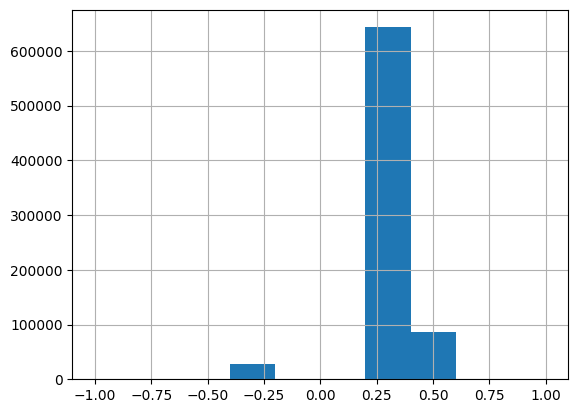

In [23]:
spearman_pairwise['coef'].hist(range=[-1, 1])

<Axes: >

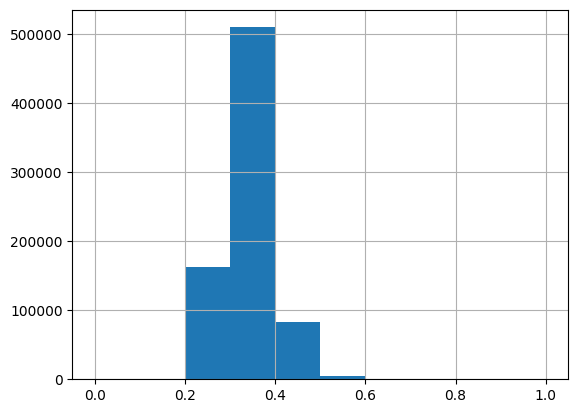

In [24]:
abs(spearman_pairwise['coef']).hist(range=[0, 1])

In [25]:
# filter for effect
df_no_effect = spearman_pairwise[abs(spearman_pairwise['coef'])<0.01]
df_very_small = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.01]
df_very_small = df_very_small[abs(df_very_small['coef'])<0.1]
df_effect = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.1]
print('\nNumber of analyte pairs whose effect size is at least weak: '.format(str(df_effect.shape[0])))


# evaluate effect size - cohen's d
df_small = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.1]
df_small = df_small[abs(df_small['coef'])<0.2]
df_medium = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.2]
df_medium  = df_medium[abs(df_medium['coef'])<0.3]
df_medium_large = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.3]
df_medium_large = df_medium_large[abs(df_medium_large['coef'])<0.5]
df_large = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.5]
df_large = df_large[abs(df_large['coef'])<0.7]
df_very_large = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.7]
df_very_large = df_very_large[abs(df_very_large['coef'])<0.9]
df_huge = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.9]

# print info on effect sizes
print('Number of Analyte Pairs with No Monotonic Relationship: {}'.format(str(df_no_effect.shape[0])))
print('Number of Analyte Pairs with Very Weak Monotonic Relationship: {}'.format(str(df_very_small.shape[0])))
print('Number of Analyte Pairs with Weak Monotonic Relationship: {}'.format(str(df_small.shape[0])))
print('Number of Analyte Pairs with Moderate Monotonic Relationship: {}'.format(str(df_medium.shape[0])))
print('Number of Analyte Pairs with Moderate Strong Monotonic Relationship: {}'.format(str(df_medium_large.shape[0])))
print('Number of Analyte Pairs with Strong Monotonic Relationship: {}'.format(str(df_large.shape[0])))
print('Number of Analyte Pairs with Very Strong Monotonic Relationship: {}'.format(str(df_very_large.shape[0])))
print('Number of Analyte Pairs with Near Perfect Monotonic Relationship: {}'.format(str(df_huge.shape[0])))


Number of analyte pairs whose effect size is at least weak: 
Number of Analyte Pairs with No Monotonic Relationship: 0
Number of Analyte Pairs with Very Weak Monotonic Relationship: 0
Number of Analyte Pairs with Weak Monotonic Relationship: 0
Number of Analyte Pairs with Moderate Monotonic Relationship: 162108
Number of Analyte Pairs with Moderate Strong Monotonic Relationship: 592124
Number of Analyte Pairs with Strong Monotonic Relationship: 4899
Number of Analyte Pairs with Very Strong Monotonic Relationship: 7
Number of Analyte Pairs with Near Perfect Monotonic Relationship: 0
